In [1]:
!nvidia-smi

Sun Sep 27 14:08:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
! pip install '/content/gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl'
from TaPR_pkg import etapr

Processing ./gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl


In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import math
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path + 'sample_submission.csv'

'''seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)'''

# these change models
timelen = 100
stride = 1

# these can be changed any time 
# no validation. only check if TaPR goes up.
epoch = 100
batch_size = 64
verbose = 2
optim = 'adam' # tfa.optimizers.SWA(tf.keras.optimizers.SGD())

In [10]:
########################################################################################### basic functions
def plot_history(history):
    plt.rcParams['figure.figsize'] = [16, 4]
    plt.plot(history.history['loss'], 'r--', history.history['val_loss'], 'b--')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
def put_labels(submission, threshold):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission > threshold] = 1
    return temp
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(25, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak )
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()
def test_and_get_list(model, some_list, some_raw_list):
    loss_list = []
    for num, (timeseq, raw) in enumerate(zip(some_list, some_raw_list)):
        res = np.zeros(timelen, dtype = 'float32')  # padding
        timeseq_X = Test_DataLoader(timeseq)
        with tf.device('/device:GPU:0'):
            predicted = model.predict(timeseq_X)
        pr = np.mean( np.abs(predicted - raw[timelen:]), axis = 1).astype('float32')
        res = np.concatenate((res, pr), axis=0)
        assert len(res) == len(raw)
        # loss = np.mean(np.abs(res, raw), axis = 1)
        loss_list.append(res)
    for num, loss in enumerate(loss_list):
        if num == 0:
            res = loss
        else:
            res = np.concatenate((res,loss), axis = 0)
    return res
def find_best_th(start, end, valid_result, valid_label, NN = 100):
    res = []
    ff = start
    ee = end
    inc = 0
    print('checking for TaPR...')
    for i in range(NN):
        th = ff + i * (ee-ff)/NN
        final = put_labels(valid_result, th)
        TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
        res.append((TaPR['f1'],th))
        inc += 1
        sys.stderr.write('\r\033[K' + get_progressbar_str(inc/NN))
        sys.stderr.flush()
    score, threshold = max(res)
    return score, threshold

In [11]:
########################################################################################### data preparation basic functions
class Test_DataLoader(keras.utils.Sequence):  # timegen 하나가 X 값만 뽑아줄 수 있도록 한다.
    def __init__(self,test_seq):
        self.test_seq = test_seq
    def __getitem__(self, i):
        return self.test_seq[i][0]
    def __len__(self):
        return len(self.test_seq)

def read_data(path, att = False, scaler = None, C_cols = None, demand_validation_ratio = None):
    file_paths = glob.glob(path+'/*.csv')
    res = []
    print("="*30)
    print("Attack :",att)
    if att and scaler and C_cols:
        label = None
        temp = 0
        for file in file_paths:
            f = pd.read_csv(file)
            temp += len(f)
            if 'attack' in f.columns:
                label = f['attack']
            res.append(scaler.transform(f[C_cols].values))
        print("Total test data : ", temp)
        print("List of DataFrame length : ",len(res))
        return res, label
    else:
        # df : appended dataframe to fit scaler
        df = pd.DataFrame()
        for file in file_paths:
            f=pd.read_csv(file)
            df = df.append(f, ignore_index=True)
            res.append(f)
        print("Total data length (including non-usable datas) : ",len(df))
        # make C01 ~ C79 list
        C_cols = list(df.columns)
        C_cols.remove('time')
        # make scaler
        scaler = MinMaxScaler()
        scaler.fit(df[C_cols].values)
        temp = 0
        for i, item in enumerate(res):
            res[i] = scaler.transform(item[C_cols].values)
            temp += len(res[i])
        print("List of DataFrame length : ",len(res))
        return res, C_cols, scaler

train_list, C_cols, scaler = read_data(path_train)
valid_list, valid_label = read_data(path_valid, att=True, scaler = scaler, C_cols = C_cols)
test_list, _ = read_data(path_test, att=True, scaler = scaler, C_cols = C_cols)
print(train_list[0].shape, valid_list[0].shape, valid_label.shape, test_list[0].shape)

def seq2timeser(some_list,sr,st,le,ba,sh):
    res = []
    for item in some_list:
        res.append( TimeseriesGenerator(item, item, sampling_rate = sr, stride = st, length = le, batch_size=ba, shuffle = sh) )
    return res

train_list_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)
valid_list_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)
test_list_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)

Attack : False
Total data length (including non-usable datas) :  921603
List of DataFrame length :  3
Attack : True
Total test data :  43201
List of DataFrame length :  1
Attack : True
Total test data :  358804
List of DataFrame length :  4
(216001, 79) (43201, 79) (43201,) (118801, 79)


Test1
----------

In [ ]:
Modelname = 'HAI_predict_1'

In [ ]:
def model5():
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
def model6():
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    mid = layers.Add()([inp[:,0,:],mid])
    out = layers.Dense(79, activation = 'elu')(mid)
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
def model7():
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(150, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(150, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    mid = layers.Add()([inp[:,0,:],mid])
    out = layers.Dense(79, activation = 'elu')(mid)
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
def model8():
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    mid = layers.Dense(79, activation = 'elu')(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

models = [model5(), model6(),  model7(), model8()]
Modelnames = [Modelname + '_' + str(i) for i in range(len(models))]

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional_33 (Bidirectional (None, 100, 200)     144000      input_12[0][0]                   
__________________________________________________________________________________________________
bidirectional_34 (Bidirectional (None, 100, 200)     240800      bidirectional_33[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice_11 (T [(None, 79)]         0           input_12[0][0]                   
______________________________________________________________________________________

Starting to train  HAI_predict_1_0
epoch :  0
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9195081347251405854546880627
epoch :  1
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  1   score :  0.9375750996732388009511733849
model save :  HAI_predict_1_0_epoch_1.h5


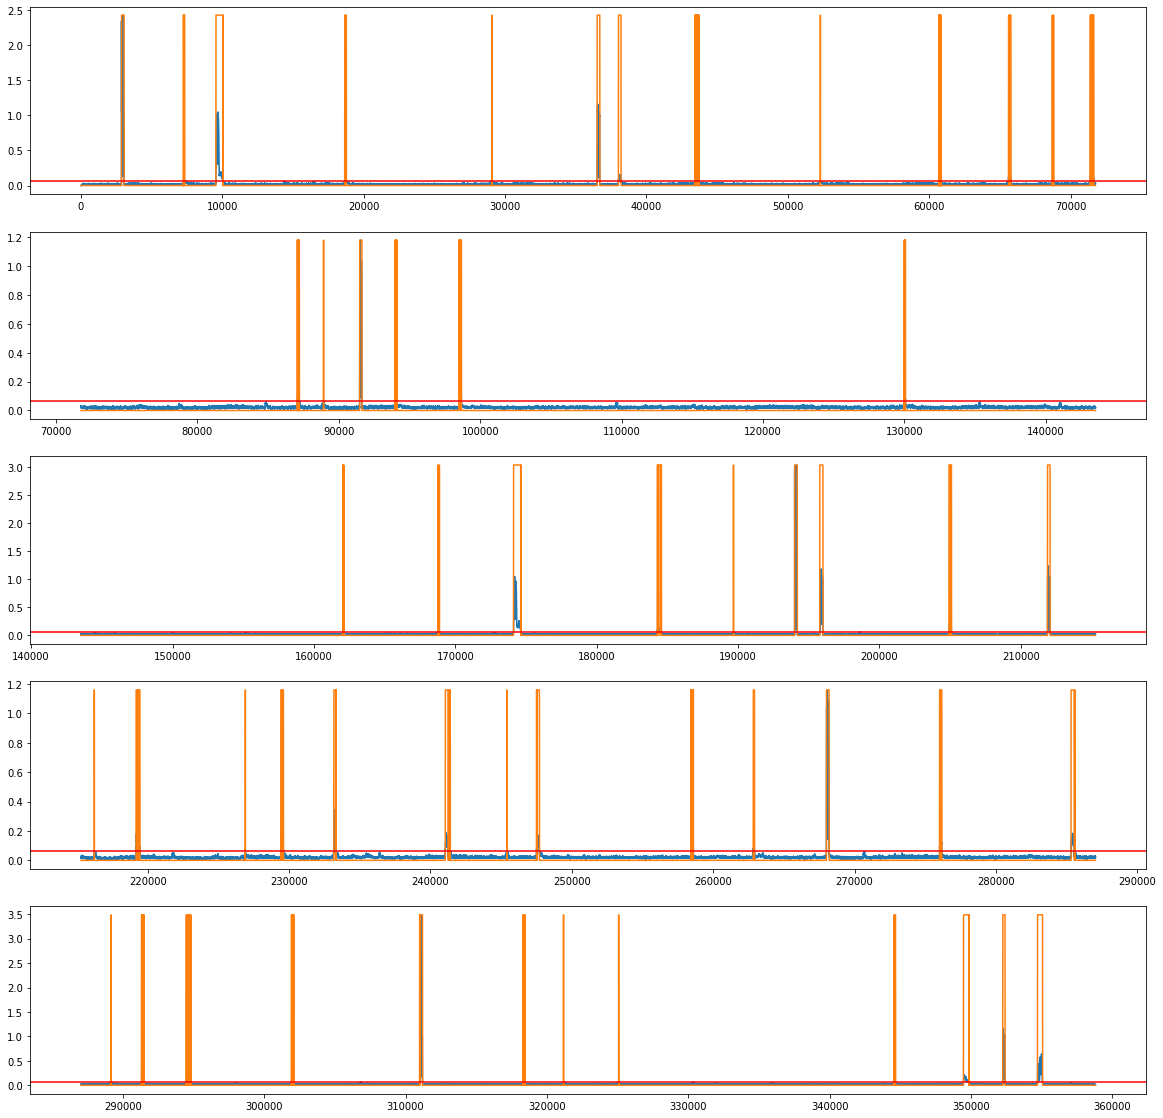

submission saved
epoch :  2
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8937827772510479575692370657
epoch :  3
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9026957144015750650376659499
epoch :  4
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9186651020019829487625006755
epoch :  5
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9154465791369688054951254299
epoch :  6
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9264941038549313307323136992
epoch :  7
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9213391831300545190189036289
epoch :  8
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  8   score :  0.9325866973957824360791541863
model save :  HAI_predict_1_0_epoch_8.h5


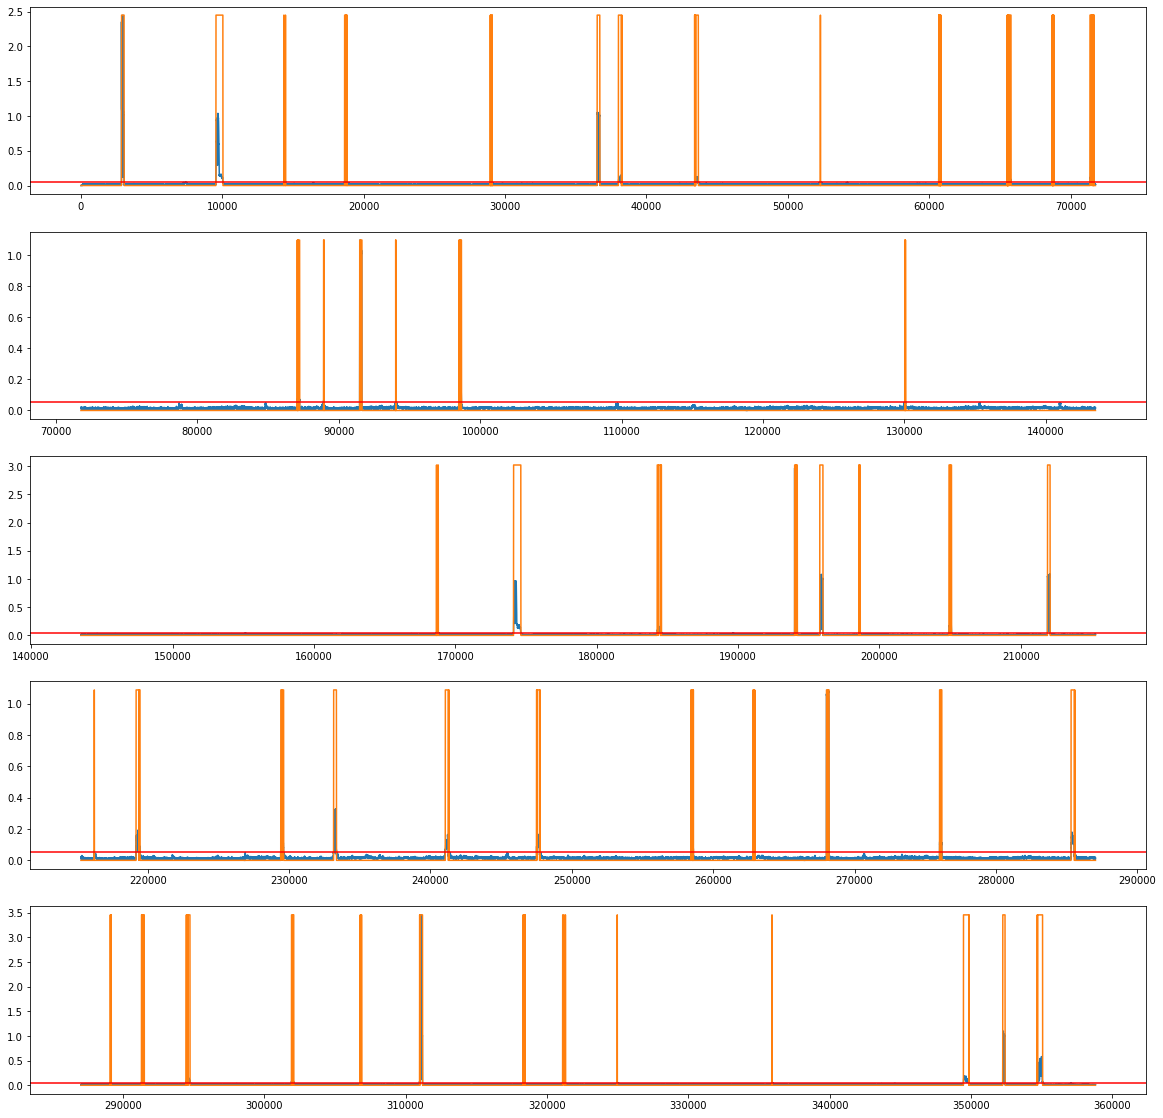

submission saved
epoch :  9
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  9   score :  0.9352772428273382351515285137
model save :  HAI_predict_1_0_epoch_9.h5


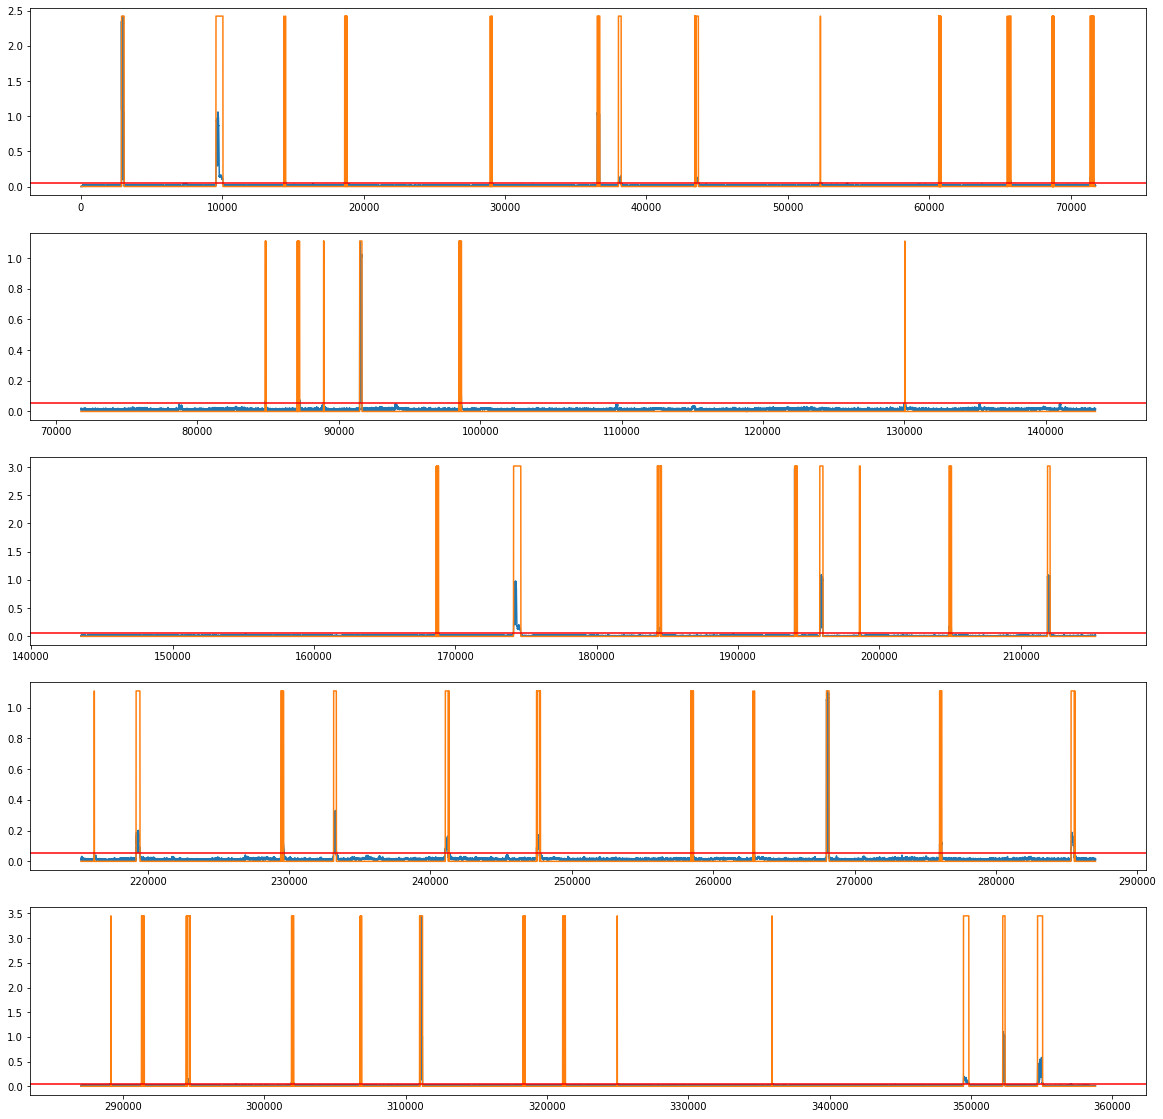

submission saved
epoch :  10
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  10   score :  0.9492276985320087737771584914
model save :  HAI_predict_1_0_epoch_10.h5


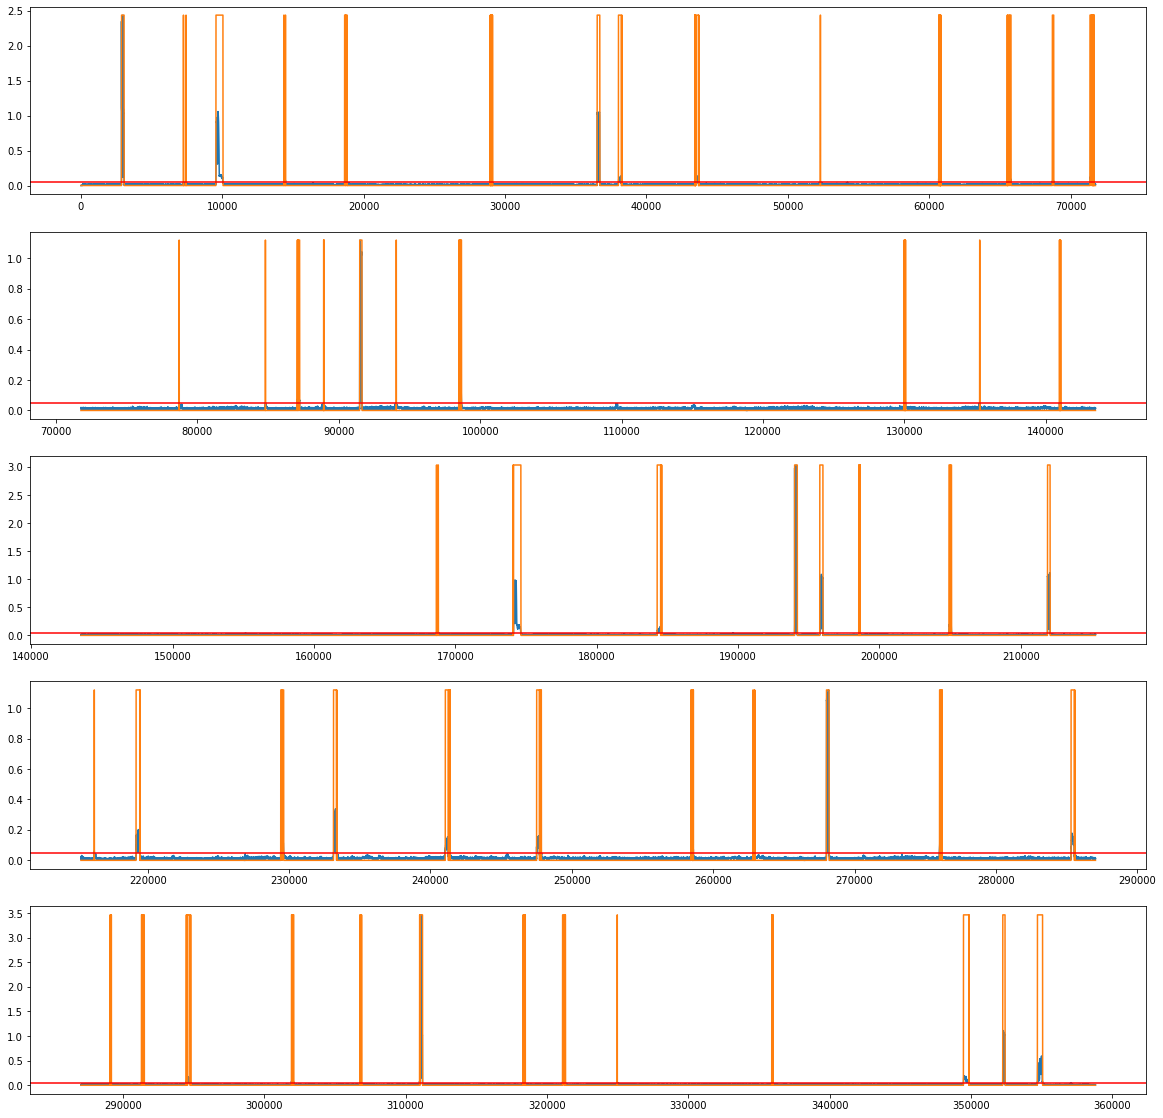

submission saved
epoch :  11
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  11   score :  0.9475329353926951968725522748
model save :  HAI_predict_1_0_epoch_11.h5


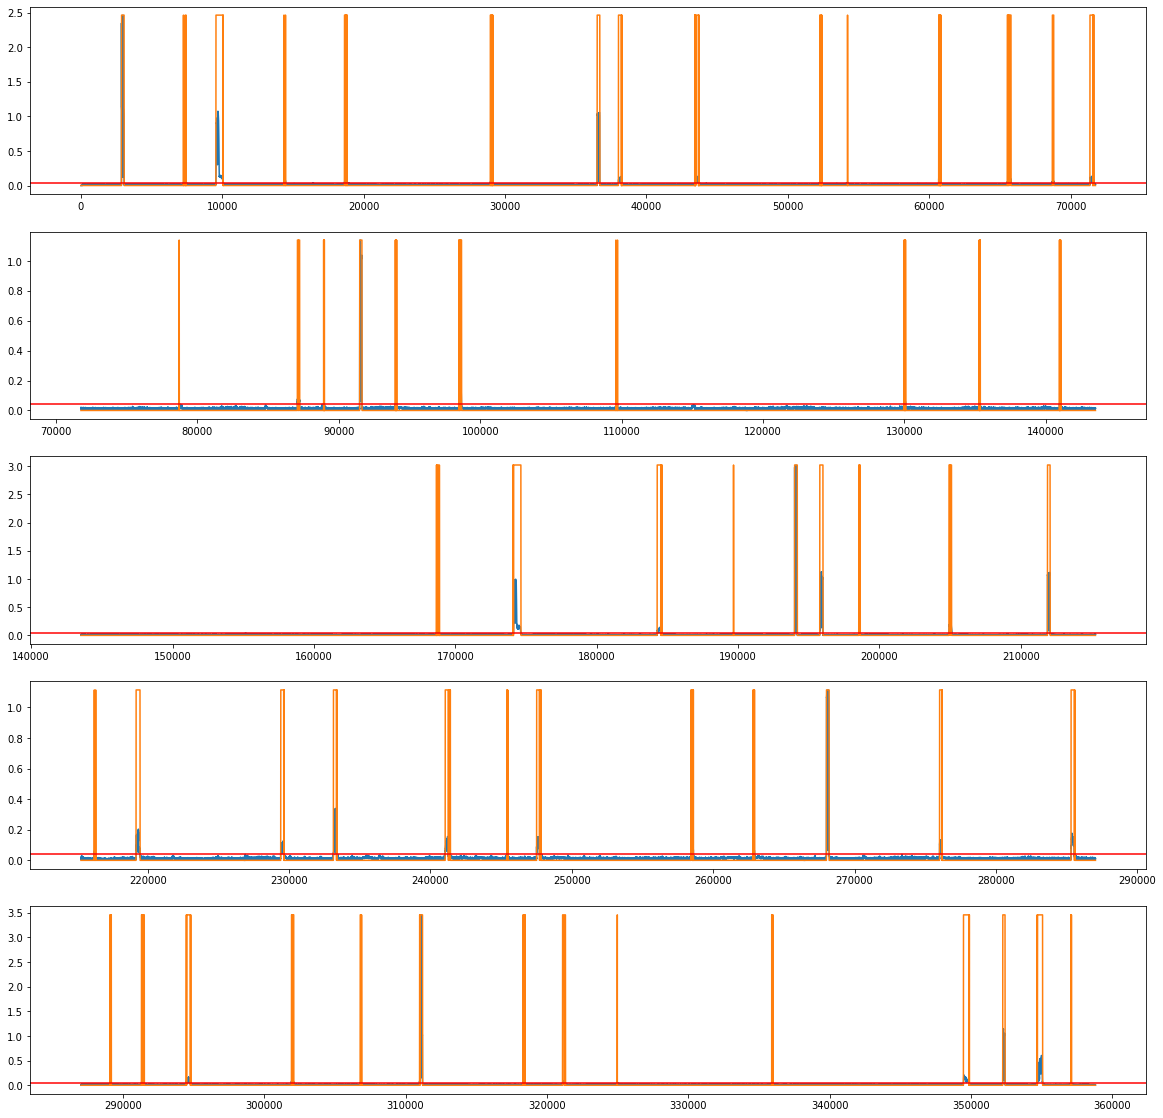

submission saved
epoch :  12
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9150779930348964449420514469
epoch :  13
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9126681464503333387926202259
epoch :  14
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8934202409084370598393598259
epoch :  15
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9261763614790294134645130105
epoch :  16
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  16   score :  0.9476391011158861442212835256
model save :  HAI_predict_1_0_epoch_16.h5


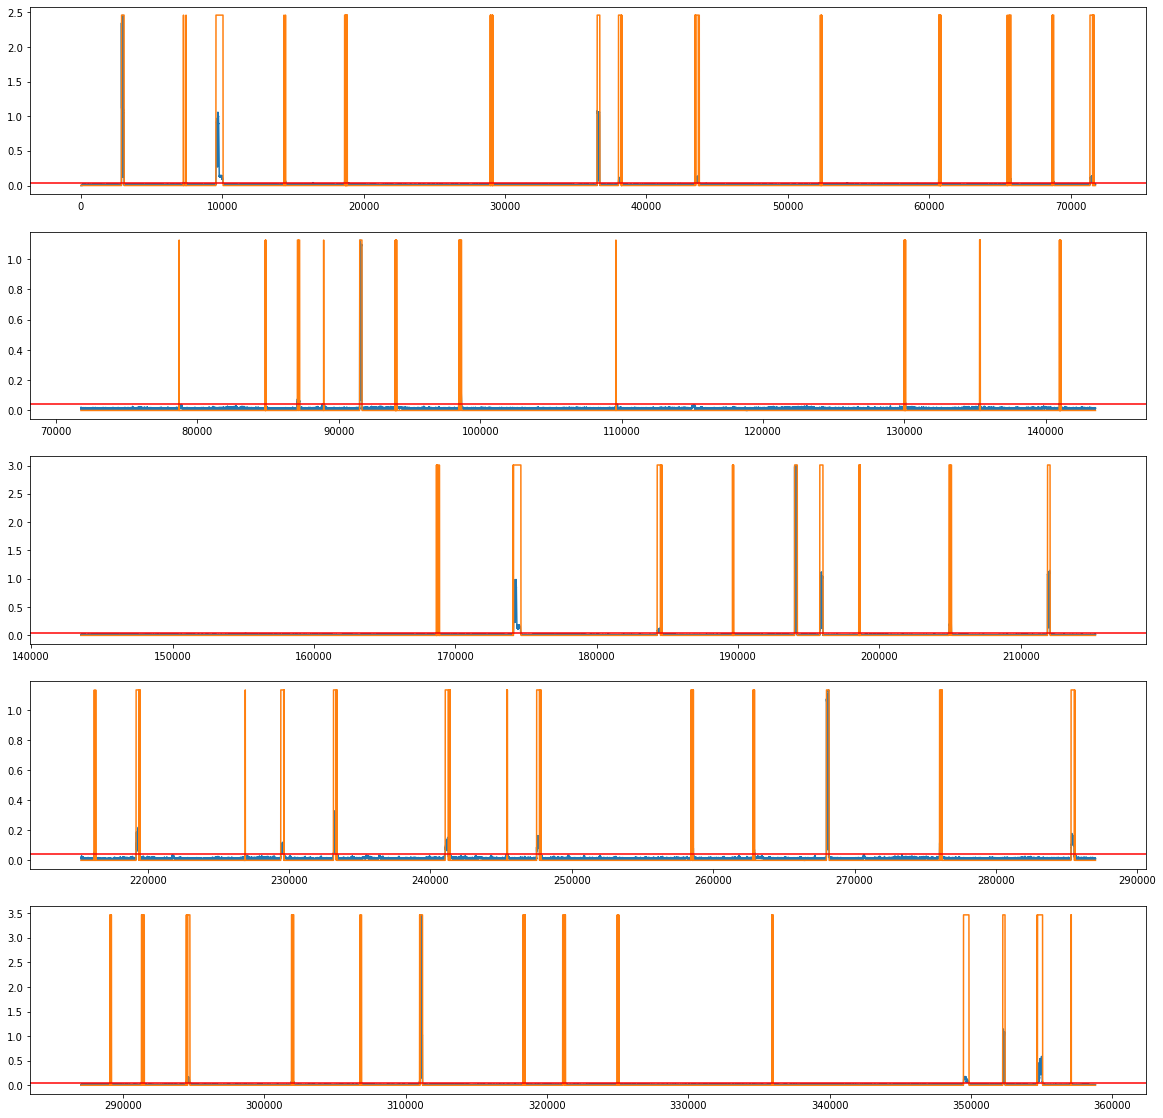

submission saved
epoch :  17
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9065474108396530231980352521
epoch :  18
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  18   score :  0.9542654426952624799938361213
model save :  HAI_predict_1_0_epoch_18.h5


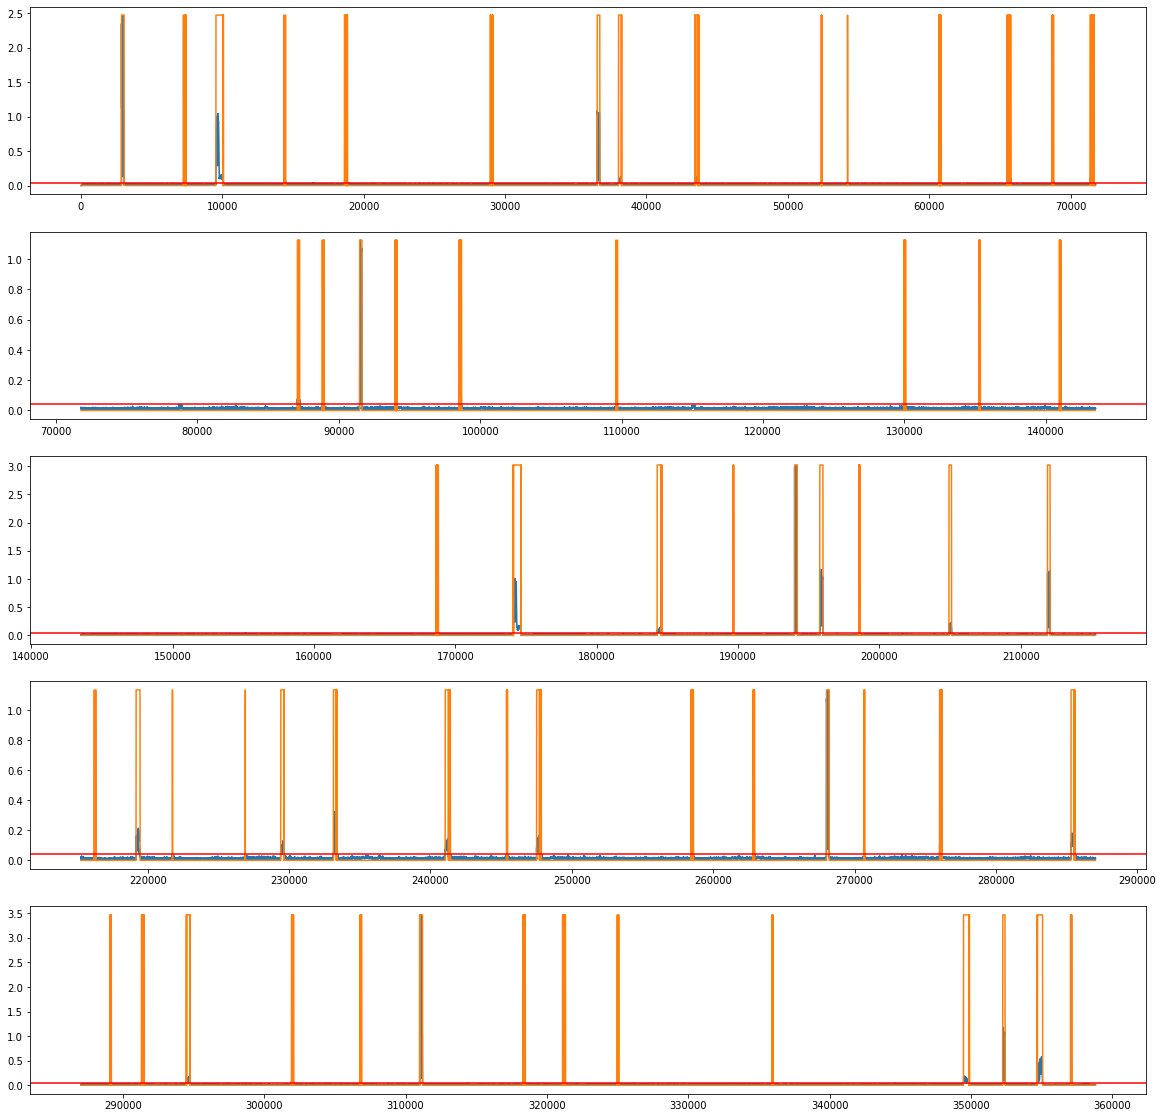

submission saved
epoch :  19
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9024313199692321694271386473
epoch :  20
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9182642408363214682182613138
epoch :  21
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8992162539138442506920872935
epoch :  22
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9216368950653927745483419868
epoch :  23
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9060701051338687571892401351
epoch :  24
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_1_0   epoch :  24   score :  0.9424498347853560234273577236
model save :  HAI_predict_1_0_epoch_24.h5


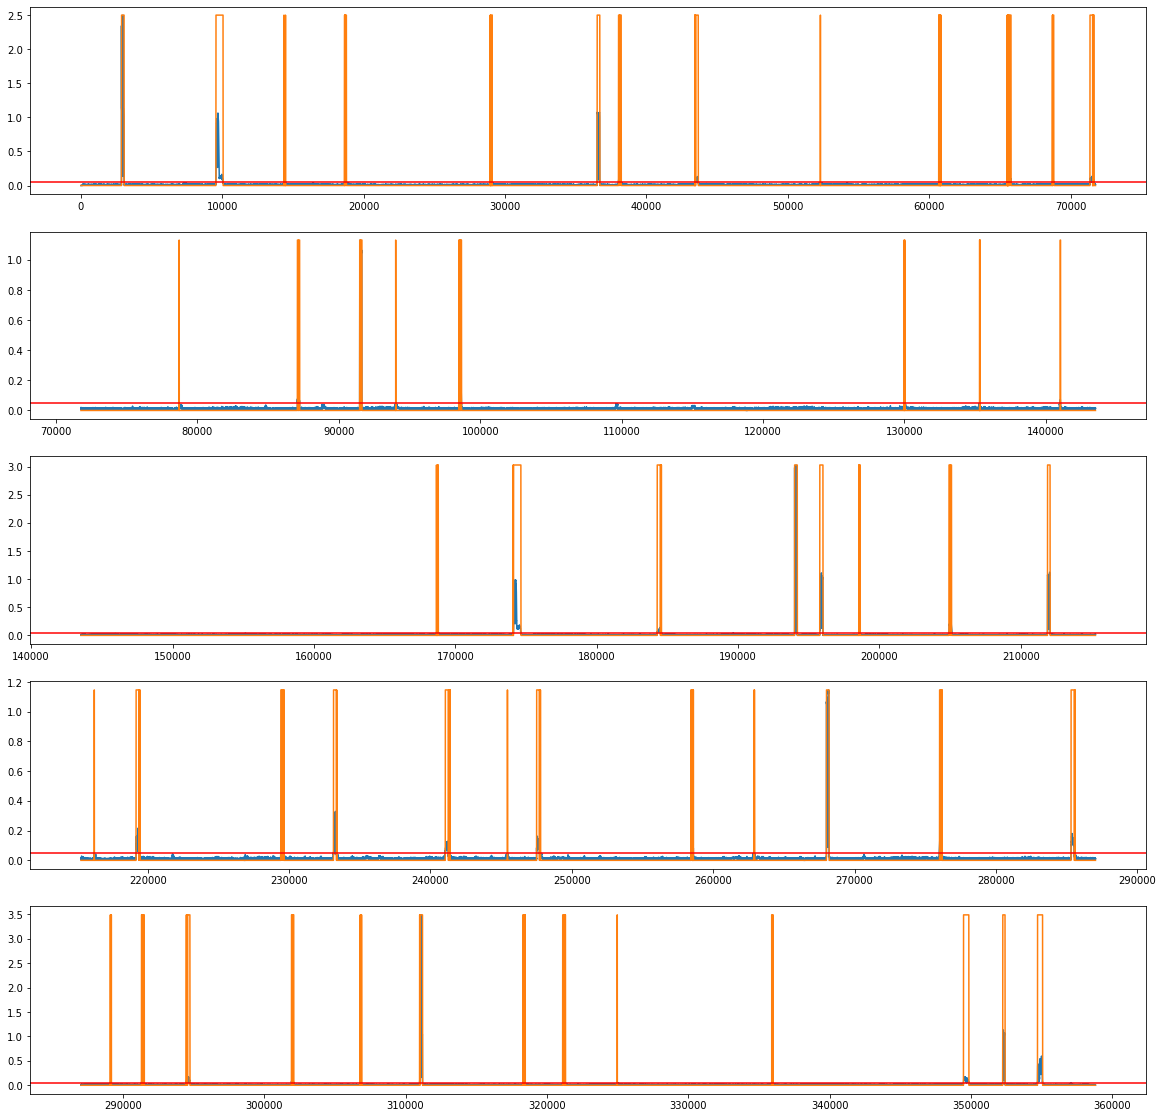

submission saved
epoch :  25
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9097969237927509678857144919
epoch :  26
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_1_1
epoch :  0
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1449924956931624473397581570
epoch :  1
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6758139753263741240986463626
epoch :  2
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6803979182695051829321413437
epoch :  3
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7861566971918685624958948378
epoch :  4
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7857704381692168593277110207
epoch :  5
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7940980521209996690321269348
epoch :  6
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8135225319524978622306136358
epoch :  7
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8162916202117141846509985622
epoch :  8
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8338171628188372305762114586
epoch :  9
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8183593507929503381340600823
epoch :  10
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8370225014602272484365396501
epoch :  11
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8367038521583213675804711032
epoch :  12
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8251638844829063868923156594
epoch :  13
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8299156084647746484495944621
epoch :  14
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8346272598642527755444860720
epoch :  15
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8114616526198951333861968084
epoch :  16
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8171186619178686168501579849
epoch :  17
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8216982337903769906824560626
epoch :  18
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8260511903678849633177143268
epoch :  19
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8227054899202857633733014370
epoch :  20
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8115567817982929708067532685
epoch :  21
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8250558754831470655895754018
epoch :  22
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8304346055687022646253329263
epoch :  23
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8215317193242919186332026872
epoch :  24
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8316318233068192178042863963
epoch :  25
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8193425663566108258139764201
epoch :  26
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_1_2
epoch :  0
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6666028380223393184788762722
epoch :  1
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6989256395273016325916254213
epoch :  2
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7856381655607920067946097137
epoch :  3
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8080026620303857642773593962
epoch :  4
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8049352216687514164157820303
epoch :  5
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8173919825477001249535649695
epoch :  6
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8342544823505285641427877597
epoch :  7
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8184968596218490702729318311
epoch :  8
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8341620008481762975459256998
epoch :  9
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8350903764095155706599589597
epoch :  10
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8408798068840670185946731673
epoch :  11
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8983466360620624618770738486
epoch :  12
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8769011372881650609343268382
epoch :  13
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8398252049984289799617019038
epoch :  14
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8433099708192100571061227155
epoch :  15
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8629531427634135996245304463
epoch :  16
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8551794924157316677111487961
epoch :  17
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8524417715912224913766584360
epoch :  18
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8703800585469764982963793406
epoch :  19
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8422022399451503112142310707
epoch :  20
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8437864297505391605617623108
epoch :  21
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8531236576421862072991521977
epoch :  22
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8406158006985703920787547037
epoch :  23


KeyboardInterrupt: ignored

In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 0)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if e > 25 and score < 0.93:
                break
            elif score < 0.93:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 5, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')


generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Test2 - develop from bi + skip
--------

In [ ]:
Modelname = 'HAI_predict_2'

In [ ]:
def model1():                                   # 2skip, 2layer
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model2():                                   # 2skip, 1layer
    inp = layers.Input(shape = (timelen,79))
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(inp)
    mid = layers.Add()([inp,mid])
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model3():                                   # 2skip, 3layer
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model4():                                   # 3skip, 2layer
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model5():                                   # 3skip, 3layer
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model6():                                   # 4skip, 3layer
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model


models = [model1(), model2(), model3(), model4(), model5(), model6()]
Modelnames = [Modelname + '_' + str(i+1) for i in range(len(models))]

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional_54 (Bidirectional (None, 100, 200)     144000      input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_55 (Bidirectional [(None, 100, 79), (N 176960      bidirectional_54[0][0]           
__________________________________________________________________________________________________
add_19 (Add)                    (None, 100, 79)      0           input_19[0][0]                   
                                                                 bidirectional_55[0][0

Starting to train  HAI_predict_2_1
epoch :  0
4987/4987 - 140s - loss: 0.0053
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9354656559150006480513588489
epoch :  1
4987/4987 - 140s - loss: 0.0015
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8983052239288062185334555558
epoch :  2
4987/4987 - 141s - loss: 0.0012
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8985959558675843487182738413
epoch :  3
4987/4987 - 142s - loss: 9.4970e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9351915472770689863481940580
epoch :  4
4987/4987 - 140s - loss: 8.1849e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9321683367472787129597321507
epoch :  5
4987/4987 - 140s - loss: 7.6694e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8962012332684511034494280615
epoch :  6
4987/4987 - 142s - loss: 7.1327e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8990391265437288966060460918
epoch :  7
4987/4987 - 140s - loss: 6.7266e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9437324124387179203623279574
epoch :  8
4987/4987 - 140s - loss: 6.4480e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9391492961776173700445248487
epoch :  9
4987/4987 - 142s - loss: 6.2437e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9454864081906423940151385564
epoch :  10
4987/4987 - 140s - loss: 6.1810e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9459275711824051923853773255
epoch :  11
4987/4987 - 141s - loss: 6.1073e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_1   epoch :  11   score :  0.9508875074568819505807420544
model save :  HAI_predict_2_1_epoch_11.h5


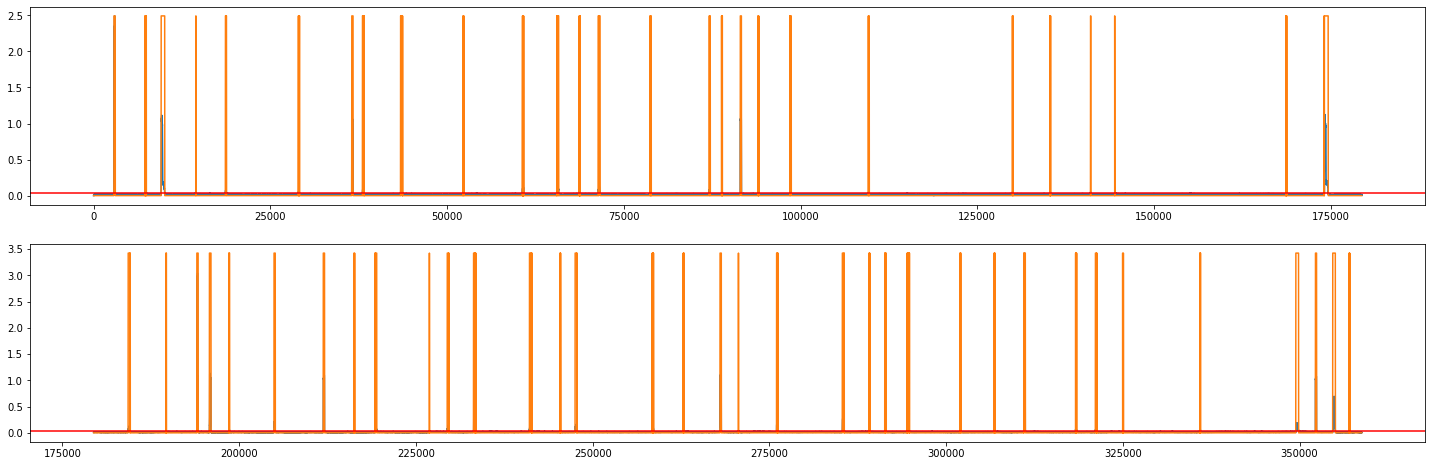

submission saved
epoch :  12
4987/4987 - 140s - loss: 5.9613e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9475203913124411549656760320
epoch :  13
4987/4987 - 141s - loss: 5.9024e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9245584458092502808896988038
epoch :  14
4987/4987 - 142s - loss: 5.8441e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_1   epoch :  14   score :  0.9517101606509985577758544554
model save :  HAI_predict_2_1_epoch_14.h5


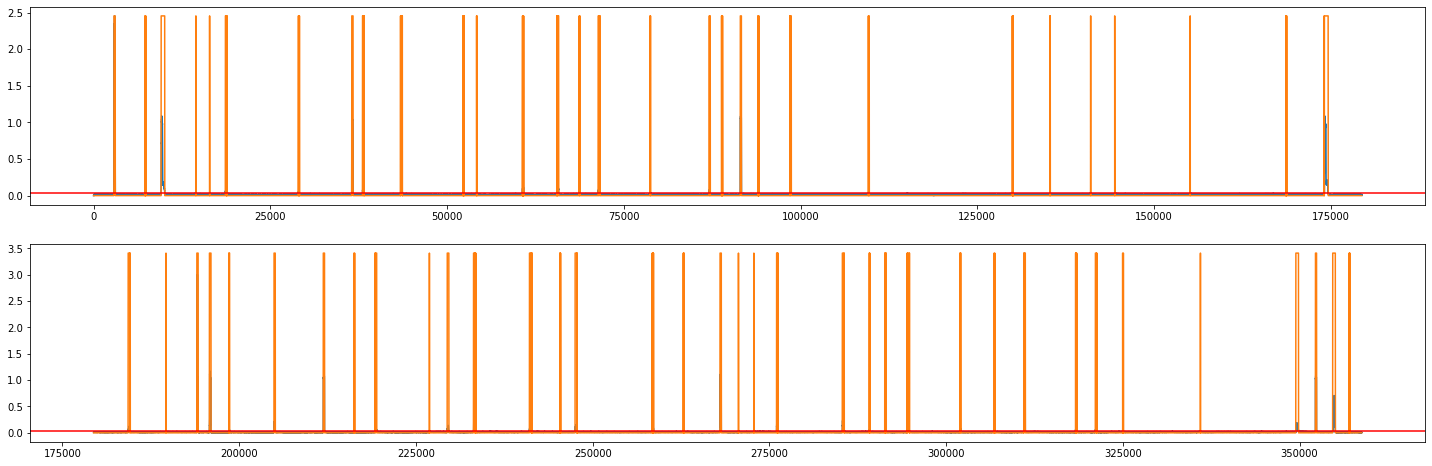

submission saved
epoch :  15
4987/4987 - 142s - loss: 5.7771e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9484534491851343633053615171
epoch :  16
4987/4987 - 141s - loss: 4.9697e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9492631974344085965834361327
epoch :  17
4987/4987 - 140s - loss: 4.6064e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9368547998825271720811821414
epoch :  18
4987/4987 - 141s - loss: 4.5010e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9229540104434595925231633280
epoch :  19
4987/4987 - 141s - loss: 4.4750e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9201753893824475627741113996
epoch :  20
4987/4987 - 141s - loss: 4.4255e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9373841807274286286550673750
epoch :  21
4987/4987 - 141s - loss: 4.4203e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9351170245144861263504630482
epoch :  22
4987/4987 - 141s - loss: 4.4110e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9362828498349636379992218719
epoch :  23
4987/4987 - 141s - loss: 4.3511e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9287276654710005959437488316
epoch :  24
4987/4987 - 141s - loss: 4.3235e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9376231019768010973642245447
epoch :  25
4987/4987 - 141s - loss: 4.2898e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9409281627580430415861698173
epoch :  26
4987/4987 - 141s - loss: 4.2345e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_1   epoch :  26   score :  0.9501343529581162205535022703
model save :  HAI_predict_2_1_epoch_26.h5


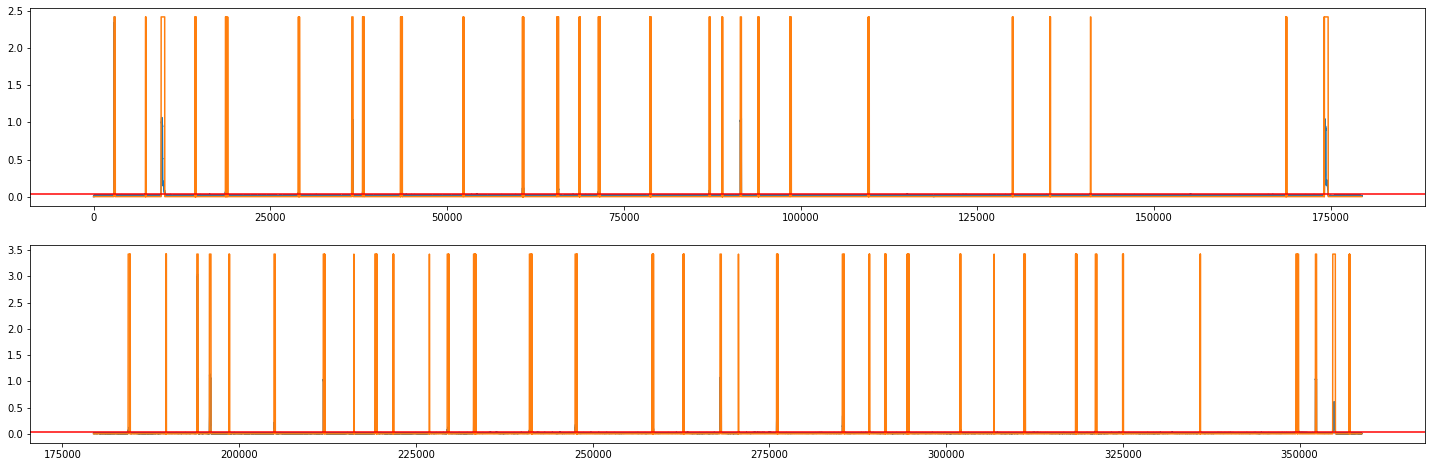

submission saved
epoch :  27
4987/4987 - 140s - loss: 4.2419e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9416437614481256160967519857
epoch :  28
4987/4987 - 141s - loss: 4.1877e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9499545391492064140740073533
epoch :  29
4987/4987 - 141s - loss: 4.1564e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_1   epoch :  29   score :  0.9549326664103534556313002808
model save :  HAI_predict_2_1_epoch_29.h5


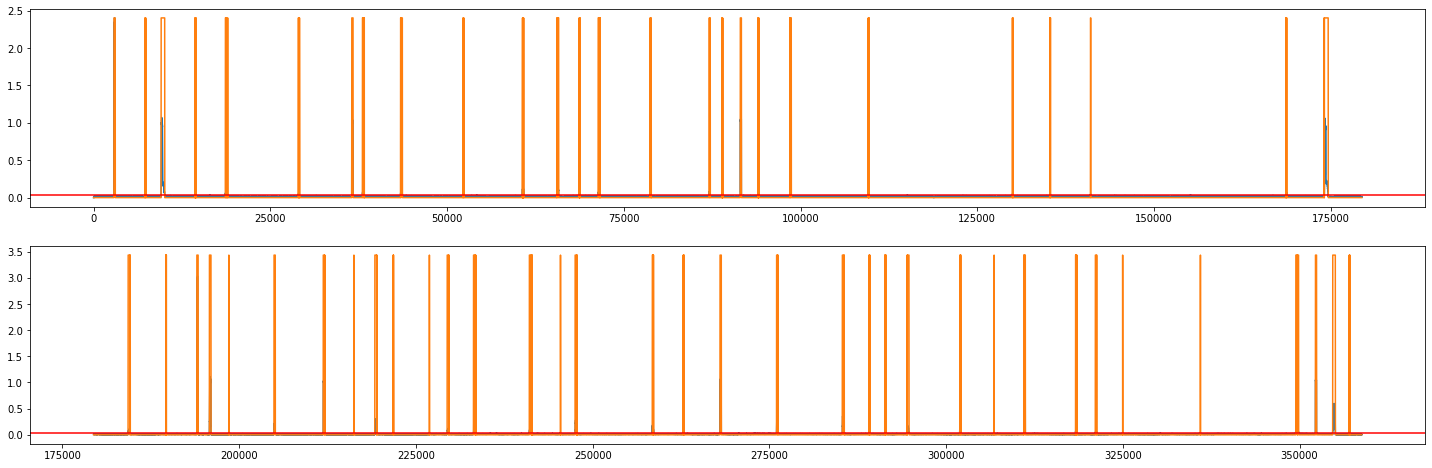

submission saved
epoch :  30
4987/4987 - 141s - loss: 4.1018e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9476895052487385304894929134
epoch :  31
4987/4987 - 141s - loss: 4.1055e-04
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_2_2
epoch :  0
4987/4987 - 50s - loss: 0.0063
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8866016196516690027501184767
epoch :  1
4987/4987 - 50s - loss: 0.0020
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8446177562562801715896477582
epoch :  2
4987/4987 - 50s - loss: 0.0015
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7023620597019128334125741192
epoch :  3
4987/4987 - 51s - loss: 0.0014
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8109940284303063420956916755
epoch :  4
4987/4987 - 50s - loss: 0.0012
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8520518886590135207868989491
epoch :  5
4987/4987 - 50s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8514211250144938764266636340
epoch :  6
4987/4987 - 50s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8298312025055675300479591089
epoch :  7
4987/4987 - 49s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8654916878043018347535343171
epoch :  8
4987/4987 - 50s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9236483469106904883009081325
epoch :  9
4987/4987 - 50s - loss: 9.7264e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7696940848996737236685171951
epoch :  10
4987/4987 - 51s - loss: 9.4460e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7710481221445725939161891692
epoch :  11
4987/4987 - 50s - loss: 9.2917e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8953574433114272424378161774
epoch :  12
4987/4987 - 50s - loss: 9.1804e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8667933209237399663137469474
epoch :  13
4987/4987 - 50s - loss: 9.0788e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8436709718531261477021203516
epoch :  14
4987/4987 - 50s - loss: 8.9365e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8412226311370740420442973926
epoch :  15
4987/4987 - 50s - loss: 8.8017e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7618286745903126707935379955
epoch :  16
4987/4987 - 50s - loss: 8.7335e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9208984023910746306206255064
epoch :  17
4987/4987 - 51s - loss: 8.4201e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8552220212354845992540279599
epoch :  18
4987/4987 - 50s - loss: 8.3490e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8515704279403839634736919587
epoch :  19
4987/4987 - 50s - loss: 8.1794e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8675749673640439041209599414
epoch :  20
4987/4987 - 50s - loss: 8.1075e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8315212471503526388023772079
epoch :  21
4987/4987 - 50s - loss: 8.0186e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8399862106367150152396707747
epoch :  22
4987/4987 - 50s - loss: 7.8702e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8116218884229417241126882022
epoch :  23
4987/4987 - 50s - loss: 7.9260e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8719528452819373863504165820
epoch :  24
4987/4987 - 51s - loss: 7.7101e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8647561802567513286448787240
epoch :  25
4987/4987 - 50s - loss: 7.7455e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8688050135937088019616695760
epoch :  26
4987/4987 - 50s - loss: 7.6908e-04
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_2_3
epoch :  0
4987/4987 - 239s - loss: 0.0064
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9173258391746503905389763736
epoch :  1
4987/4987 - 239s - loss: 0.0015
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9259295799772180085532734279
epoch :  2
4987/4987 - 240s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9225554257260084655033527647
epoch :  3
4987/4987 - 240s - loss: 9.1369e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9170395618638738779182041373
epoch :  4
4987/4987 - 240s - loss: 8.0245e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9033934499985212430126207672
epoch :  5
4987/4987 - 240s - loss: 7.4761e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8821500117830514103532093605
epoch :  6
4987/4987 - 240s - loss: 7.0174e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9207308448934196842383085197
epoch :  7
4987/4987 - 240s - loss: 6.7964e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8923259015573201236414148954
epoch :  8
4987/4987 - 240s - loss: 6.5235e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9159240265158736571576239793
epoch :  9
4987/4987 - 240s - loss: 6.2476e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9327364250300354170459008355
epoch :  10
4987/4987 - 240s - loss: 6.0114e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  10   score :  0.9617889940869479440367881798
model save :  HAI_predict_2_3_epoch_10.h5


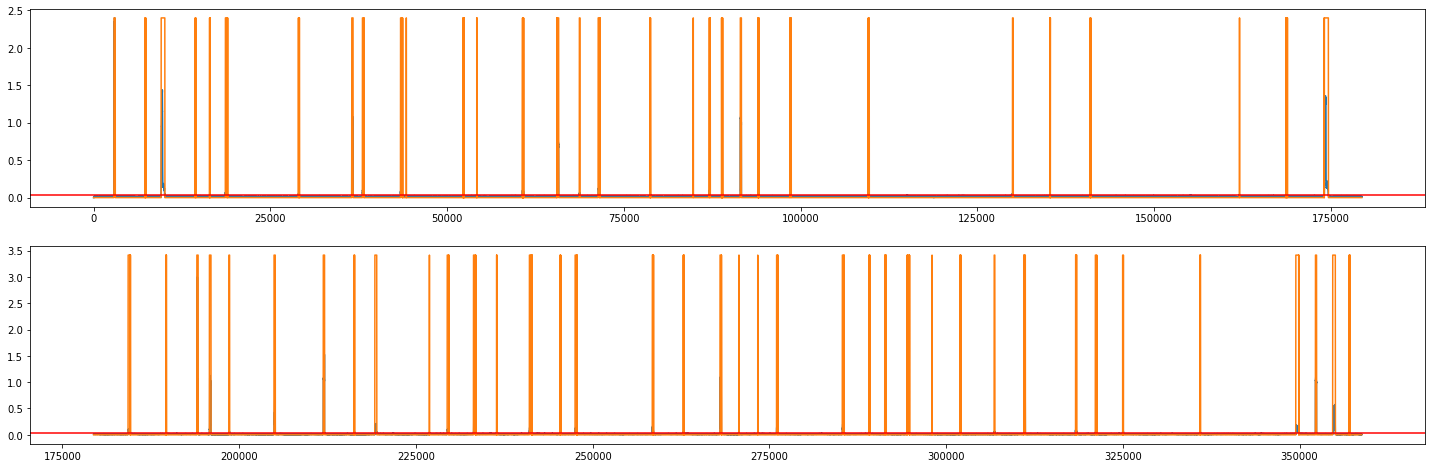

submission saved
epoch :  11
4987/4987 - 240s - loss: 5.5409e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9243118730032413803488799736
epoch :  12
4987/4987 - 240s - loss: 4.8919e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  12   score :  0.9531930155477019053648229598
model save :  HAI_predict_2_3_epoch_12.h5


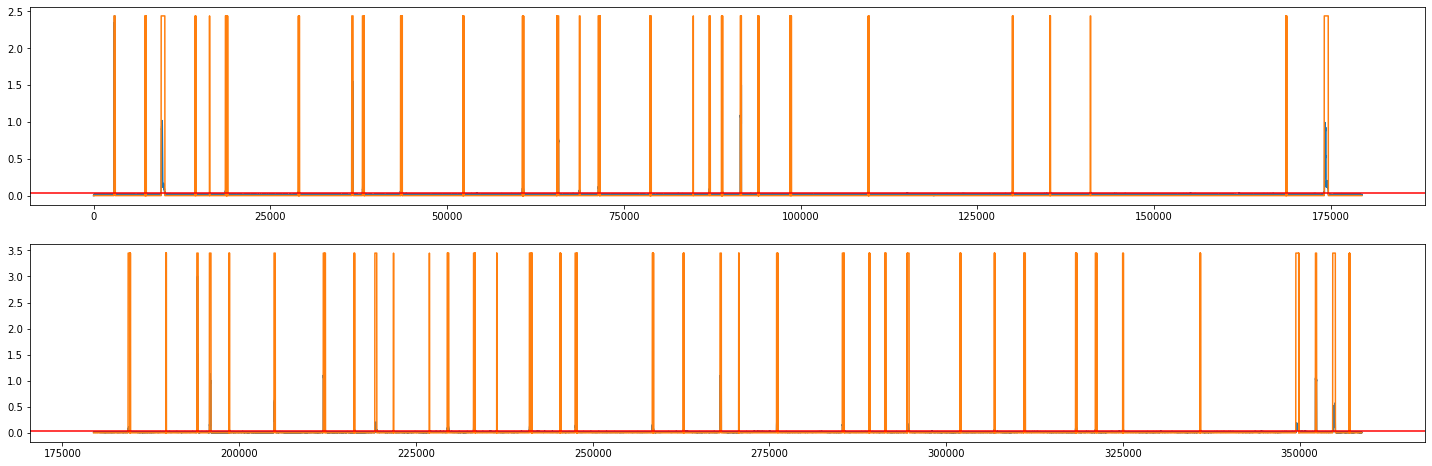

submission saved
epoch :  13
4987/4987 - 240s - loss: 4.7416e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  13   score :  0.9626439861377641886426926722
model save :  HAI_predict_2_3_epoch_13.h5


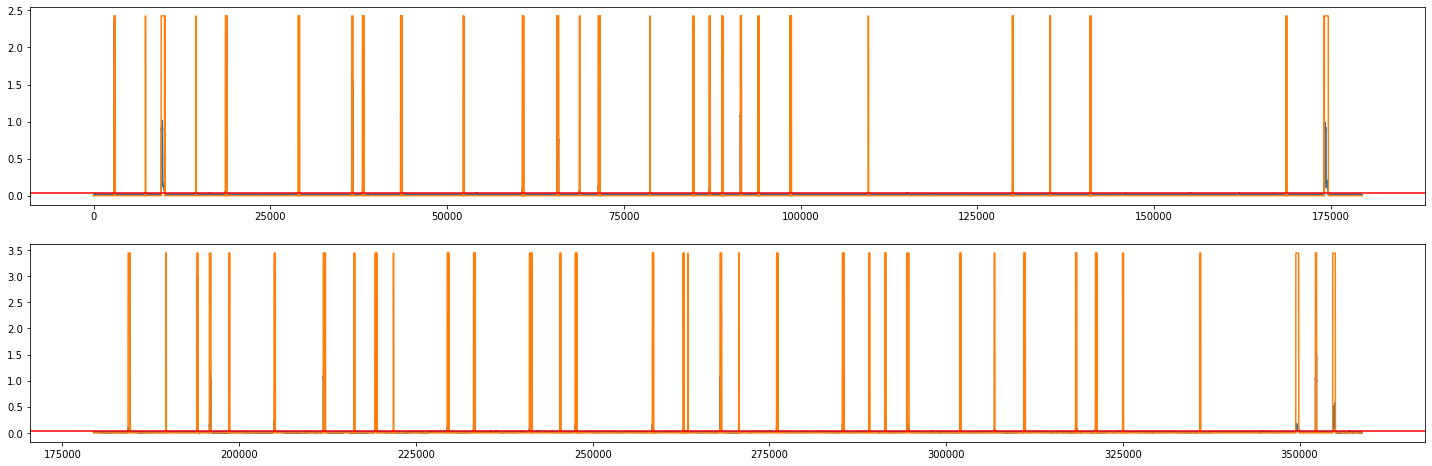

submission saved
epoch :  14
4987/4987 - 240s - loss: 4.6729e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9454838111077037459070557697
epoch :  15
4987/4987 - 240s - loss: 4.5897e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  15   score :  0.9643154683457487363198289748
model save :  HAI_predict_2_3_epoch_15.h5


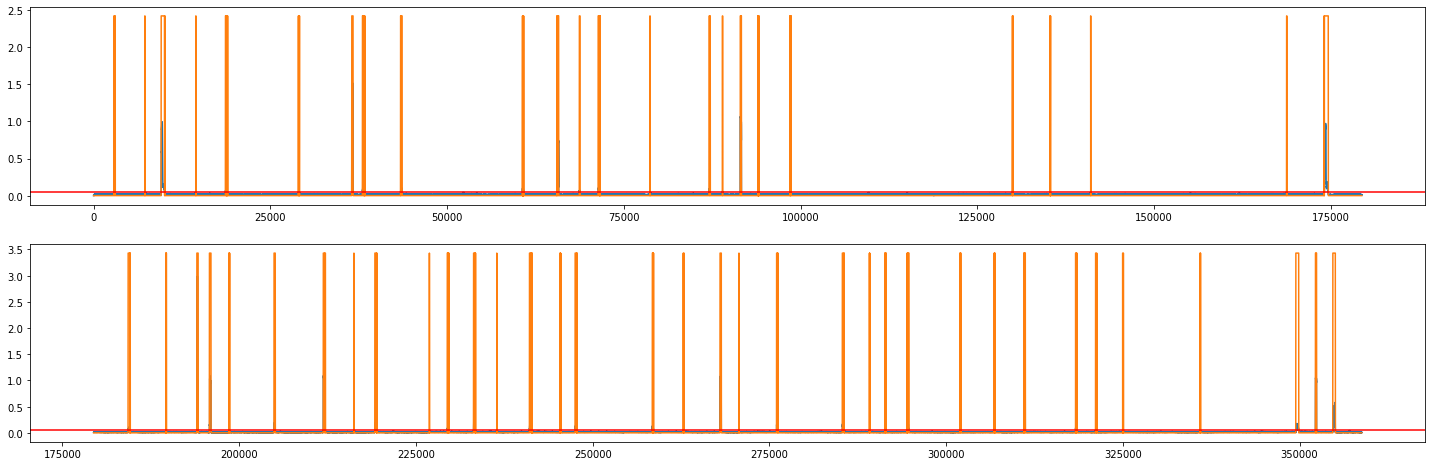

submission saved
epoch :  16
4987/4987 - 240s - loss: 4.4956e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  16   score :  0.9516574170908854971491964252
model save :  HAI_predict_2_3_epoch_16.h5


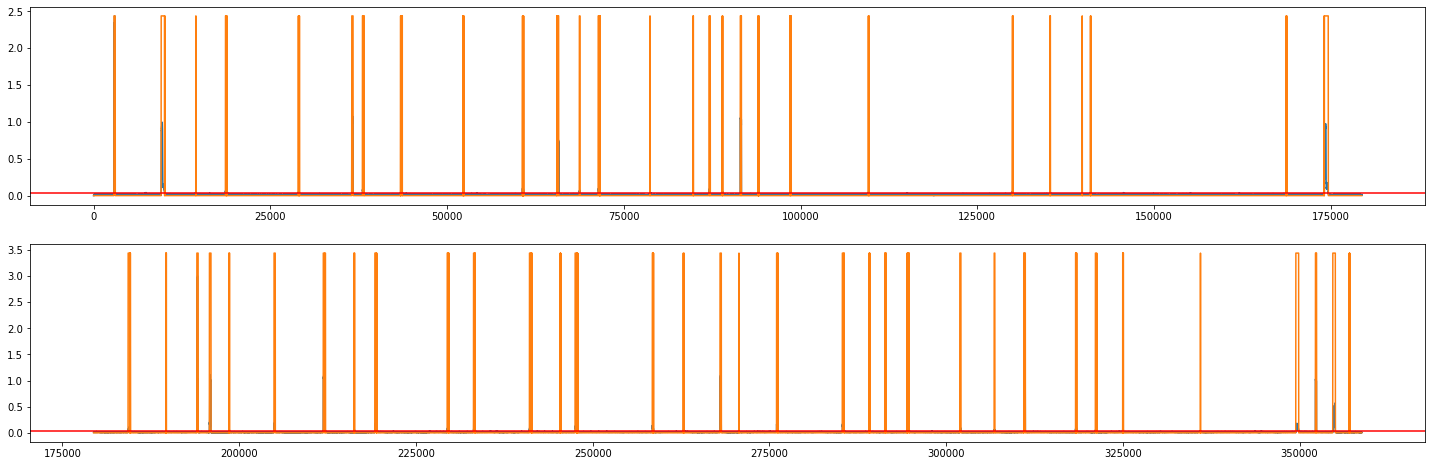

submission saved
epoch :  17
4987/4987 - 240s - loss: 4.4351e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  17   score :  0.9563640378898806915220172957
model save :  HAI_predict_2_3_epoch_17.h5


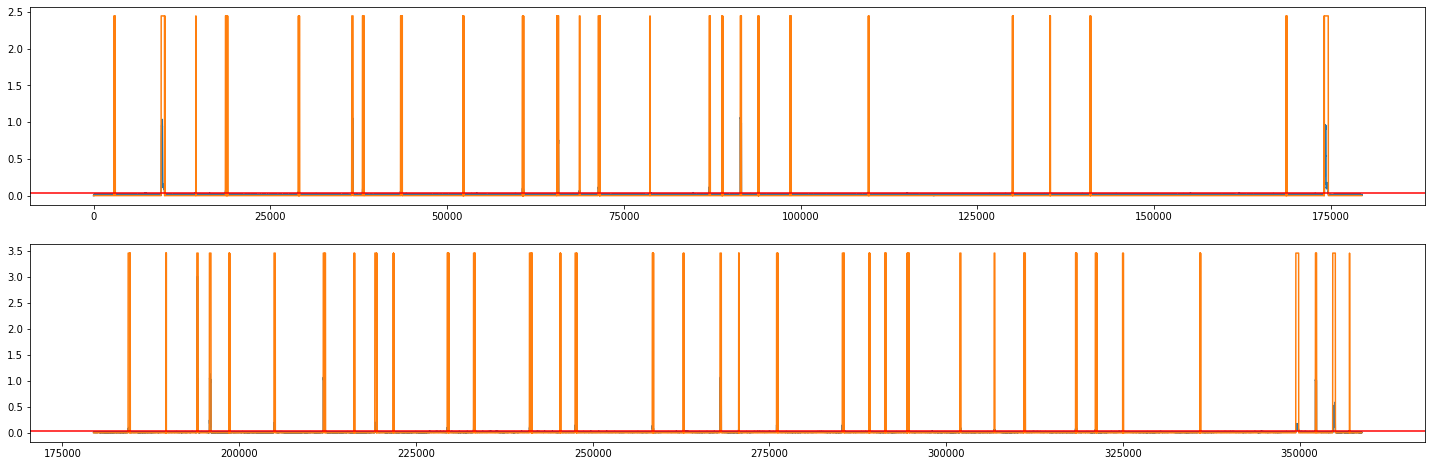

submission saved
epoch :  18
4987/4987 - 240s - loss: 4.4281e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  18   score :  0.9502876242083446632365190450
model save :  HAI_predict_2_3_epoch_18.h5


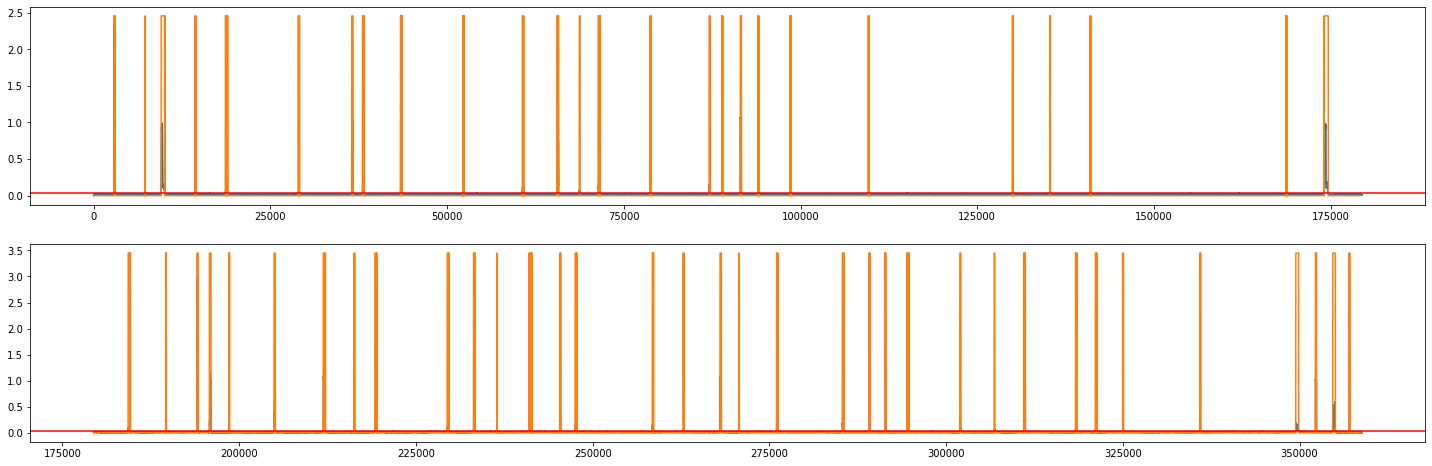

submission saved
epoch :  19
4987/4987 - 240s - loss: 4.3428e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  19   score :  0.9575136369797286408395103368
model save :  HAI_predict_2_3_epoch_19.h5


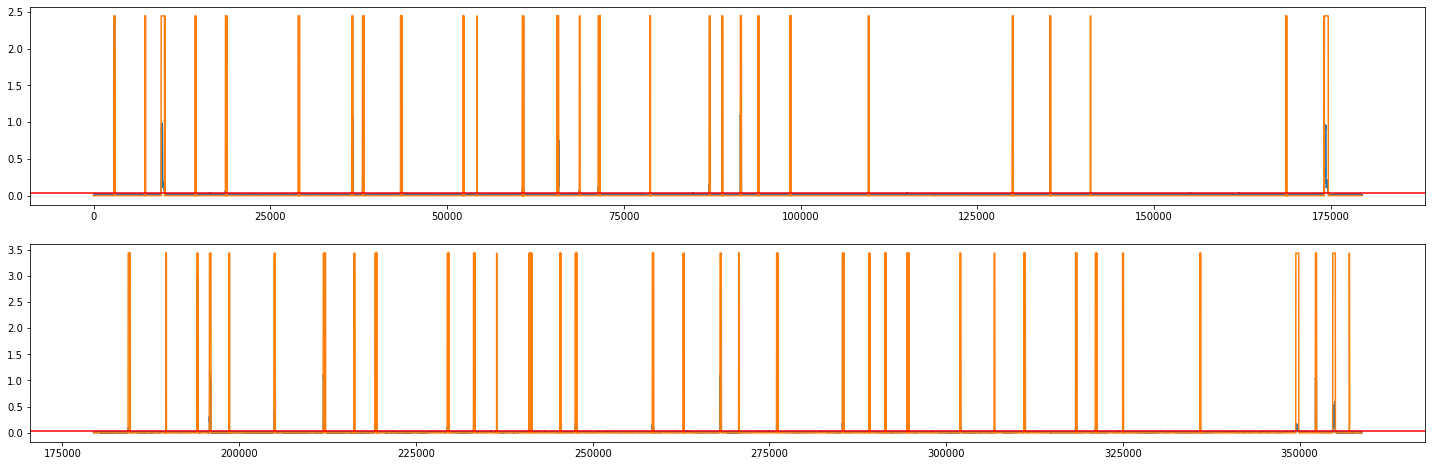

submission saved
epoch :  20
4987/4987 - 240s - loss: 4.3820e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9426055853961826551881214592
epoch :  21
4987/4987 - 240s - loss: 4.2906e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9165504215229652941390976371
epoch :  22
4987/4987 - 240s - loss: 4.2698e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  22   score :  0.9581903588390487725596696338
model save :  HAI_predict_2_3_epoch_22.h5


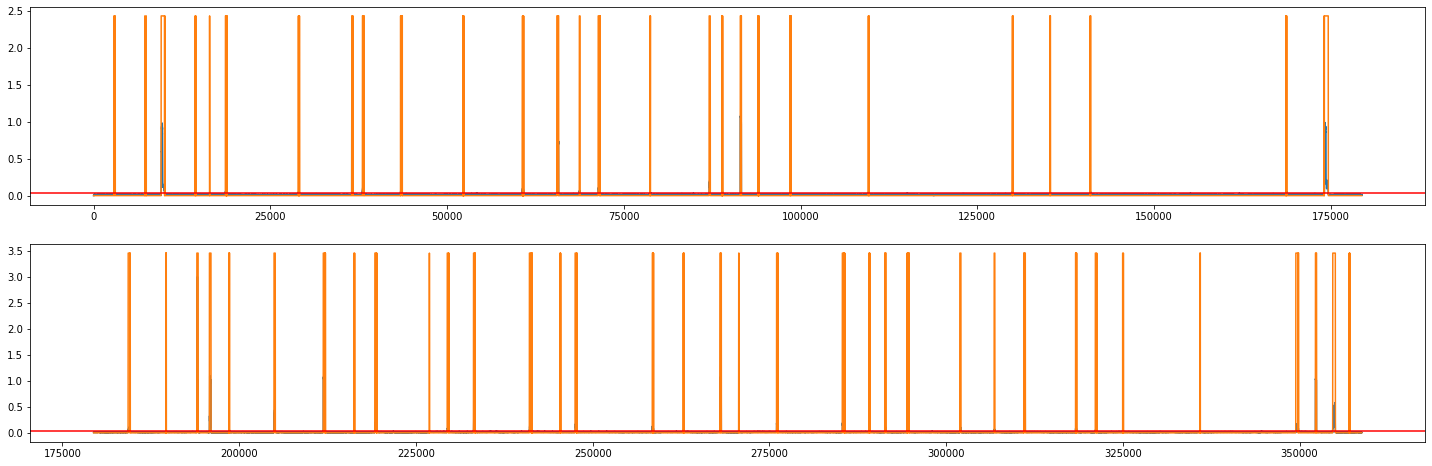

submission saved
epoch :  23
4987/4987 - 239s - loss: 4.2096e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  23   score :  0.9540117187858627166739783126
model save :  HAI_predict_2_3_epoch_23.h5


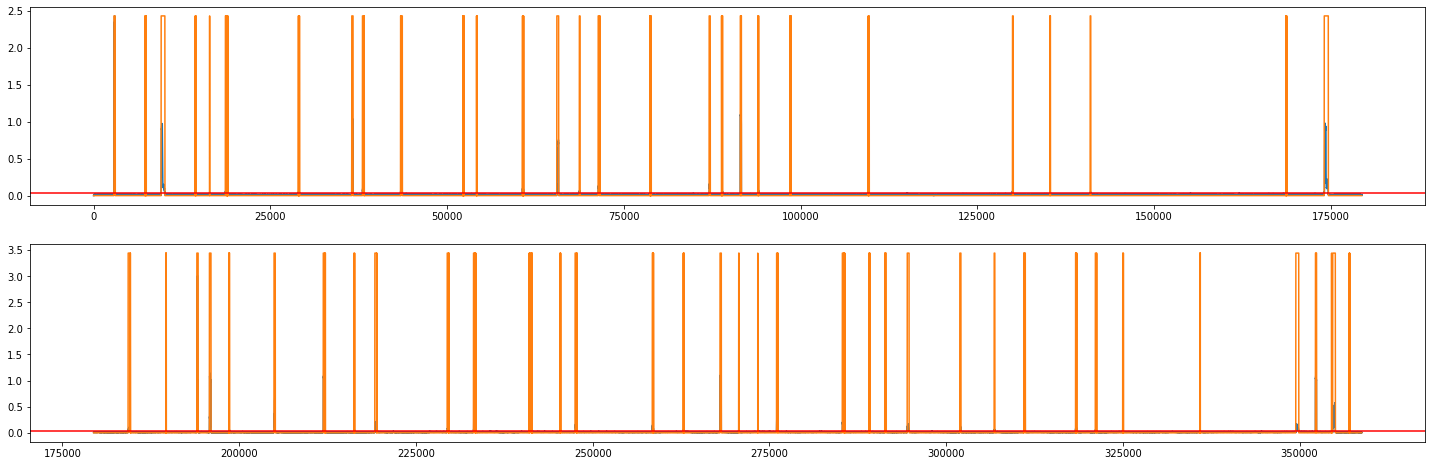

submission saved
epoch :  24
4987/4987 - 239s - loss: 4.1992e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  24   score :  0.9549728580337459438145874984
model save :  HAI_predict_2_3_epoch_24.h5


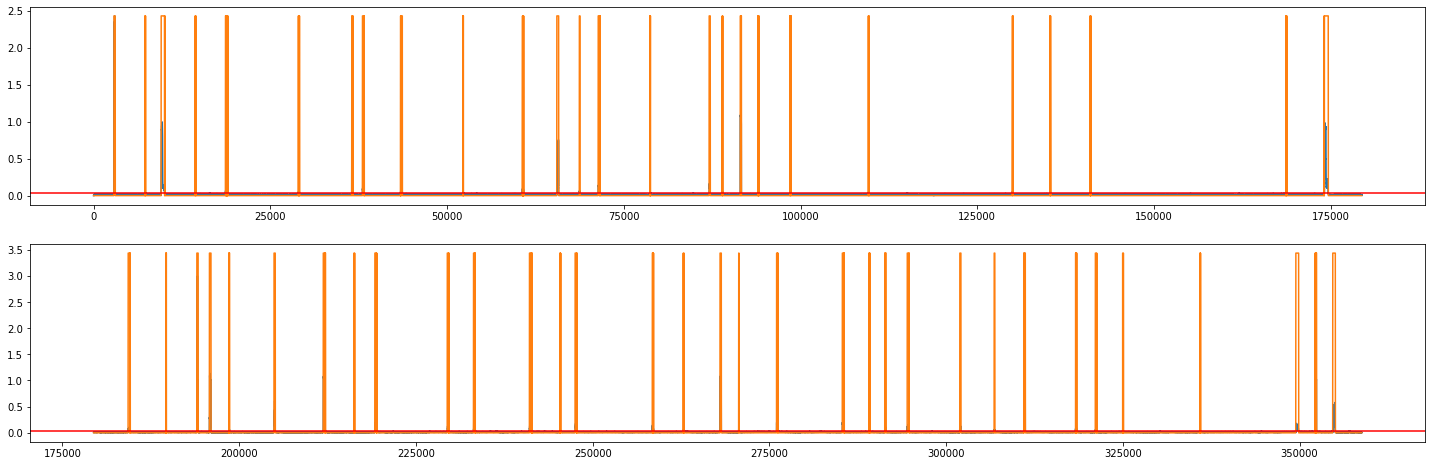

submission saved
epoch :  25
4987/4987 - 239s - loss: 4.1710e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  25   score :  0.9606471384799126322488804441
model save :  HAI_predict_2_3_epoch_25.h5


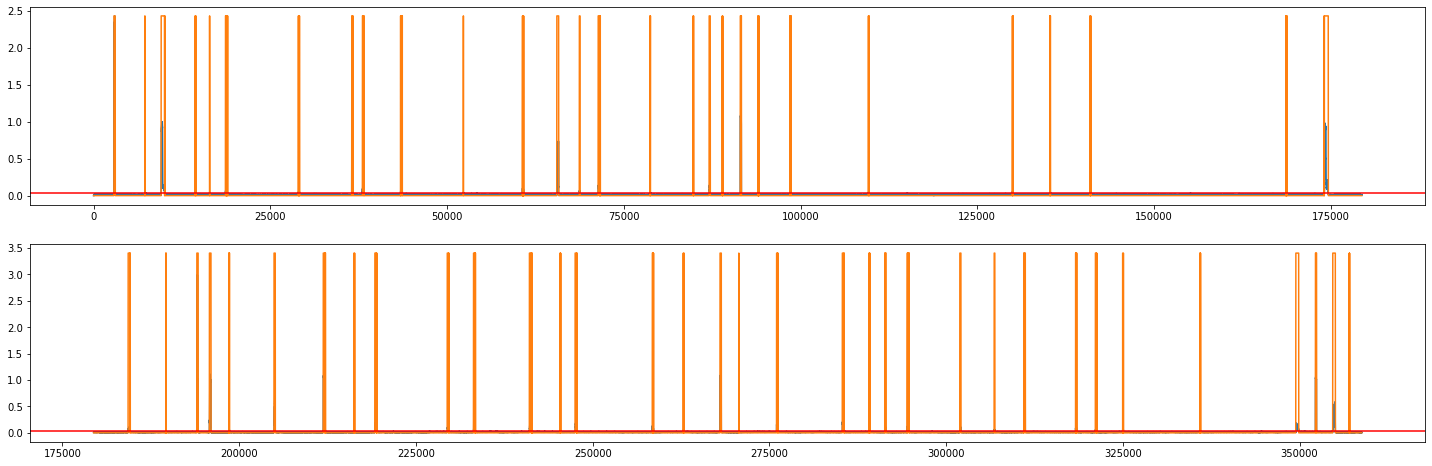

submission saved
epoch :  26
4987/4987 - 239s - loss: 4.1429e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  26   score :  0.9520756449589635193555735325
model save :  HAI_predict_2_3_epoch_26.h5


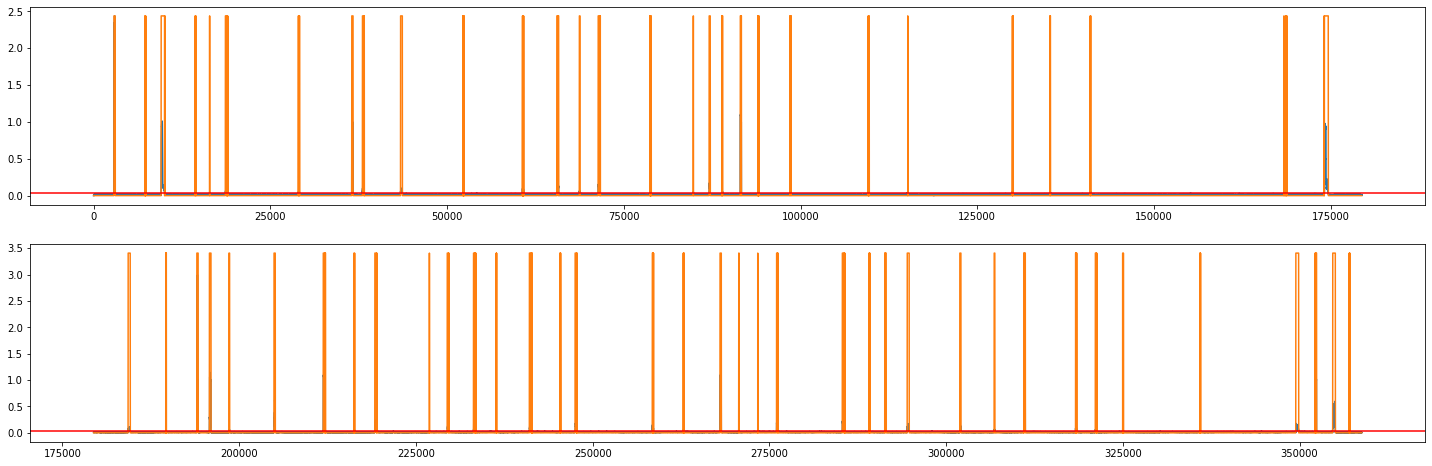

submission saved
epoch :  27
4987/4987 - 239s - loss: 4.1027e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_3   epoch :  27   score :  0.9566140738289277097274192511
model save :  HAI_predict_2_3_epoch_27.h5


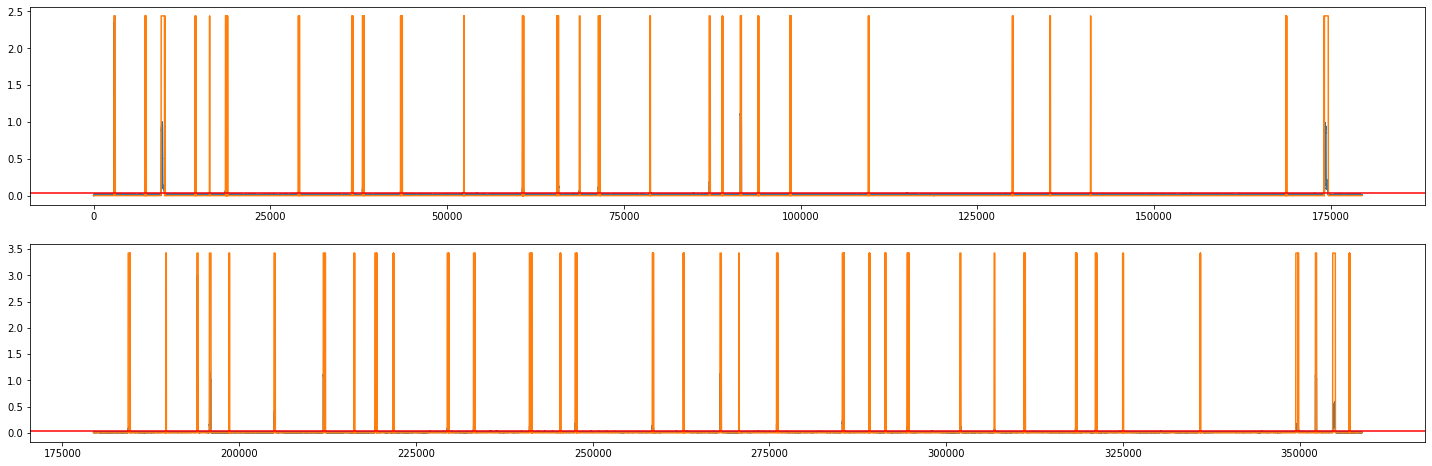

submission saved
epoch :  28
4987/4987 - 239s - loss: 4.0556e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9456967930846459083101428350
epoch :  29
4987/4987 - 240s - loss: 4.0454e-04
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_2_4
epoch :  0
4987/4987 - 213s - loss: 0.0061
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9031058260939839955104044152
epoch :  1
4987/4987 - 213s - loss: 0.0015
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9142389313696860347771801279
epoch :  2
4987/4987 - 212s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9064675825793414286868036427
epoch :  3
4987/4987 - 212s - loss: 8.7680e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9136415181794101677222810205
epoch :  4
4987/4987 - 212s - loss: 7.8137e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9213383933731544343480577016
epoch :  5
4987/4987 - 212s - loss: 7.3977e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9158381698081584526314585387
epoch :  6
4987/4987 - 212s - loss: 7.0031e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9401711130448927330114593526
epoch :  7
4987/4987 - 212s - loss: 6.4839e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  7   score :  0.9569877287932220429249182361
model save :  HAI_predict_2_4_epoch_7.h5


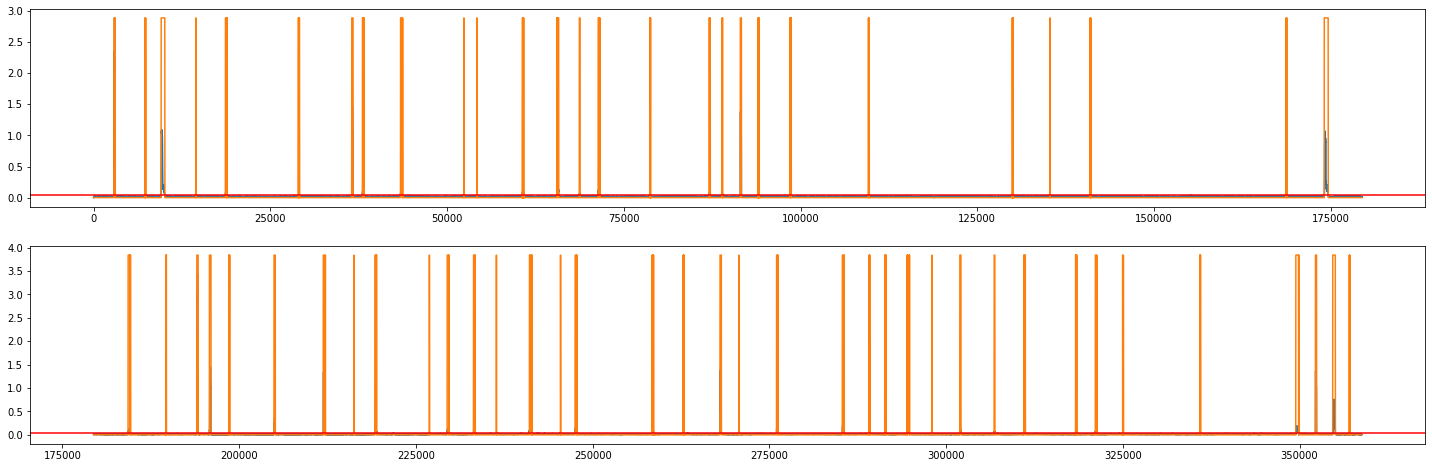

submission saved
epoch :  8
4987/4987 - 211s - loss: 6.2364e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9424104244451781551977450510
epoch :  9
4987/4987 - 212s - loss: 6.0576e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9424178500543899402310383130
epoch :  10
4987/4987 - 212s - loss: 5.7683e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9292634418177960495761194648
epoch :  11
4987/4987 - 212s - loss: 4.8615e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9373742254506617105465338674
epoch :  12
4987/4987 - 212s - loss: 4.6740e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  12   score :  0.9509294690459529530832377263
model save :  HAI_predict_2_4_epoch_12.h5


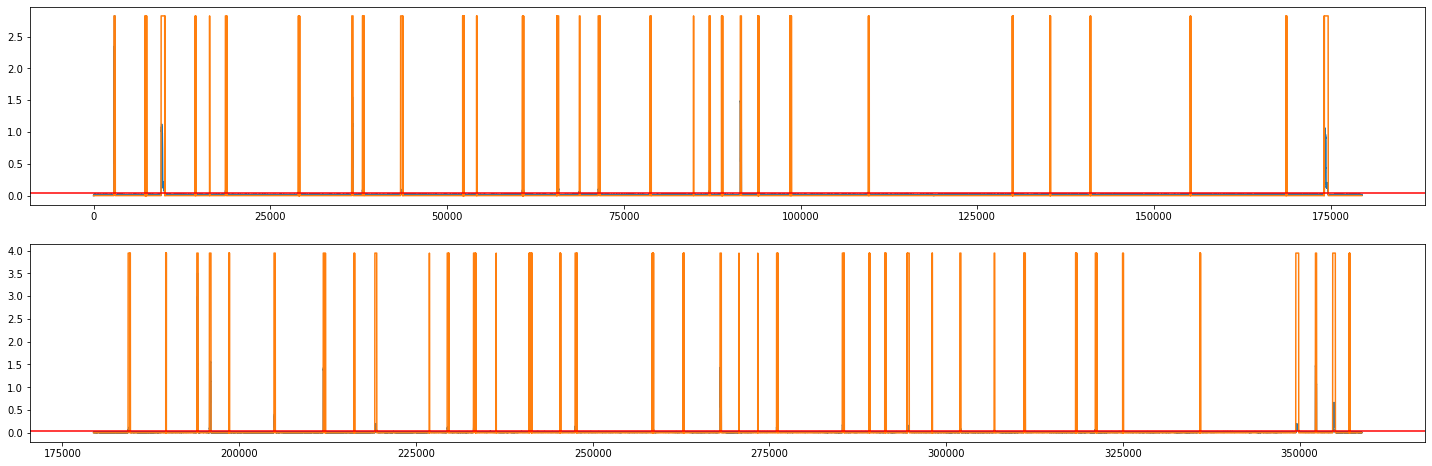

submission saved
epoch :  13
4987/4987 - 211s - loss: 4.6277e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9150714230846824359036702290
epoch :  14
4987/4987 - 212s - loss: 4.5124e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9417835038343839695948245541
epoch :  15
4987/4987 - 213s - loss: 4.4127e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9452767609447704943686564278
epoch :  16
4987/4987 - 212s - loss: 4.3726e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9255140153503350471180242214
epoch :  17
4987/4987 - 213s - loss: 4.3651e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9304057940535047069806737845
epoch :  18
4987/4987 - 212s - loss: 4.2981e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9372191961873315678928699754
epoch :  19
4987/4987 - 212s - loss: 4.2570e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9320467892773736786744543087
epoch :  20
4987/4987 - 212s - loss: 4.2204e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9315553812274216543070840271
epoch :  21
4987/4987 - 212s - loss: 4.1709e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9330700537099060260274426064
epoch :  22
4987/4987 - 212s - loss: 4.1822e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9335355838400770443132377514
epoch :  23
4987/4987 - 212s - loss: 4.1369e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9238518592112726380030017586
epoch :  24
4987/4987 - 212s - loss: 4.1188e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9241857371173431671783763455
epoch :  25
4987/4987 - 212s - loss: 4.0693e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9433963308673792451999562625
epoch :  26
4987/4987 - 213s - loss: 4.0533e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9309171127553569044912549670
epoch :  27
4987/4987 - 212s - loss: 4.0579e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9317016282873919397919566965
epoch :  28
4987/4987 - 212s - loss: 4.0161e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9418277558988327686943472064
epoch :  29
4987/4987 - 213s - loss: 3.9789e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9440773769681154632949869416
epoch :  30
4987/4987 - 213s - loss: 3.9473e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  30   score :  0.9554057844426551610998179717
model save :  HAI_predict_2_4_epoch_30.h5


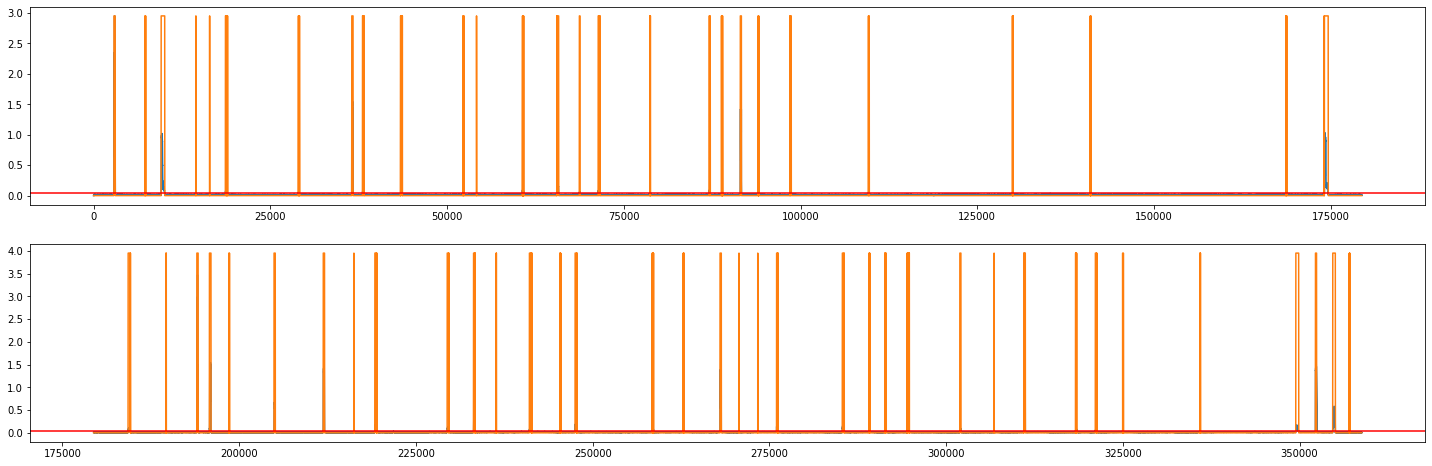

submission saved
epoch :  31
4987/4987 - 212s - loss: 3.9736e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9483038564182423955512265225
epoch :  32
4987/4987 - 213s - loss: 3.9211e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  32   score :  0.9624279145363120341640119850
model save :  HAI_predict_2_4_epoch_32.h5


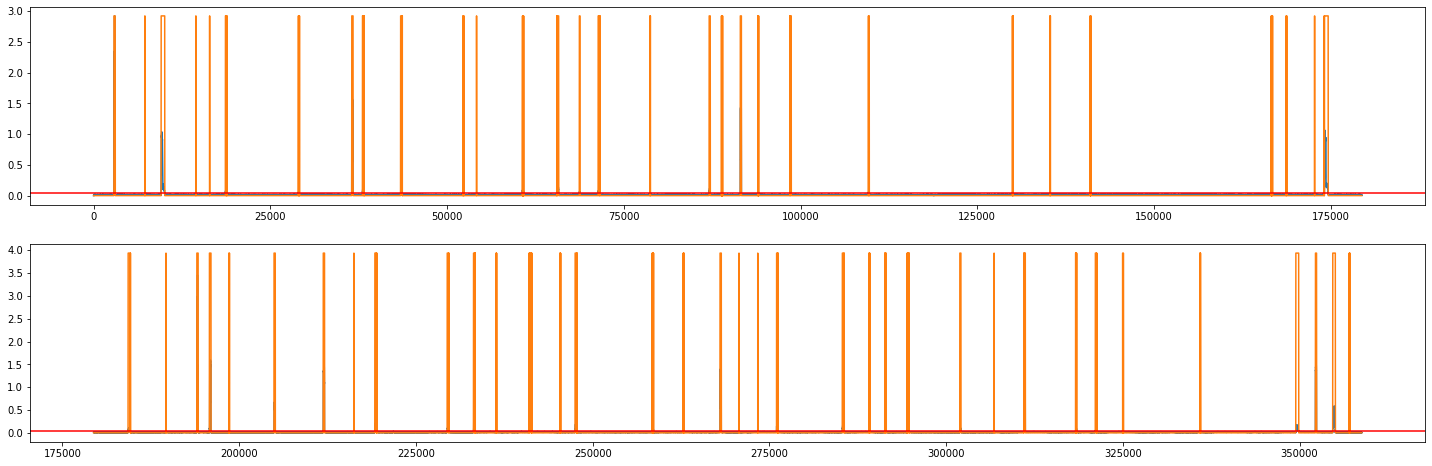

submission saved
epoch :  33
4987/4987 - 212s - loss: 3.9058e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  33   score :  0.9505638476300200232546111869
model save :  HAI_predict_2_4_epoch_33.h5


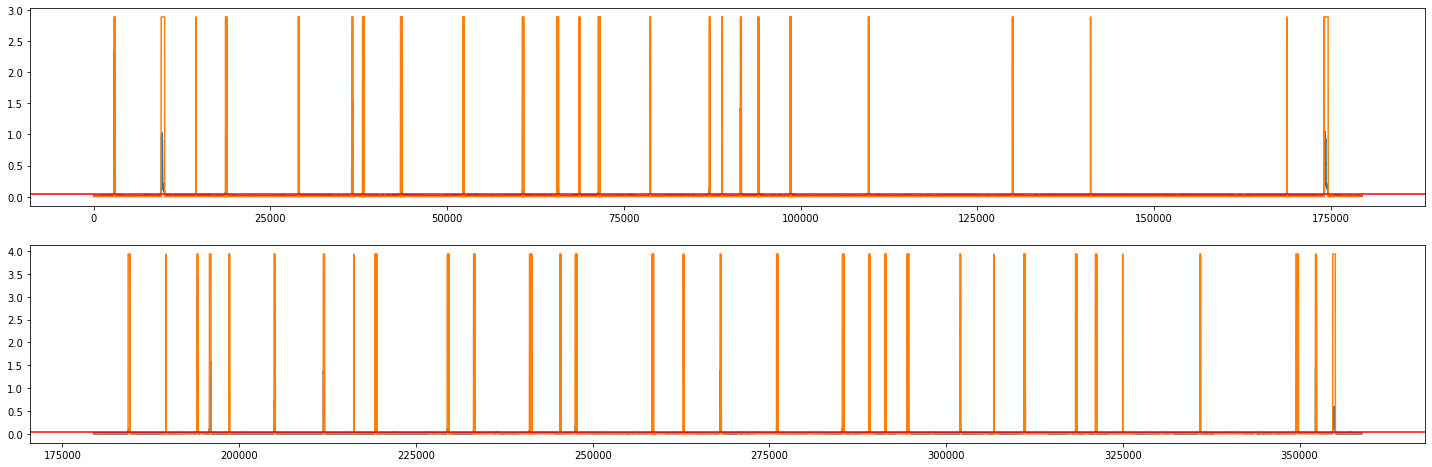

submission saved
epoch :  34
4987/4987 - 212s - loss: 3.8844e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_4   epoch :  34   score :  0.9653816132680846501525200037
model save :  HAI_predict_2_4_epoch_34.h5


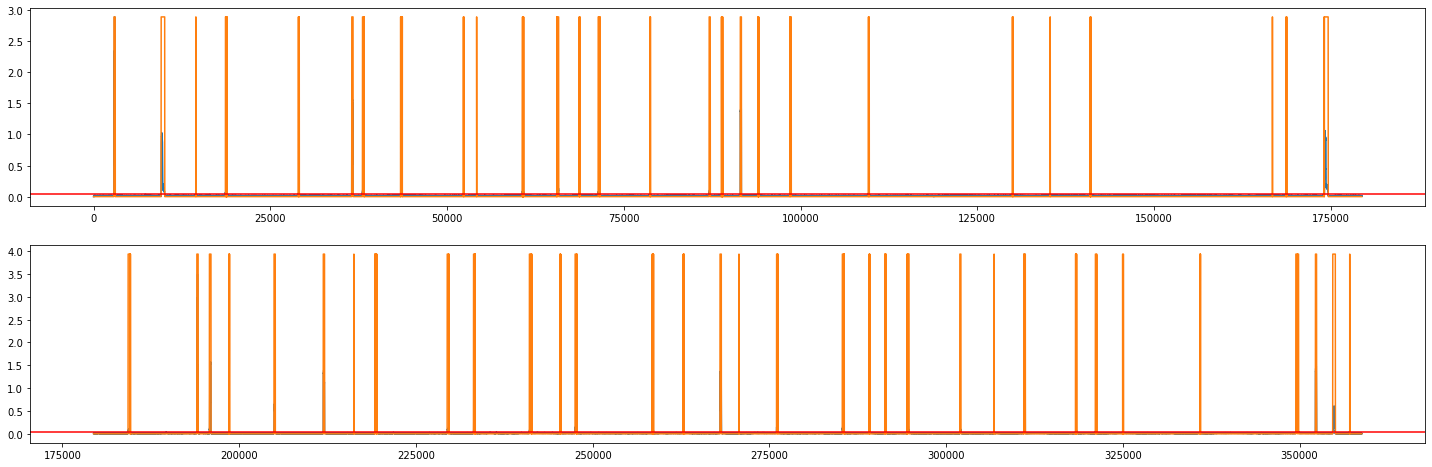

submission saved
epoch :  35
4987/4987 - 212s - loss: 3.9177e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9475516438008499126010734537
epoch :  36
4987/4987 - 213s - loss: 3.8519e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9481395850227461215140290791
epoch :  37
4987/4987 - 212s - loss: 3.8710e-04
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_2_5
epoch :  0
4987/4987 - 362s - loss: 0.0048
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9212895850378239256055035409
epoch :  1
4987/4987 - 362s - loss: 0.0013
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9194948463841940258191272890
epoch :  2
4987/4987 - 362s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9264444412763198909928528037
epoch :  3
4987/4987 - 362s - loss: 8.7212e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9175405542854091073933774423
epoch :  4
4987/4987 - 362s - loss: 7.8751e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9255563988548240004812738954
epoch :  5
4987/4987 - 362s - loss: 7.4129e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9192756787473901098618928281
epoch :  6
4987/4987 - 362s - loss: 7.0797e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9238604271062714101189424506
epoch :  7
4987/4987 - 362s - loss: 6.7841e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9341367919375085026824217570
epoch :  8
4987/4987 - 362s - loss: 6.5875e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9249042201556765961620292007
epoch :  9
4987/4987 - 362s - loss: 6.4465e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9199932635797810273167946566
epoch :  10
4987/4987 - 362s - loss: 6.3032e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9114336699048665813811307095
epoch :  11
4987/4987 - 362s - loss: 6.2034e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  11   score :  0.9509979827183455415509372586
model save :  HAI_predict_2_5_epoch_11.h5


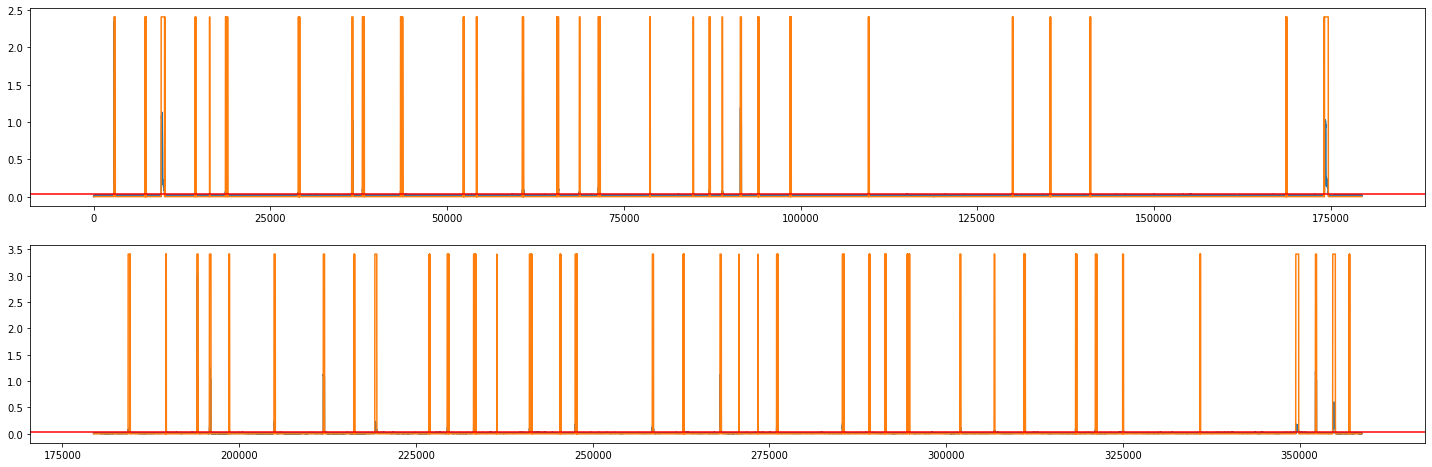

submission saved
epoch :  12
4987/4987 - 361s - loss: 6.0053e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  12   score :  0.9512660443561687473170365875
model save :  HAI_predict_2_5_epoch_12.h5


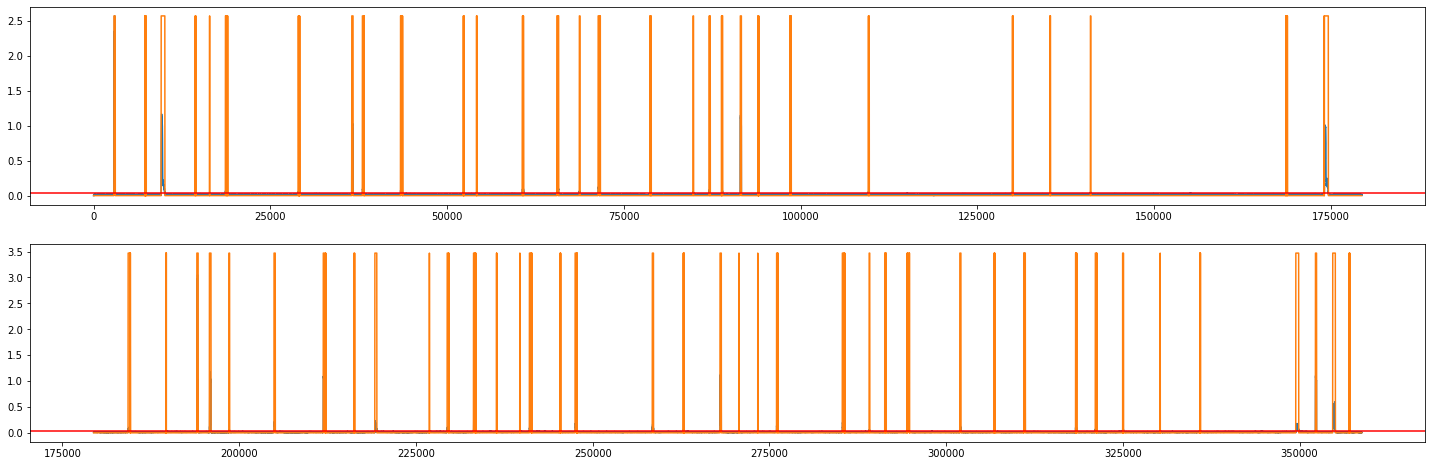

submission saved
epoch :  13
4987/4987 - 361s - loss: 5.9325e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  13   score :  0.9605324000629622686021214999
model save :  HAI_predict_2_5_epoch_13.h5


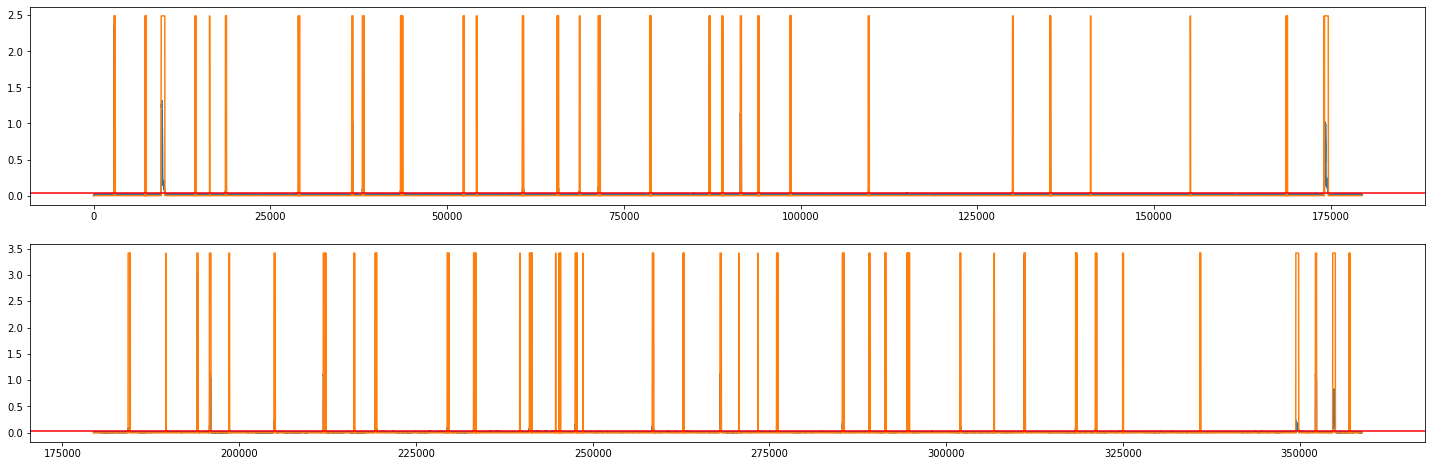

submission saved
epoch :  14
4987/4987 - 361s - loss: 5.8484e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  14   score :  0.9556202330008280197043028122
model save :  HAI_predict_2_5_epoch_14.h5


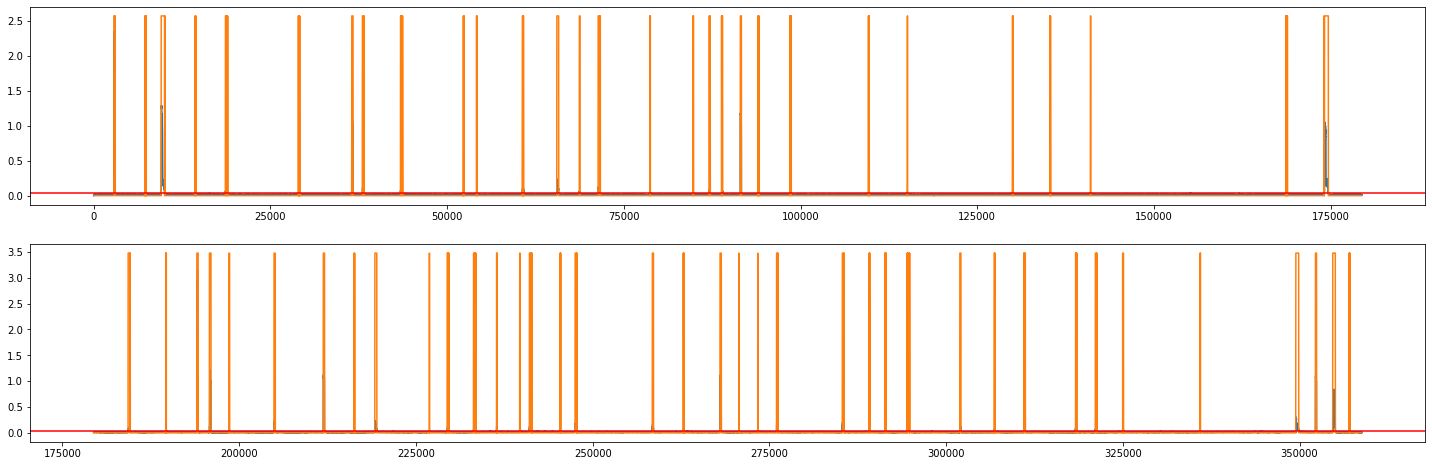

submission saved
epoch :  15
4987/4987 - 361s - loss: 5.7992e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  15   score :  0.9730075045623212375778752358
model save :  HAI_predict_2_5_epoch_15.h5


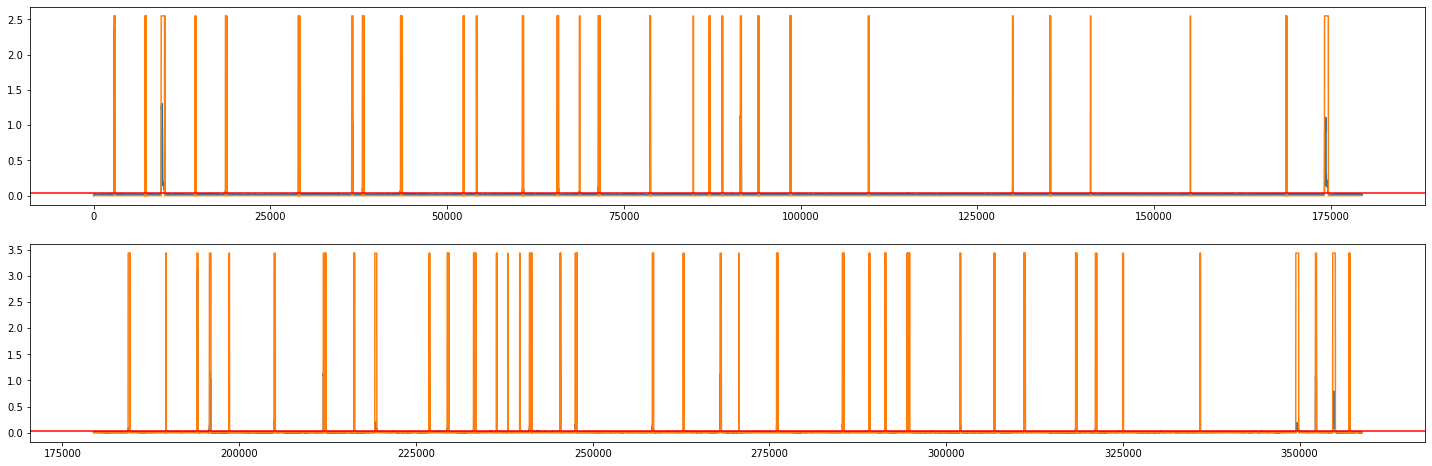

submission saved
epoch :  16
4987/4987 - 361s - loss: 5.7033e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9358802737205425337328014414
epoch :  17
4987/4987 - 362s - loss: 5.6975e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_2_5   epoch :  17   score :  0.9529788283748085845804212501
model save :  HAI_predict_2_5_epoch_17.h5


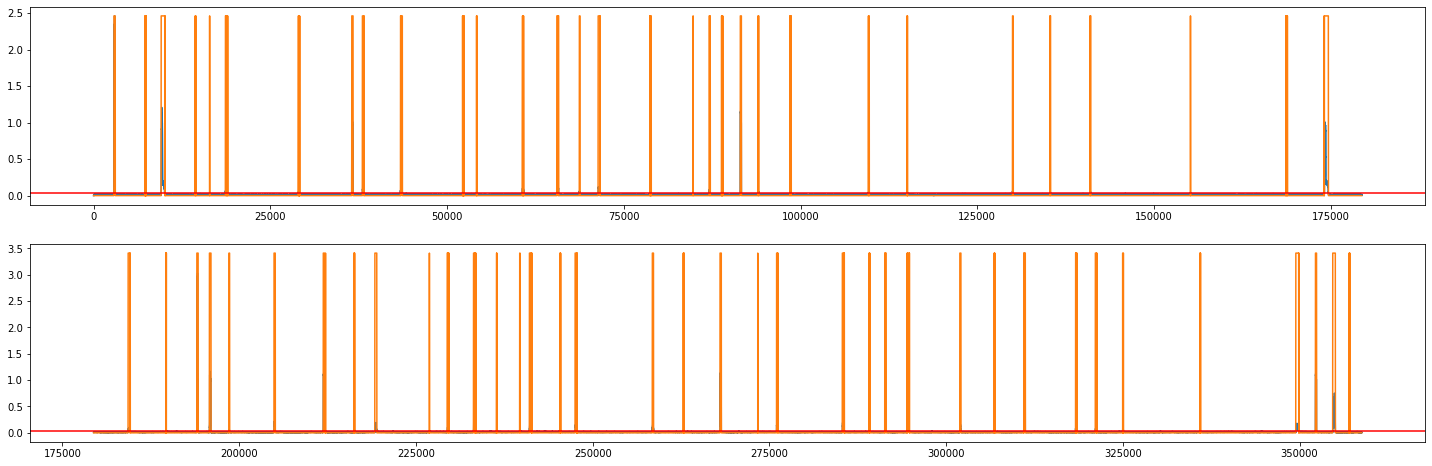

submission saved
epoch :  18
4987/4987 - 361s - loss: 4.9100e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9486703552753456626717843239
epoch :  19
4987/4987 - 362s - loss: 4.5448e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9189433878840123200373271531
epoch :  20
4987/4987 - 362s - loss: 4.4926e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9088573178558199214125722623
epoch :  21
4987/4987 - 362s - loss: 4.4280e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9351247135971846745770184901
epoch :  22
4987/4987 - 362s - loss: 4.4204e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9357023155465491263514630197
epoch :  23
4987/4987 - 362s - loss: 4.3658e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9355866677149749997599606104
epoch :  24
4987/4987 - 362s - loss: 4.2937e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9283000490583664300228287952
epoch :  25
4987/4987 - 363s - loss: 4.3360e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8949617814494486711086637351
epoch :  26
4987/4987 - 362s - loss: 4.2790e-04
checking for TaPR...


Progress:[==============================] 100.0%

Starting to train  HAI_predict_2_6
epoch :  0
4987/4987 - 486s - loss: 0.0073
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9288842422437002265074034654
epoch :  1


KeyboardInterrupt: ignored

In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if e > 25 and score < 0.93:
                break
            elif score < 0.95:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')


generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Test3 : Attention
--------

In [ ]:
Modelname = 'HAI_predict_3'

In [ ]:
def model0():                                   # 4skip, 3layer (test2 의 model6, keyboard interrupt 로 끊었었음)
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    mid = layers.Add()([inp,mid])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model1():                                   # 1layer, 1attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.LSTM(79, return_sequences=True)(inp)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([mid, att])
    out= layers.LSTM(79, return_sequences=False)(mid)
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model2():                                   # 2layer, 1attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.LSTM(100, return_sequences=True)(inp)
    mid = layers.LSTM(100, return_sequences=True)(mid)
    att = layers.Attention()([layers.Dense(100)(mid), layers.Dense(100)(mid), layers.Dense(100)(mid)])
    mid = layers.Add()([mid, att])
    mid = layers.LSTM(100, return_sequences=True)(mid)
    out= layers.LSTM(79, return_sequences=False)(mid)
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model3():                                   # 1skip, 1layer, 1attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.LSTM(100, return_sequences=True)(inp)
    att = layers.Attention()([layers.Dense(100)(mid), layers.Dense(100)(mid), layers.Dense(100)(mid)])
    mid = layers.Add()([mid, att])
    mid = layers.LSTM(79, return_sequences=False)(mid)
    out = layers.Add()([inp[:,0,:],mid])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model4():                                   # 2skip, 2layer, 2attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:],mid, att2])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model5():                                   # 2skip, 3layer, 2attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att2])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model6():                                   # 3skip, 2layer, 3attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att2])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att3 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att3])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model7():                                   # 3skip, 3layer, 3attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att2])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att3 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att3])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

def model8():                                   # 4skip, 3layer, 4attention
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(inp)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att2 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att2])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att3 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att3])
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid = layers.Bidirectional(layers.LSTM(100, return_sequences=True))(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att4 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att4])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model


models = [model0(), model1(), model2(), model3(), model4(), model5(), model6(), model7(), model8()]
Modelnames = [Modelname + '_' + str(i) for i in range(len(models))]

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 100, 200)     144000      input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_37 (Bidirectional (None, 100, 200)     240800      bidirectional_36[0][0]           
__________________________________________________________________________________________________
bidirectional_38 (Bidirectional [(None, 100, 79), (N 176960      bidirectional_37[0][0]           
_______________________________________________________________________________________

Starting to train  HAI_predict_3_0
epoch :  0
4987/4987 - 468s - loss: 0.0049
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9248259332699977251400286537
epoch :  1
4987/4987 - 469s - loss: 0.0013
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9166695892024280921207661158
epoch :  2
4987/4987 - 471s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8883308313423314693726346629
epoch :  3
4987/4987 - 468s - loss: 8.5980e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9156631518540772129621777093
epoch :  4
4987/4987 - 464s - loss: 7.6916e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9182711681364660723308996857
epoch :  5
4987/4987 - 468s - loss: 7.1225e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8961902782510594795351793095
epoch :  6
4987/4987 - 471s - loss: 6.8136e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9192330472837154969359920643
epoch :  7
4987/4987 - 467s - loss: 6.6875e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8768420536882541449763604741
epoch :  8
4987/4987 - 469s - loss: 6.1794e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8952280426227083807041989373
epoch :  9
4987/4987 - 465s - loss: 5.4538e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9036399643779875638855946729
epoch :  10
4987/4987 - 461s - loss: 5.1130e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9326929199192437894434469807
epoch :  11
4987/4987 - 464s - loss: 4.9167e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9492699169635742207969647173
epoch :  12
4987/4987 - 476s - loss: 4.8156e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9382118397137873376053357185
epoch :  13
4987/4987 - 469s - loss: 4.7200e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9317669237605200825384987857
epoch :  14
4987/4987 - 473s - loss: 4.6774e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9435126973791328438721033892
epoch :  15
4987/4987 - 471s - loss: 4.5685e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9443343373631754404448946336
epoch :  16
4987/4987 - 465s - loss: 4.4819e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9476269061909374925036551815
epoch :  17
4987/4987 - 466s - loss: 4.5114e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9359697101767146498744135011
epoch :  18
4987/4987 - 457s - loss: 4.4064e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9305091441411552349843432336
epoch :  19
4987/4987 - 457s - loss: 4.3831e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_0   epoch :  19   score :  0.9528543059046483789872577305   TH_ :  0.0388
model save :  HAI_predict_3_0_epoch_19.h5


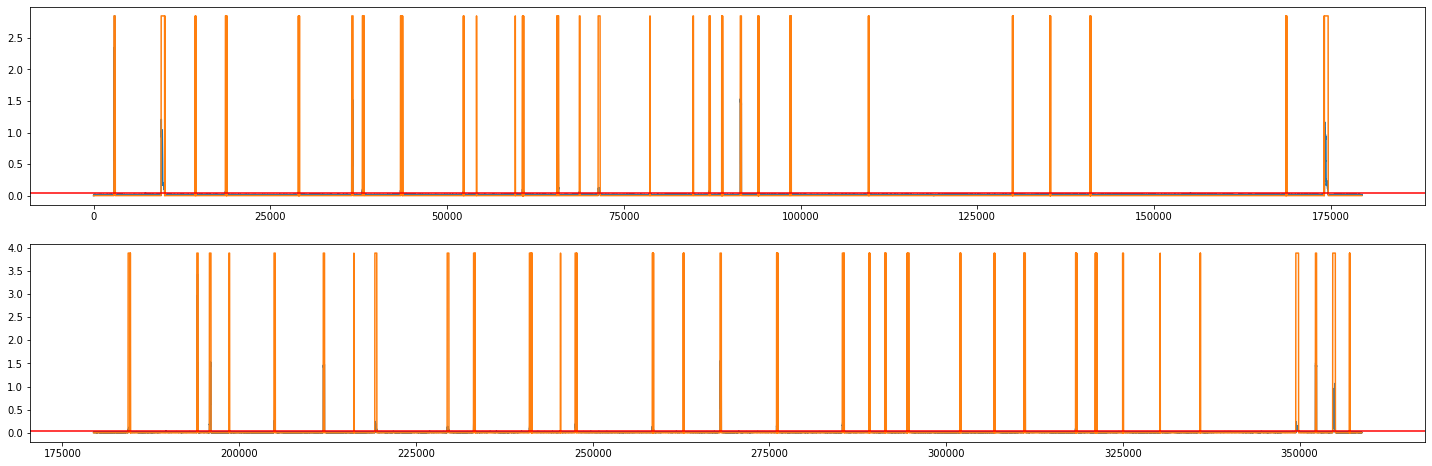

submission saved
epoch :  20
4987/4987 - 459s - loss: 4.3636e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9364195900290170325804481259
epoch :  21
4987/4987 - 459s - loss: 4.2820e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_0   epoch :  21   score :  0.9528018971722085768713853223   TH_ :  0.0397
model save :  HAI_predict_3_0_epoch_21.h5


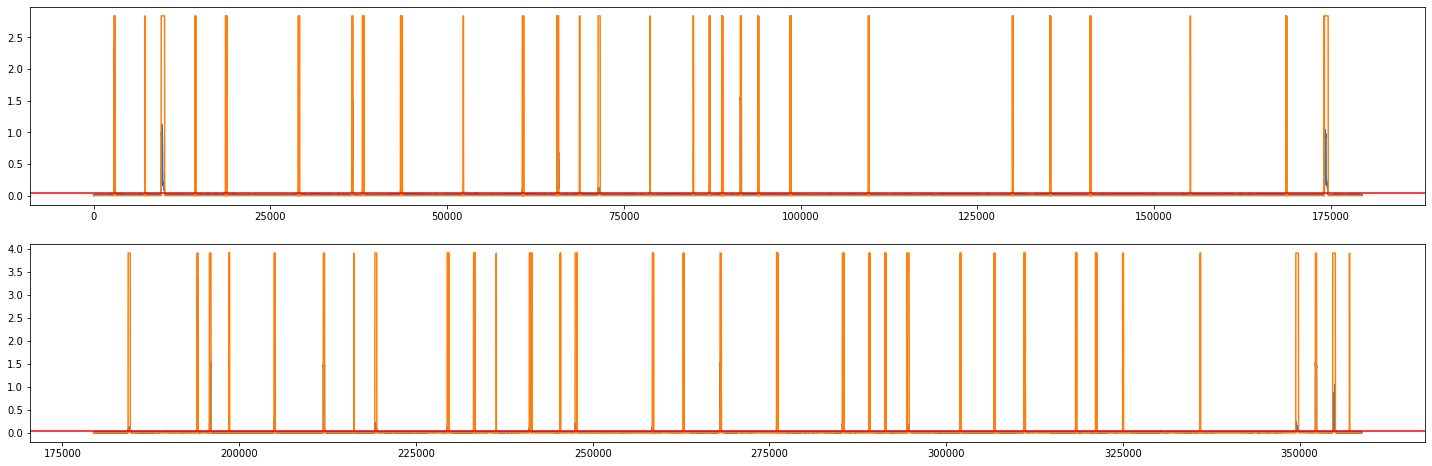

submission saved
epoch :  22
4987/4987 - 460s - loss: 4.2633e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_0   epoch :  22   score :  0.9653743635229861776173730517   TH_ :  0.0379
model save :  HAI_predict_3_0_epoch_22.h5


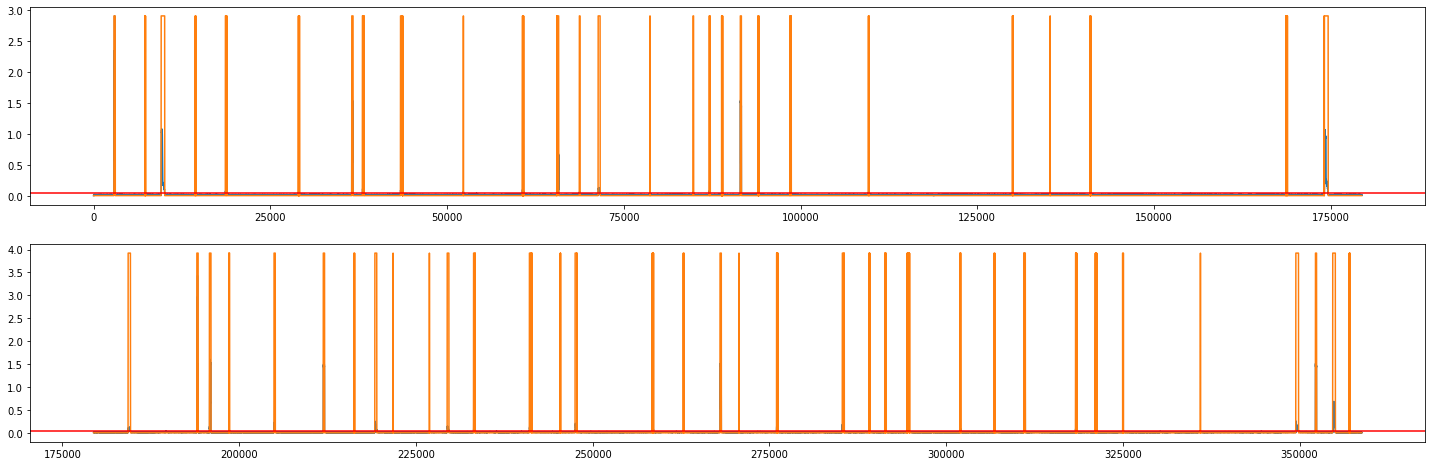

submission saved
epoch :  23
4987/4987 - 459s - loss: 4.1786e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9213182633739963234944064766
epoch :  24
4987/4987 - 462s - loss: 4.3679e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9330650502277833540083934995
epoch :  25
4987/4987 - 462s - loss: 4.1596e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_0   epoch :  25   score :  0.9628980354858976414047491461   TH_ :  0.0379
model save :  HAI_predict_3_0_epoch_25.h5


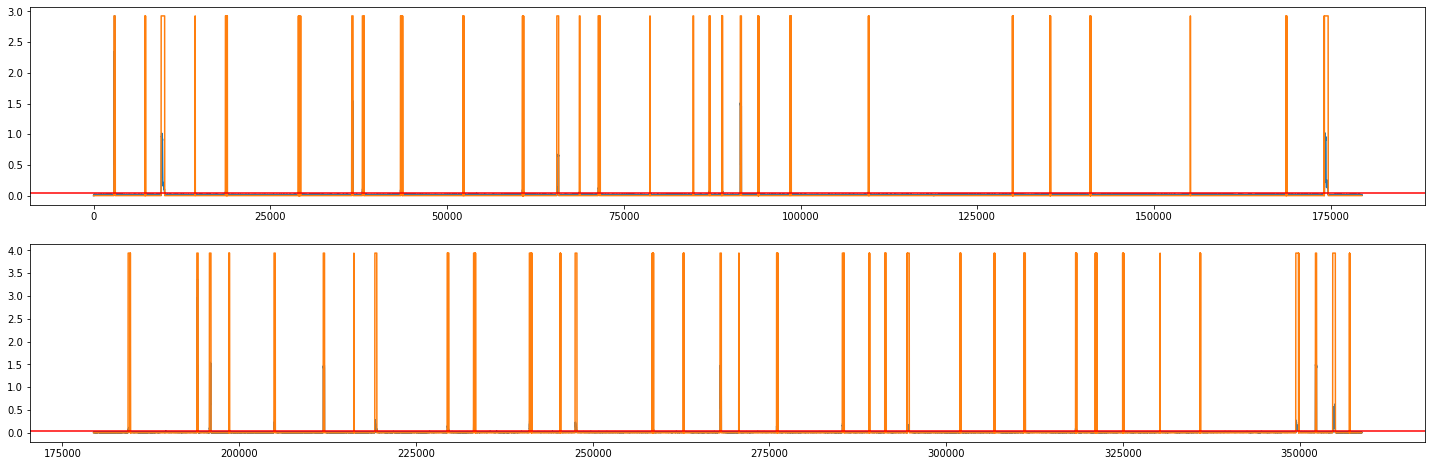

submission saved
epoch :  26
4987/4987 - 461s - loss: 4.1563e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9412476336089859210257845827
epoch :  27
4987/4987 - 459s - loss: 4.1290e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9459509944874893838785010700
epoch :  28
4987/4987 - 460s - loss: 4.0698e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9363386189493850107732448067
epoch :  29
4987/4987 - 463s - loss: 4.0864e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9314985347202325681450303867
epoch :  30
4987/4987 - 465s - loss: 4.0367e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_1
epoch :  0
4987/4987 - 54s - loss: 0.0025
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7850317954057182615138556299
epoch :  1
4987/4987 - 54s - loss: 6.9464e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7823012759714049305233866066
epoch :  2
4987/4987 - 55s - loss: 5.9773e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7885881470563924158496220242
epoch :  3
4987/4987 - 55s - loss: 5.4593e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7861442372365090425858661624
epoch :  4
4987/4987 - 55s - loss: 5.2414e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7698014069904767376272757796
epoch :  5
4987/4987 - 55s - loss: 4.9335e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7780579424606942819055208420
epoch :  6
4987/4987 - 55s - loss: 4.7837e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7312513896635522204452556164
epoch :  7
4987/4987 - 53s - loss: 4.7834e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7347647123023779236920384965
epoch :  8
4987/4987 - 54s - loss: 4.5541e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6835642683664177525858383111
epoch :  9
4987/4987 - 52s - loss: 4.4774e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7718649824651884417082075217
epoch :  10
4987/4987 - 52s - loss: 4.4102e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7835047238692120512110627020
epoch :  11
4987/4987 - 52s - loss: 4.7328e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7805190041282638912105537463
epoch :  12
4987/4987 - 52s - loss: 4.2813e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7861326893615839163203830211
epoch :  13
4987/4987 - 53s - loss: 4.2654e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7857576062208199601970990397
epoch :  14
4987/4987 - 52s - loss: 4.1966e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7925750388780253204692285571
epoch :  15
4987/4987 - 53s - loss: 4.1914e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8025958675085045890158168275
epoch :  16
4987/4987 - 52s - loss: 4.1645e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7927944088506147382259913675
epoch :  17
4987/4987 - 53s - loss: 5.7302e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7899376252670717447538334691
epoch :  18
4987/4987 - 53s - loss: 4.0912e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7916006448078395422402890955
epoch :  19
4987/4987 - 53s - loss: 4.1282e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7922065289350481586850668598
epoch :  20
4987/4987 - 52s - loss: 4.0790e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7747588568999446926699231932
epoch :  21
4987/4987 - 52s - loss: 4.0669e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7836674197449263247582905309
epoch :  22
4987/4987 - 54s - loss: 4.1401e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7816012828197983476585761333
epoch :  23
4987/4987 - 52s - loss: 4.0143e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7666862390999831929338858644
epoch :  24
4987/4987 - 52s - loss: 4.0157e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7809725908664129292077453170
epoch :  25
4987/4987 - 52s - loss: 3.9617e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7674374725389254417343215463
epoch :  26
4987/4987 - 53s - loss: 3.9663e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_2
epoch :  0
4987/4987 - 97s - loss: 0.0033
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8018312305119150895605946917
epoch :  1
4987/4987 - 97s - loss: 7.2004e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8044546757625175371526011231
epoch :  2
4987/4987 - 97s - loss: 6.0190e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8157577794805740268644713363
epoch :  3
4987/4987 - 97s - loss: 5.5179e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8627666518431430934882645178
epoch :  4
4987/4987 - 97s - loss: 5.0954e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8674429302302574961868571256
epoch :  5
4987/4987 - 97s - loss: 4.9277e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8437567023360565360154041526
epoch :  6
4987/4987 - 97s - loss: 4.9717e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8533705066471239266930550123
epoch :  7
4987/4987 - 96s - loss: 4.8119e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8257359253881931682964555299
epoch :  8
4987/4987 - 96s - loss: 4.8375e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8139456558572379297842615237
epoch :  9
4987/4987 - 96s - loss: 4.6753e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8130074260822581176993110870
epoch :  10
4987/4987 - 96s - loss: 4.5452e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8084960027983960900591746447
epoch :  11
4987/4987 - 96s - loss: 4.5508e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8613610328372500125459177367
epoch :  12
4987/4987 - 96s - loss: 4.5400e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8041651573444517208267169894
epoch :  13
4987/4987 - 97s - loss: 4.3668e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8132092293222948620482875926
epoch :  14
4987/4987 - 96s - loss: 4.3926e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7849963689394963048460929453
epoch :  15
4987/4987 - 96s - loss: 4.6526e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8166345168794684967530341791
epoch :  16
4987/4987 - 96s - loss: 4.3047e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8147106220238400991710761971
epoch :  17
4987/4987 - 96s - loss: 4.3454e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8073287704121680759616410942
epoch :  18
4987/4987 - 96s - loss: 4.3284e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8254068703356694978781980453
epoch :  19
4987/4987 - 96s - loss: 4.2104e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8142147619789708421161562412
epoch :  20
4987/4987 - 95s - loss: 4.3326e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8058655871343574280156943444
epoch :  21
4987/4987 - 95s - loss: 4.1526e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8103278808393715364287063004
epoch :  22
4987/4987 - 95s - loss: 4.1720e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.4788996372212329749274155153
epoch :  23
4987/4987 - 95s - loss: 4.6235e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8020714641422766152957143992
epoch :  24
4987/4987 - 94s - loss: 4.1538e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8220051786622636688570168886
epoch :  25
4987/4987 - 95s - loss: 4.0830e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8057712564685557221574741387
epoch :  26
4987/4987 - 94s - loss: 5.5187e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_3
epoch :  0
4987/4987 - 52s - loss: 0.0023
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8882498536905790802399139601
epoch :  1
4987/4987 - 52s - loss: 8.3140e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8871016435976520969724219702
epoch :  2
4987/4987 - 52s - loss: 6.9227e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8998942291937855053880408716
epoch :  3
4987/4987 - 52s - loss: 6.2422e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8996970462479578624514070504
epoch :  4
4987/4987 - 52s - loss: 5.8845e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9066633933690859987174609727
epoch :  5
4987/4987 - 52s - loss: 5.4706e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9293712874559419113670584370
epoch :  6
4987/4987 - 52s - loss: 5.1946e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_3   epoch :  6   score :  0.9526584041329486128249250215   TH_ :  0.034300000000000004
model save :  HAI_predict_3_3_epoch_6.h5


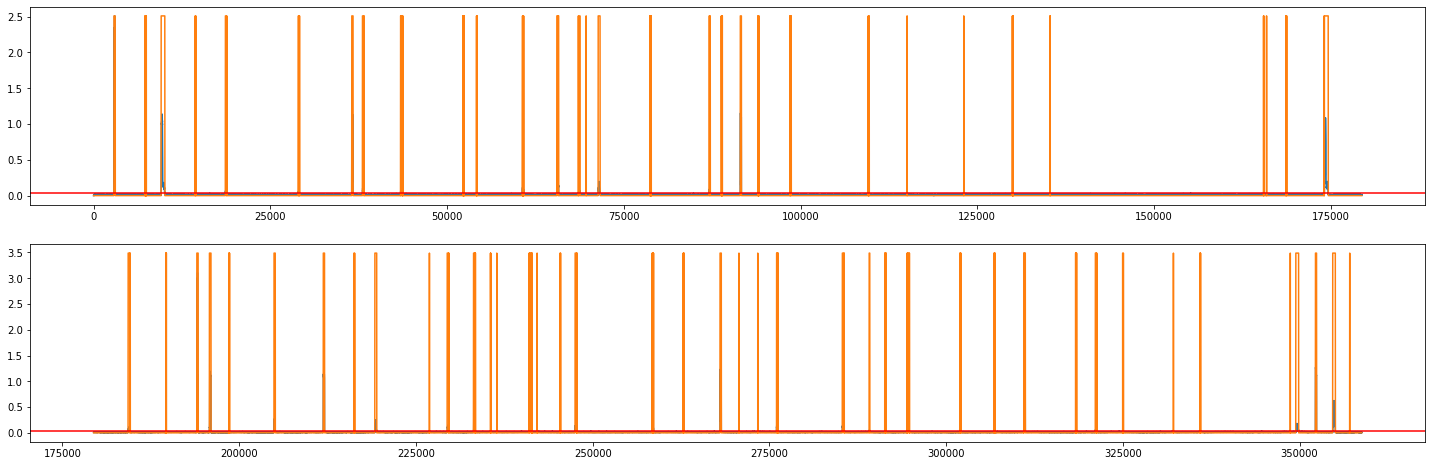

submission saved
epoch :  7
4987/4987 - 52s - loss: 5.0429e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_3   epoch :  7   score :  0.9682698263236094772595508880   TH_ :  0.033400000000000006
model save :  HAI_predict_3_3_epoch_7.h5


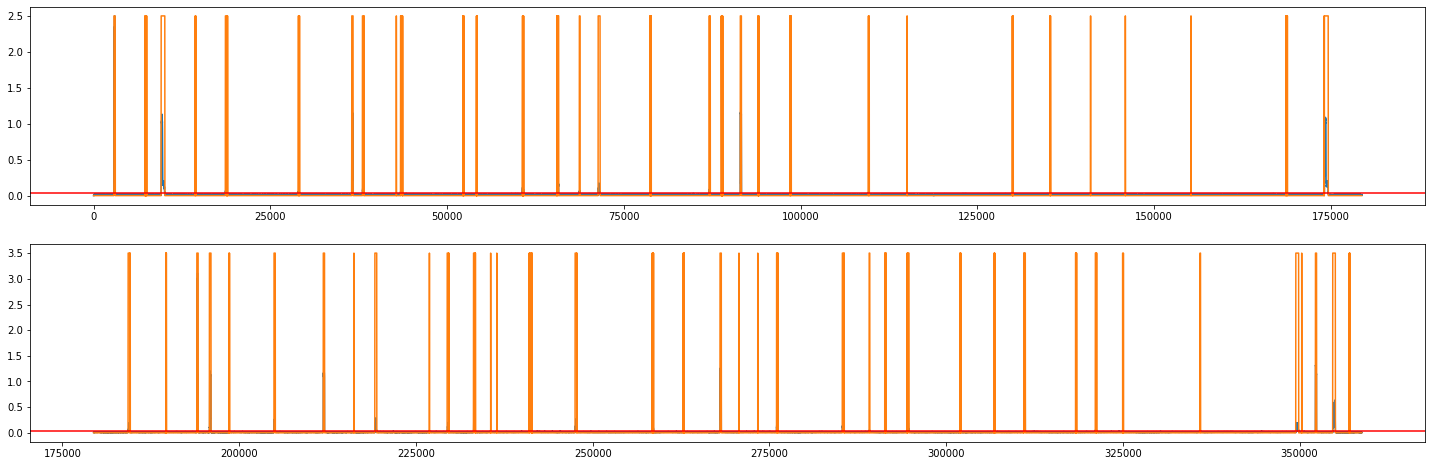

submission saved
epoch :  8
4987/4987 - 52s - loss: 4.9401e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9451967481171172910526146432
epoch :  9
4987/4987 - 52s - loss: 4.8390e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_3   epoch :  9   score :  0.9555190704762321008987474776   TH_ :  0.03250000000000001
model save :  HAI_predict_3_3_epoch_9.h5


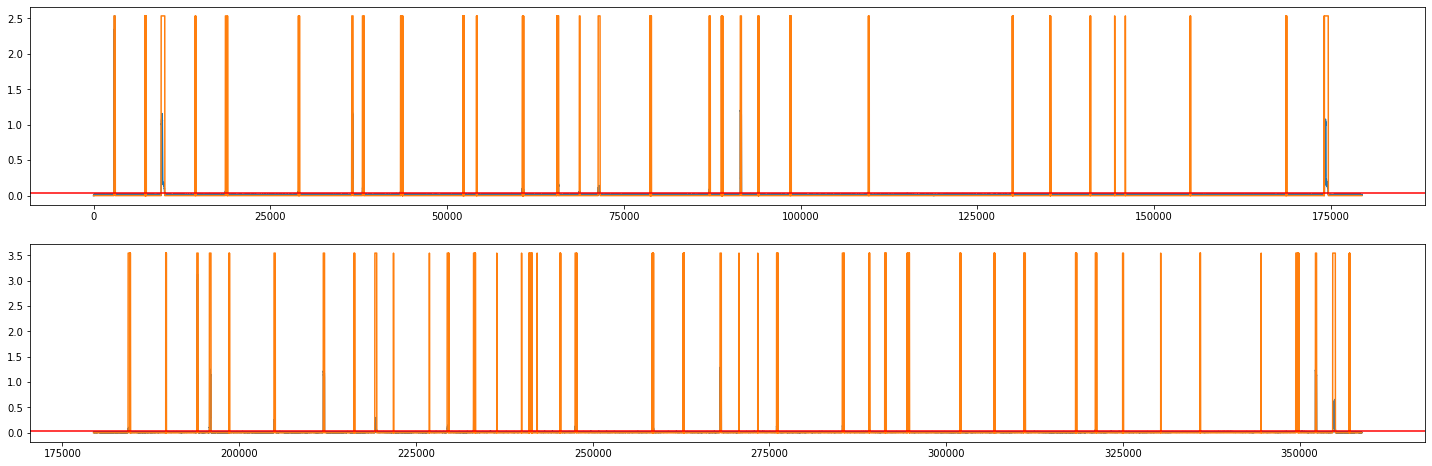

submission saved
epoch :  10
4987/4987 - 52s - loss: 4.8061e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9475920908130812669748610362
epoch :  11
4987/4987 - 51s - loss: 4.7333e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9181232356372945693563371065
epoch :  12
4987/4987 - 52s - loss: 4.7198e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_3   epoch :  12   score :  0.9646439865368941004705736189   TH_ :  0.0316
model save :  HAI_predict_3_3_epoch_12.h5


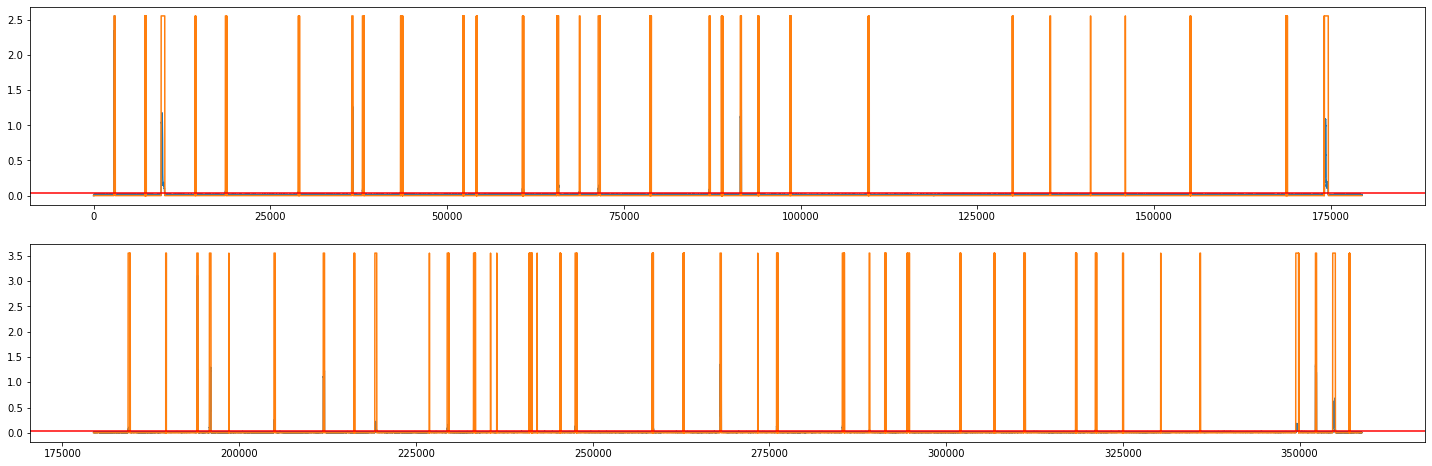

submission saved
epoch :  13
4987/4987 - 51s - loss: 4.6110e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_3   epoch :  13   score :  0.9513159453850313390618479809   TH_ :  0.033400000000000006
model save :  HAI_predict_3_3_epoch_13.h5


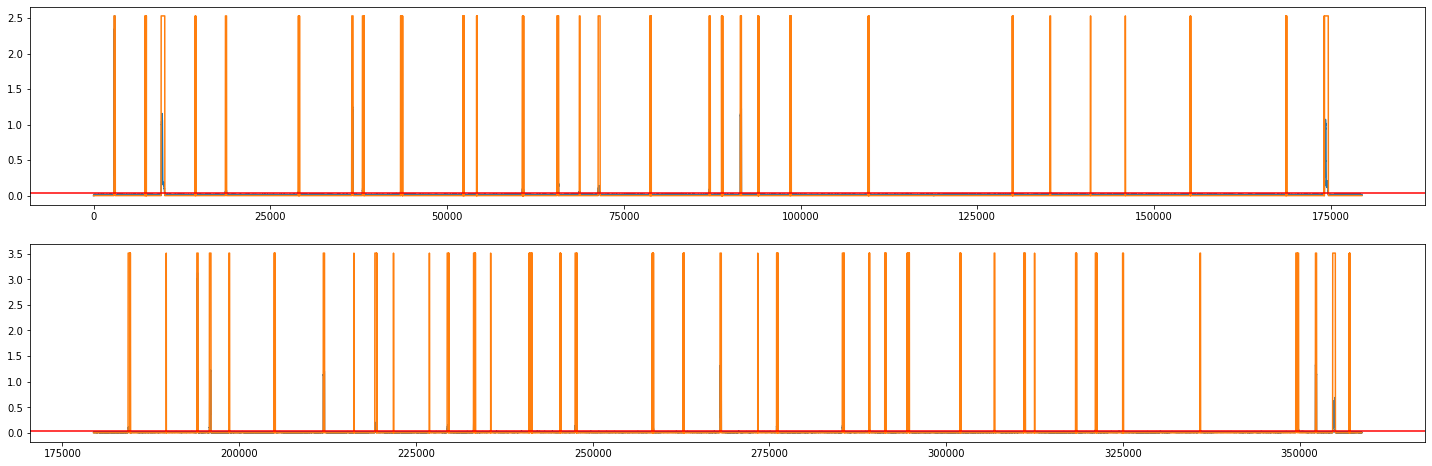

submission saved
epoch :  14
4987/4987 - 51s - loss: 4.6090e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9007010613451132330207841581
epoch :  15
4987/4987 - 51s - loss: 4.5484e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8517658138189825271402976907
epoch :  16
4987/4987 - 51s - loss: 4.5321e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9263846946512106900383756415
epoch :  17
4987/4987 - 51s - loss: 4.4866e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9430645843151575664249280284
epoch :  18
4987/4987 - 51s - loss: 4.4599e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9435762427915242935221203237
epoch :  19
4987/4987 - 52s - loss: 4.3800e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9377403882737483163445976842
epoch :  20
4987/4987 - 51s - loss: 4.4300e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9497595740919963034572319936
epoch :  21
4987/4987 - 51s - loss: 4.3982e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9420845513733647382505500607
epoch :  22
4987/4987 - 51s - loss: 4.3358e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9202678100093209652325758891
epoch :  23
4987/4987 - 52s - loss: 4.4215e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8488056424692975734018945568
epoch :  24
4987/4987 - 51s - loss: 4.3386e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9220267308349594277777332071
epoch :  25
4987/4987 - 51s - loss: 4.2898e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9290983853209889578251324125
epoch :  26
4987/4987 - 51s - loss: 4.2625e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9446050140236880105261077801
epoch :  27
4987/4987 - 52s - loss: 4.2487e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_4
epoch :  0
4987/4987 - 139s - loss: 0.0026
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9140126228651789874165808398
epoch :  1
4987/4987 - 140s - loss: 0.0010
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8650065186316895810478298243
epoch :  2
4987/4987 - 140s - loss: 8.0492e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9269756248476873819389312341
epoch :  3
4987/4987 - 141s - loss: 6.7961e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9380854908461215801405478909
epoch :  4
4987/4987 - 140s - loss: 5.6811e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9426297972705492679711844473
epoch :  5
4987/4987 - 140s - loss: 5.2903e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  5   score :  0.9665686343839688710813112985   TH_ :  0.0442
model save :  HAI_predict_3_4_epoch_5.h5


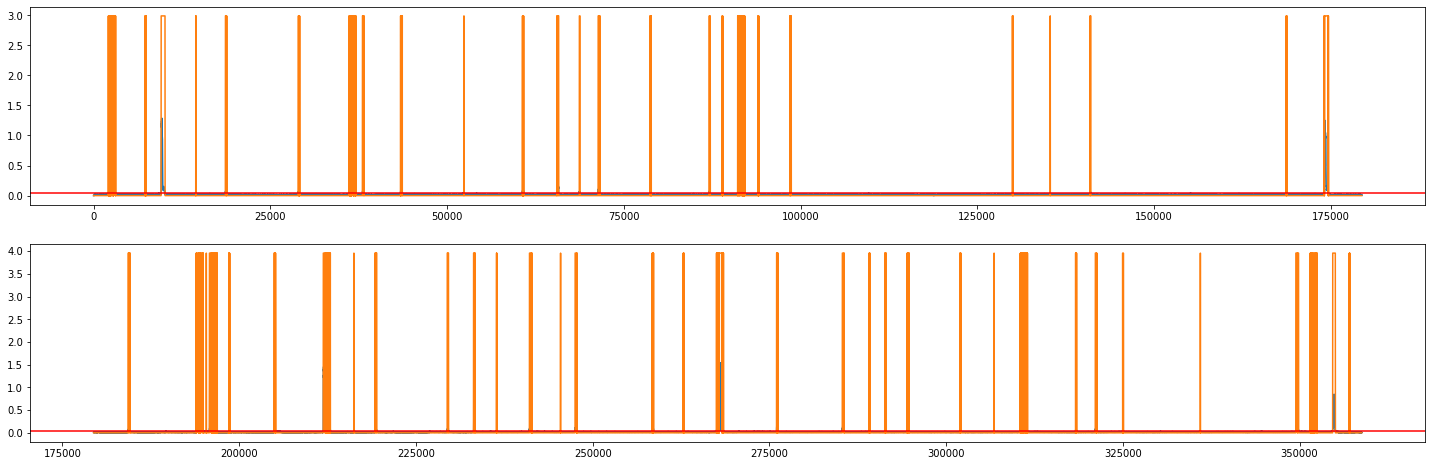

submission saved
epoch :  6
4987/4987 - 140s - loss: 5.1825e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9352608071019582323472355567
epoch :  7
4987/4987 - 141s - loss: 4.9802e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  7   score :  0.9671484334701230081365143746   TH_ :  0.0397
model save :  HAI_predict_3_4_epoch_7.h5


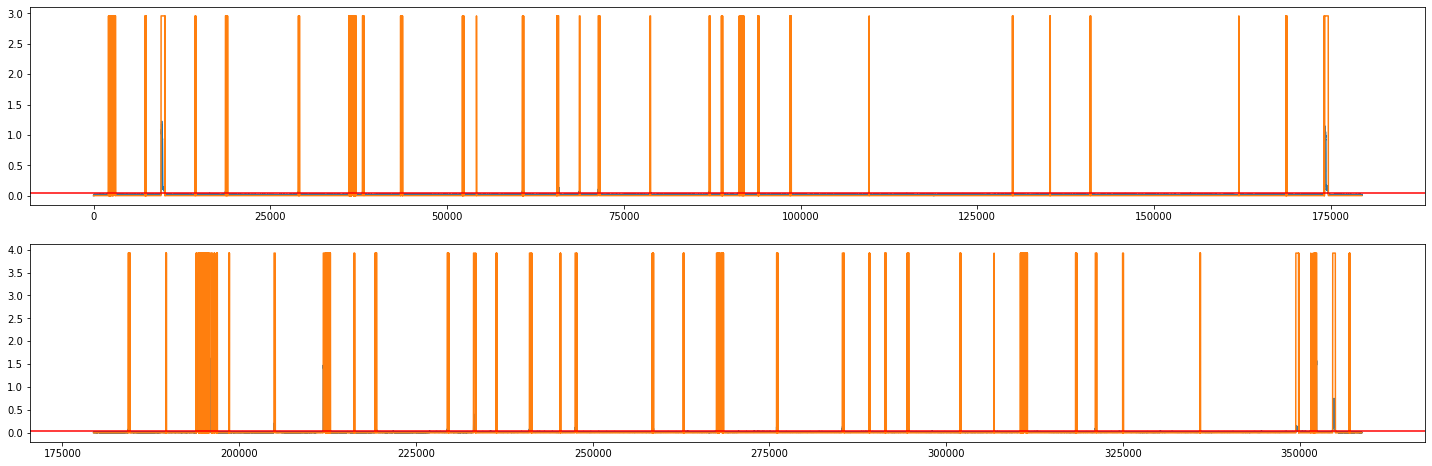

submission saved
epoch :  8
4987/4987 - 141s - loss: 4.8575e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  8   score :  0.9658185601550270808224984691   TH_ :  0.0397
model save :  HAI_predict_3_4_epoch_8.h5


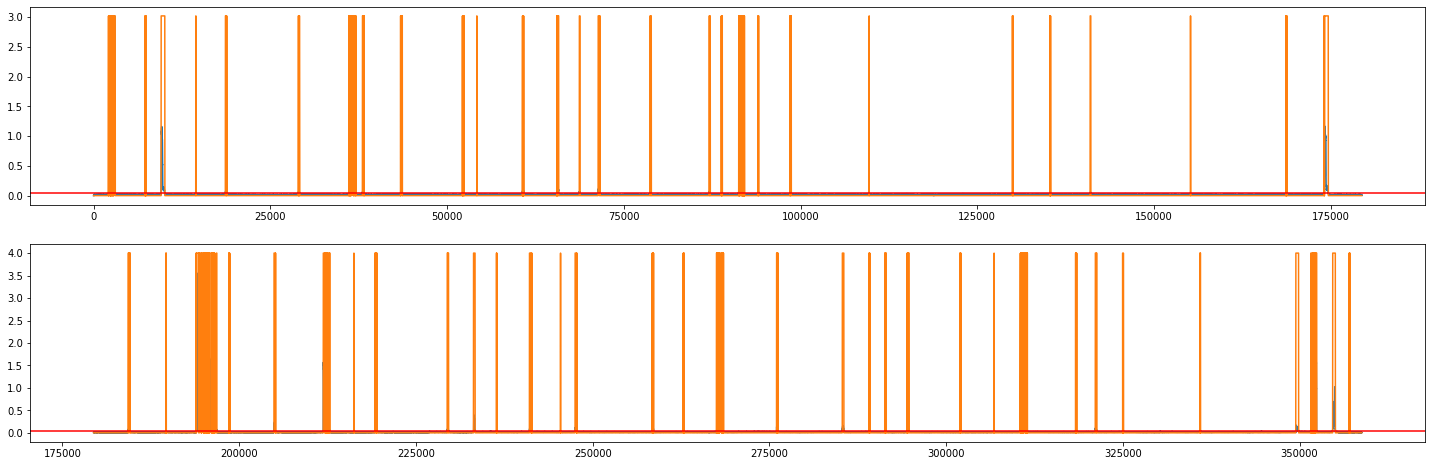

submission saved
epoch :  9
4987/4987 - 141s - loss: 4.7835e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  9   score :  0.9636300843748524516929680615   TH_ :  0.0352
model save :  HAI_predict_3_4_epoch_9.h5


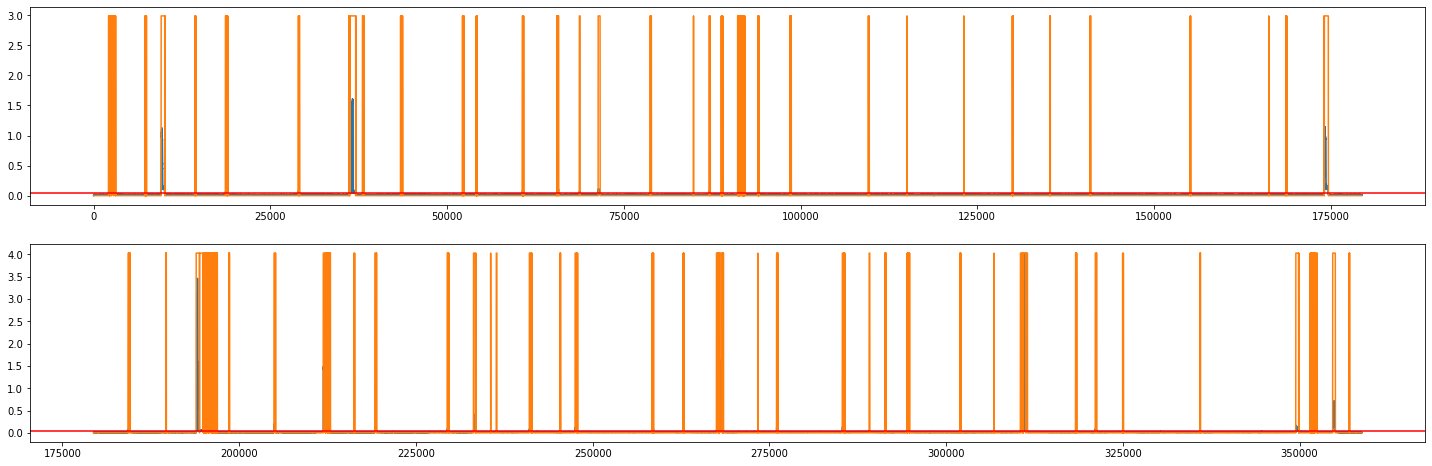

submission saved
epoch :  10
4987/4987 - 140s - loss: 4.6583e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9073445049919052354802795104
epoch :  11
4987/4987 - 140s - loss: 4.6202e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  11   score :  0.9592320156236955207406214413   TH_ :  0.0415
model save :  HAI_predict_3_4_epoch_11.h5


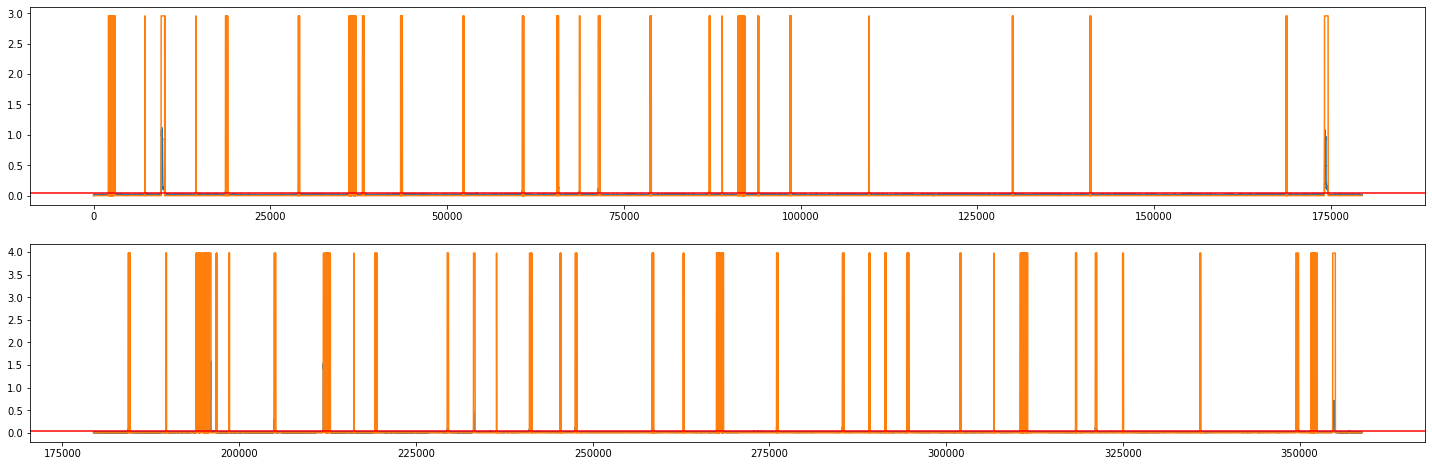

submission saved
epoch :  12
4987/4987 - 140s - loss: 4.6043e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9484949426298405263088060894
epoch :  13
4987/4987 - 141s - loss: 4.4879e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9424117245675043955420675400
epoch :  14
4987/4987 - 141s - loss: 4.4791e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  14   score :  0.9595188382755691431065534543   TH_ :  0.0415
model save :  HAI_predict_3_4_epoch_14.h5


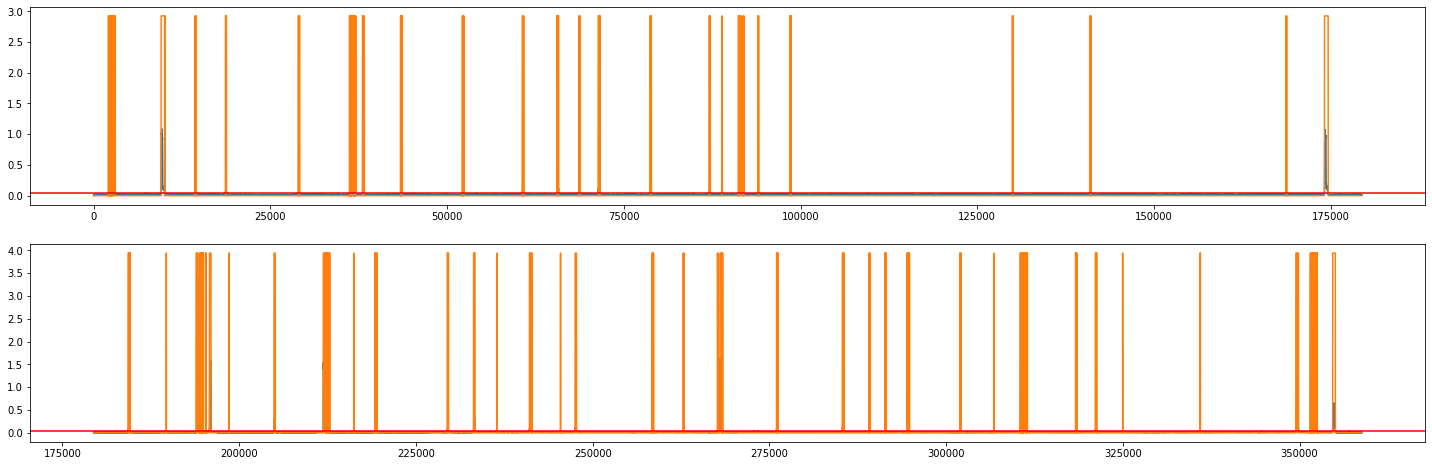

submission saved
epoch :  15
4987/4987 - 140s - loss: 4.4164e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  15   score :  0.9591881709783745908038835756   TH_ :  0.0415
model save :  HAI_predict_3_4_epoch_15.h5


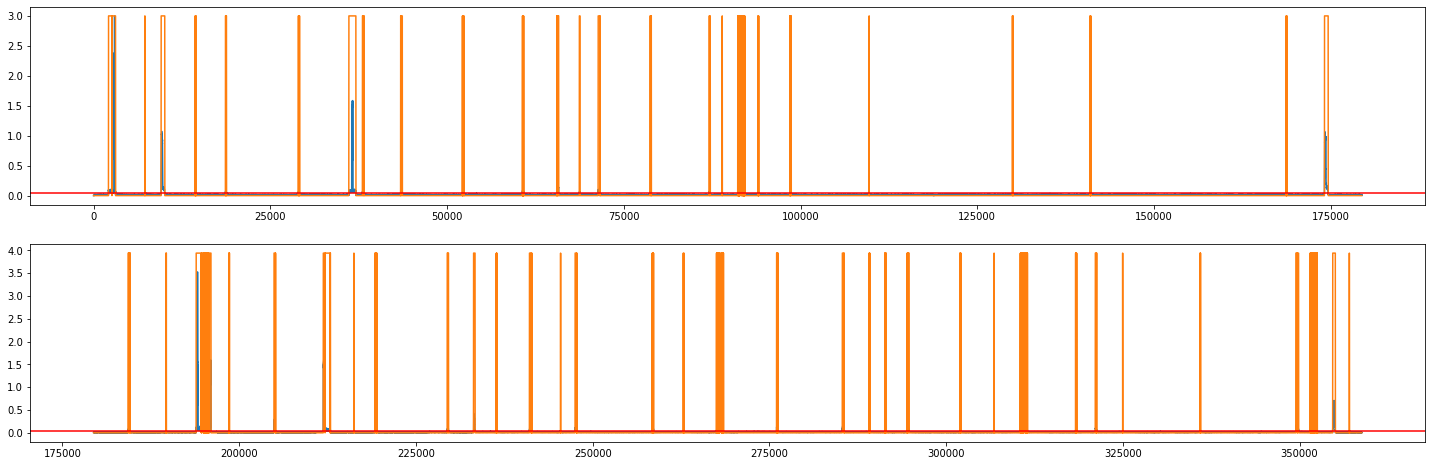

submission saved
epoch :  16
4987/4987 - 140s - loss: 4.3808e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9477612659497476039286611335
epoch :  17
4987/4987 - 140s - loss: 4.4044e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  17   score :  0.9573304736071335268289754981   TH_ :  0.040600000000000004
model save :  HAI_predict_3_4_epoch_17.h5


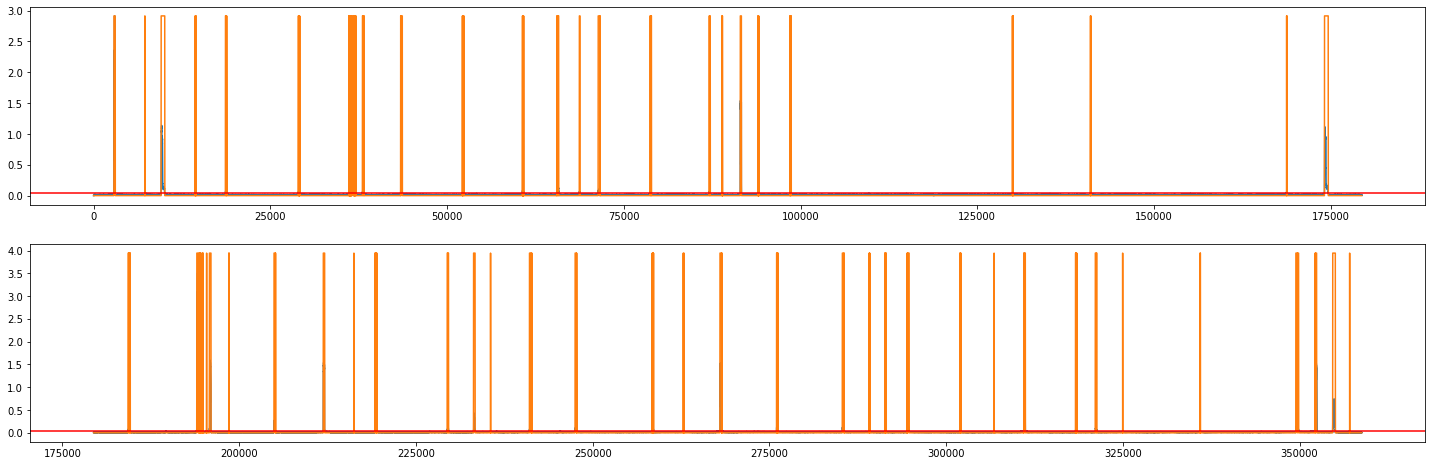

submission saved
epoch :  18
4987/4987 - 141s - loss: 4.3446e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  18   score :  0.9517704552911700486904989614   TH_ :  0.04240000000000001
model save :  HAI_predict_3_4_epoch_18.h5


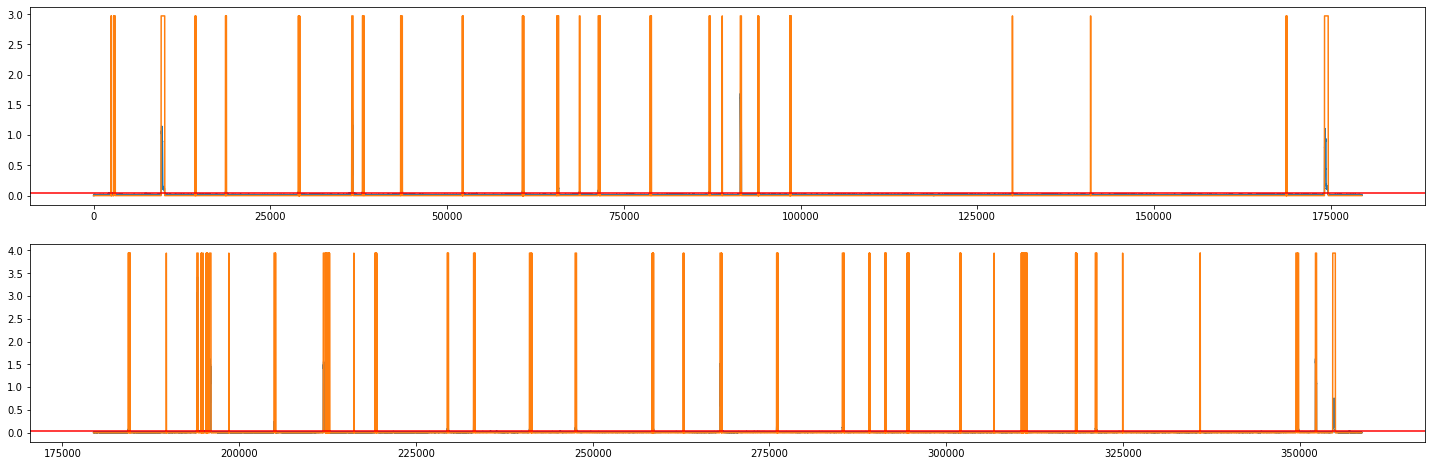

submission saved
epoch :  19
4987/4987 - 140s - loss: 4.3200e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  19   score :  0.9673321438907670805530157125   TH_ :  0.0397
model save :  HAI_predict_3_4_epoch_19.h5


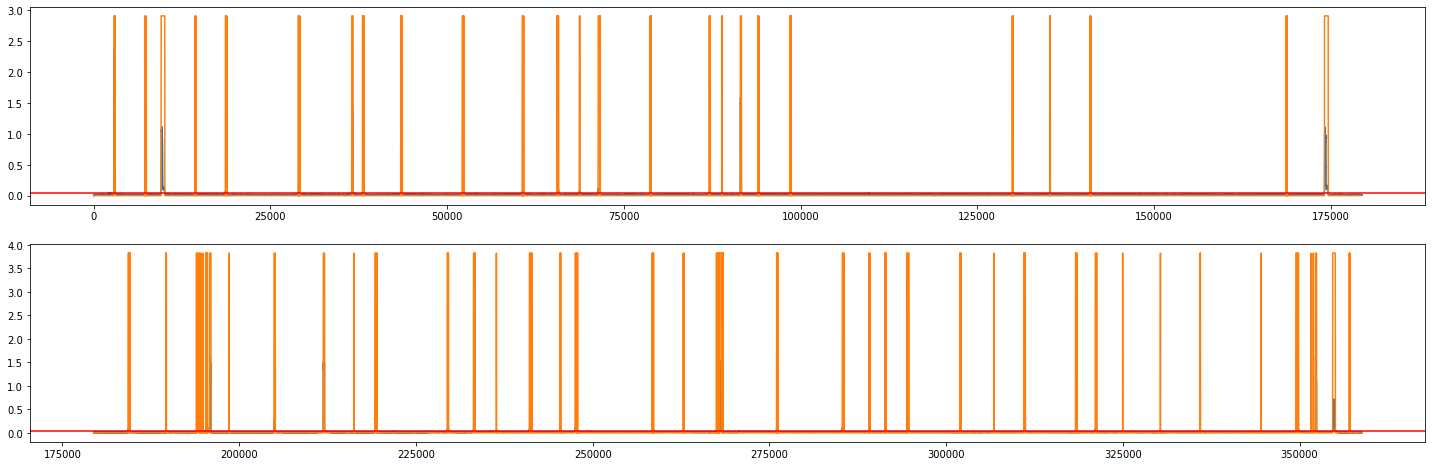

submission saved
epoch :  20
4987/4987 - 142s - loss: 4.2427e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  20   score :  0.9589661149103079084148339594   TH_ :  0.043300000000000005
model save :  HAI_predict_3_4_epoch_20.h5


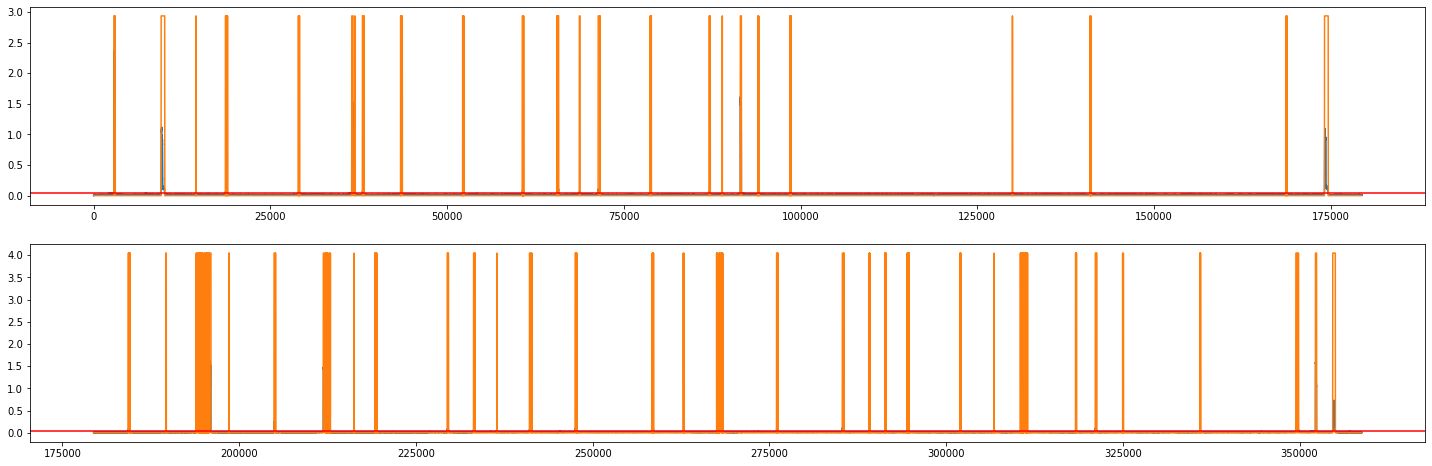

submission saved
epoch :  21
4987/4987 - 140s - loss: 4.2303e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  21   score :  0.9647189272809437067938324425   TH_ :  0.0379
model save :  HAI_predict_3_4_epoch_21.h5


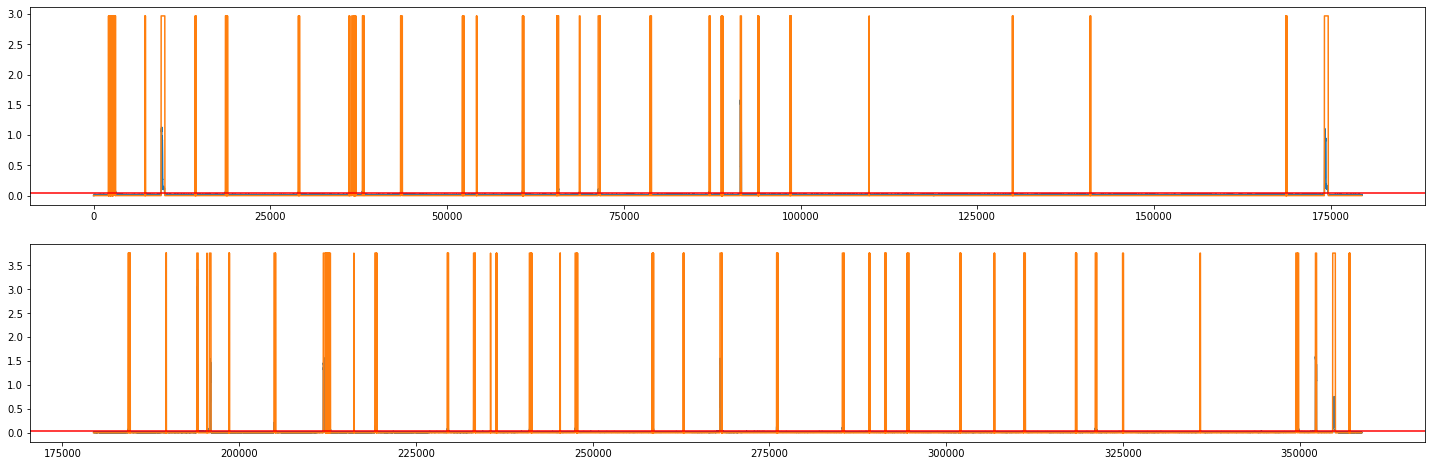

submission saved
epoch :  22
4987/4987 - 140s - loss: 4.1899e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9499655807332771276709082232
epoch :  23
4987/4987 - 141s - loss: 4.1661e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9412133642188520583689393124
epoch :  24
4987/4987 - 140s - loss: 4.1963e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  24   score :  0.9627890752330452637848558125   TH_ :  0.040600000000000004
model save :  HAI_predict_3_4_epoch_24.h5


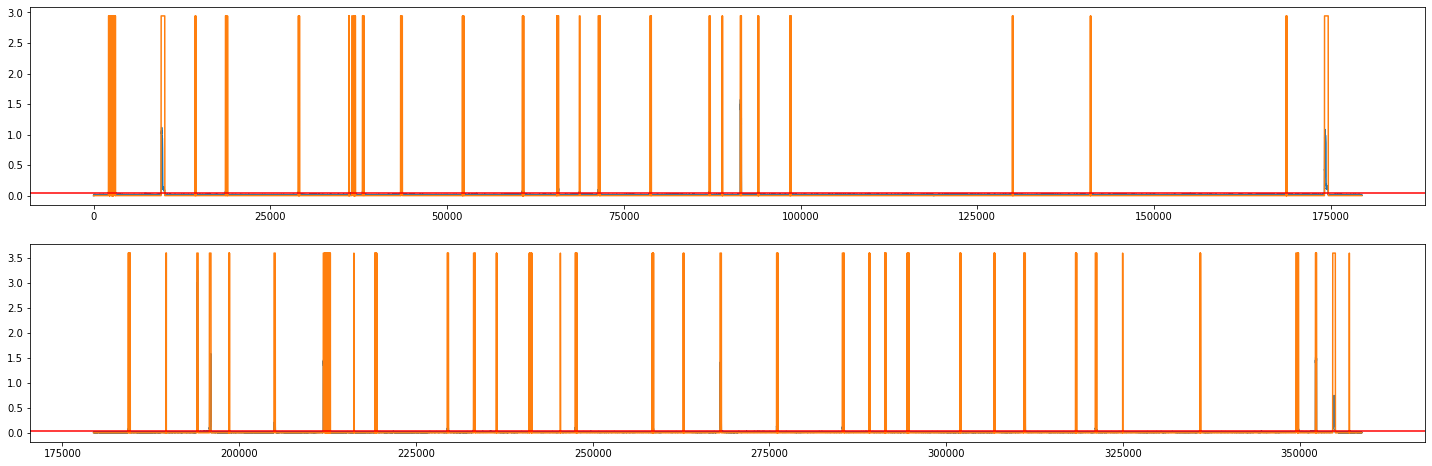

submission saved
epoch :  25
4987/4987 - 140s - loss: 4.1296e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9437546618791787064711462851
epoch :  26
4987/4987 - 140s - loss: 4.1339e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  26   score :  0.9544148685701182516630731716   TH_ :  0.037000000000000005
model save :  HAI_predict_3_4_epoch_26.h5


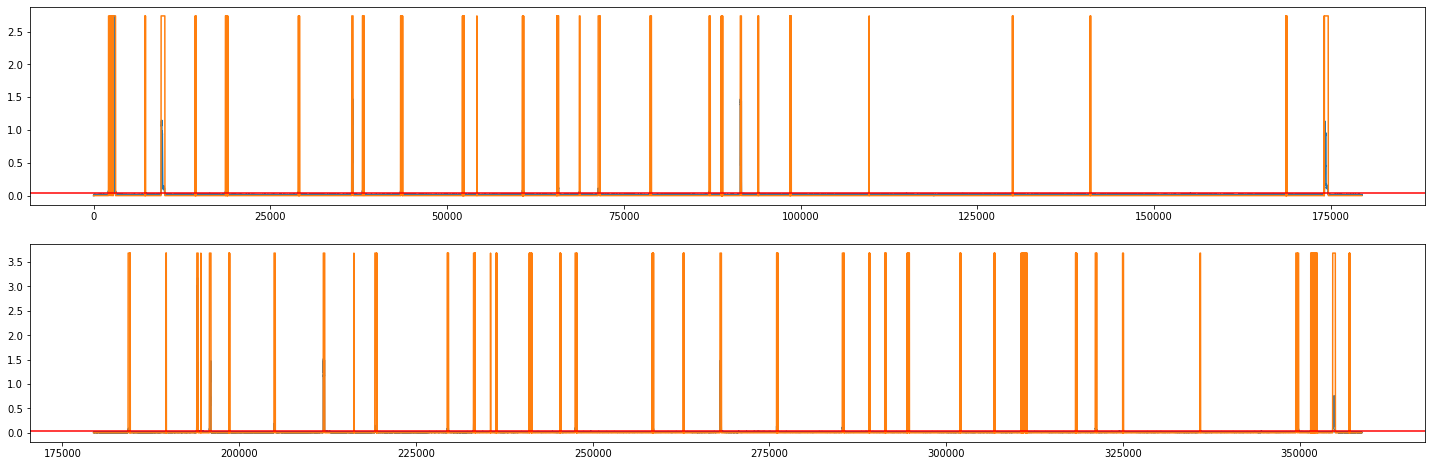

submission saved
epoch :  27
4987/4987 - 141s - loss: 4.1130e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9483149517011473210376599332
epoch :  28
4987/4987 - 141s - loss: 4.0722e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9380033974109015664842560771
epoch :  29
4987/4987 - 145s - loss: 4.0229e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  29   score :  0.9685266630896993227936601908   TH_ :  0.0361
model save :  HAI_predict_3_4_epoch_29.h5


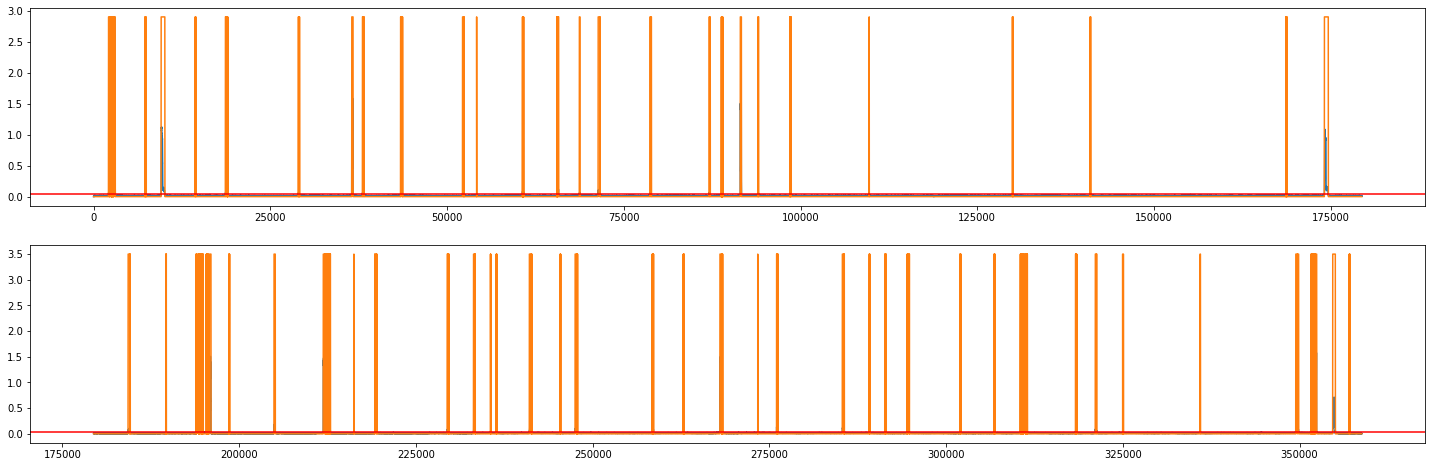

submission saved
epoch :  30
4987/4987 - 147s - loss: 4.0454e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_4   epoch :  30   score :  0.9567732633388243269335371674   TH_ :  0.0397
model save :  HAI_predict_3_4_epoch_30.h5


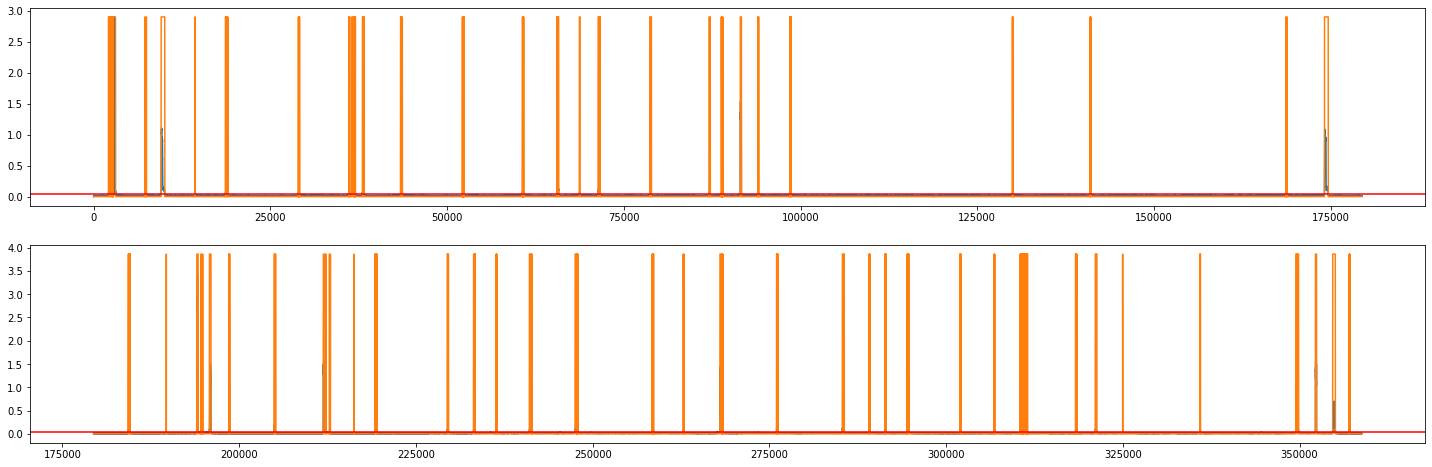

submission saved
epoch :  31
4987/4987 - 148s - loss: 3.9808e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9448247389463128734111203484
epoch :  32
4987/4987 - 148s - loss: 4.0118e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9428035813339424801885169929
epoch :  33
4987/4987 - 148s - loss: 4.0205e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_5
epoch :  0
4987/4987 - 247s - loss: 0.0028
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9247711593052163361230718823
epoch :  1
4987/4987 - 246s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9146375959983045806527975303
epoch :  2
4987/4987 - 251s - loss: 8.8468e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8608460316972384516300387147
epoch :  3
4987/4987 - 254s - loss: 7.9268e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9155023543400921209876617741
epoch :  4
4987/4987 - 254s - loss: 7.4192e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9112909195672453372713285397
epoch :  5
4987/4987 - 254s - loss: 6.8756e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9100553137189388939667521485
epoch :  6
4987/4987 - 248s - loss: 6.7130e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8915045154837529378766937035
epoch :  7
4987/4987 - 254s - loss: 5.5729e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9059606619890233962124254818
epoch :  8
4987/4987 - 254s - loss: 5.1953e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9064623586411370375992546545
epoch :  9
4987/4987 - 254s - loss: 5.1075e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9061537129697806289320451787
epoch :  10
4987/4987 - 253s - loss: 4.9342e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9321615458558283741754852811
epoch :  11
4987/4987 - 249s - loss: 4.9372e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9383980996046793829049980582
epoch :  12
4987/4987 - 256s - loss: 4.8276e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_5   epoch :  12   score :  0.9513721017980582689529599128   TH_ :  0.0361
model save :  HAI_predict_3_5_epoch_12.h5


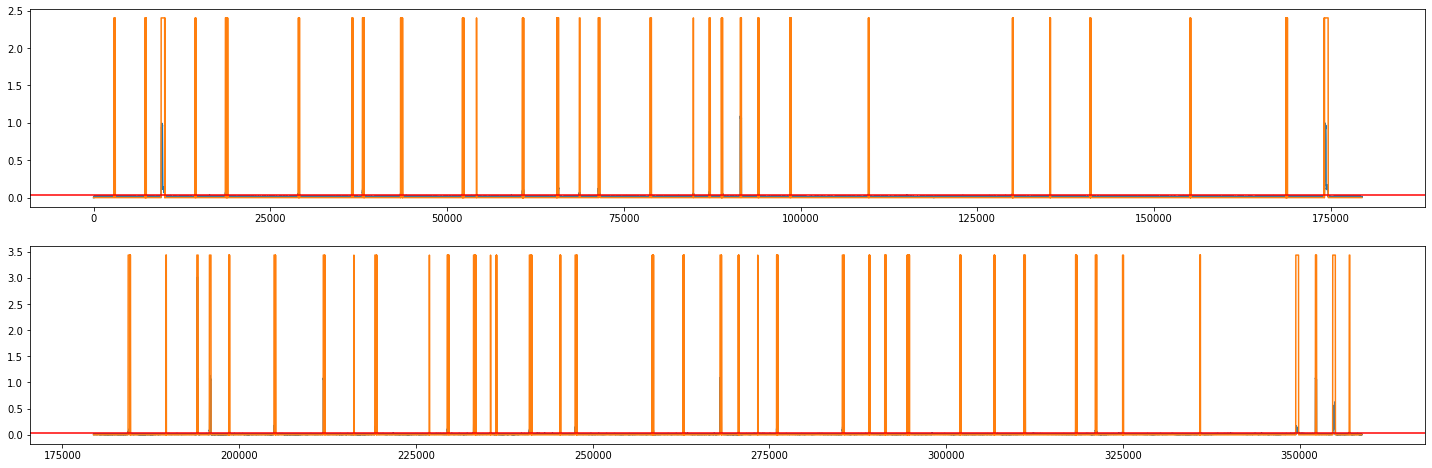

submission saved
epoch :  13
4987/4987 - 254s - loss: 4.6965e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_5   epoch :  13   score :  0.9698869800035766379394273043   TH_ :  0.033400000000000006
model save :  HAI_predict_3_5_epoch_13.h5


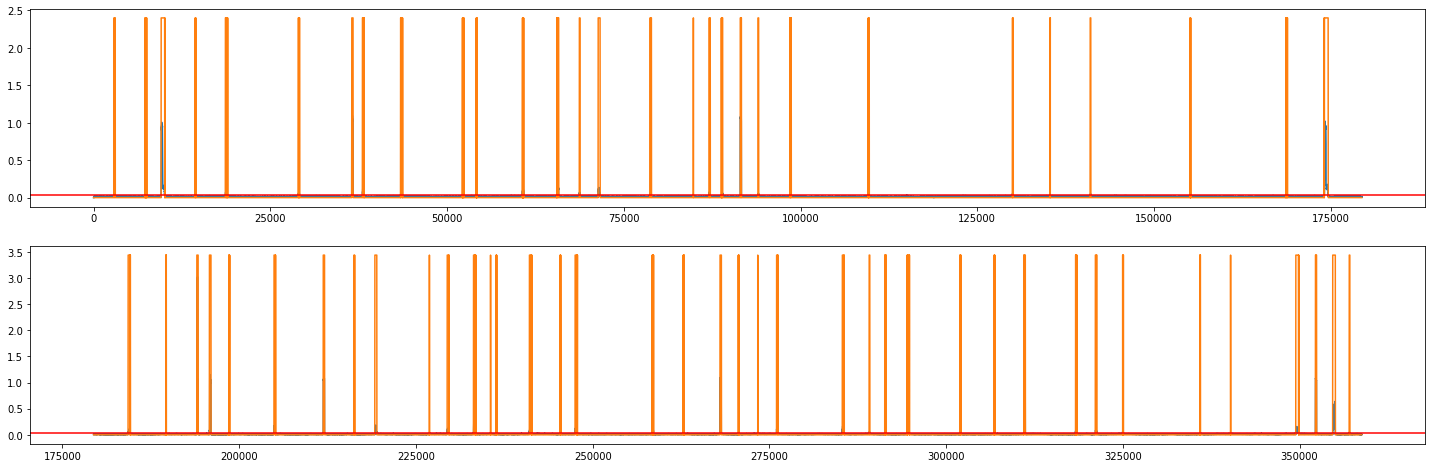

submission saved
epoch :  14
4987/4987 - 253s - loss: 4.6775e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9466942442723281604767366514
epoch :  15
4987/4987 - 248s - loss: 4.5931e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9325096153460909894945741297
epoch :  16
4987/4987 - 250s - loss: 4.5480e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8961091987923231123666797943
epoch :  17
4987/4987 - 249s - loss: 4.5109e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_5   epoch :  17   score :  0.9622642224608344034493196185   TH_ :  0.03250000000000001
model save :  HAI_predict_3_5_epoch_17.h5


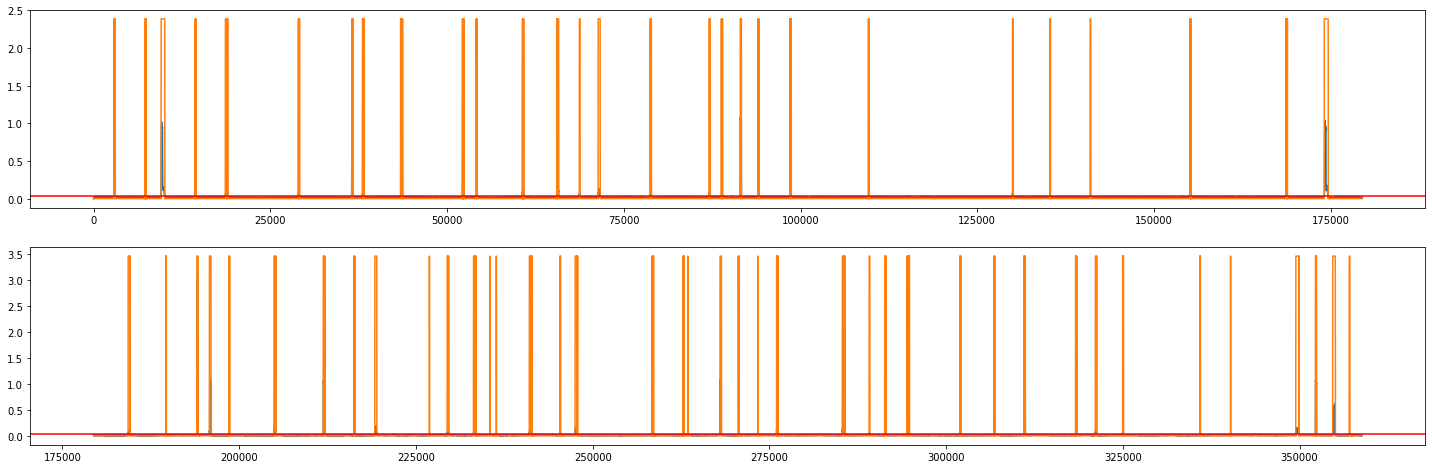

submission saved
epoch :  18
4987/4987 - 248s - loss: 4.5101e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9120344400078055091178909682
epoch :  19
4987/4987 - 250s - loss: 4.4264e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_5   epoch :  19   score :  0.9585750256710759826545784626   TH_ :  0.0352
model save :  HAI_predict_3_5_epoch_19.h5


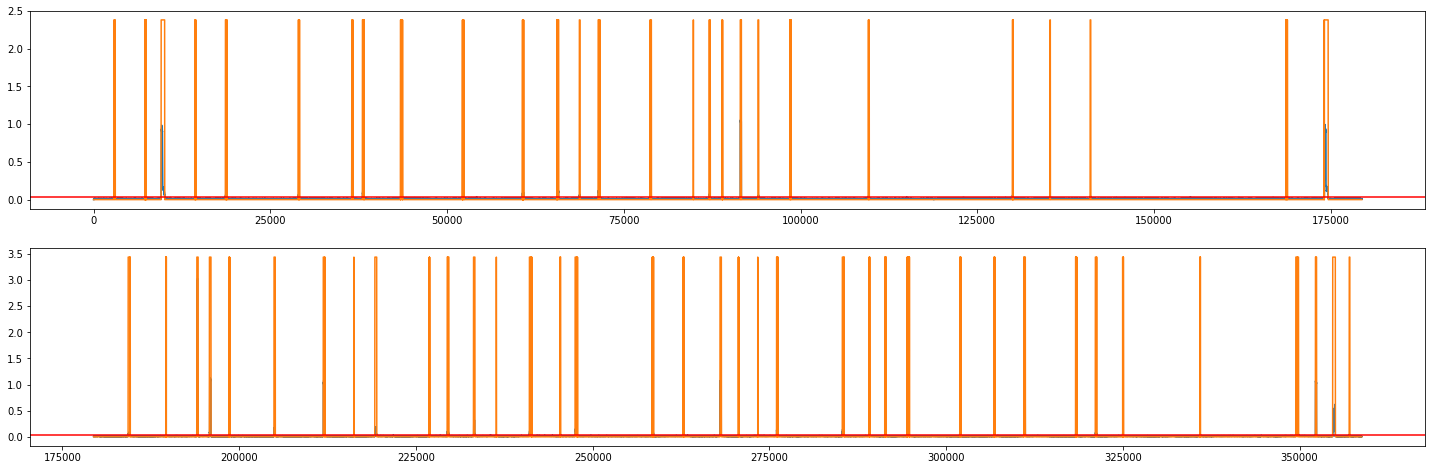

submission saved
epoch :  20
4987/4987 - 246s - loss: 4.4591e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9454991808292134325732204309
epoch :  21
4987/4987 - 251s - loss: 4.3309e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9469144089671601228079986552
epoch :  22
4987/4987 - 251s - loss: 4.3877e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8884015385167558622085865316
epoch :  23
4987/4987 - 251s - loss: 4.3143e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9377794542720949620441676299
epoch :  24
4987/4987 - 250s - loss: 4.2909e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8958970481266661091008260455
epoch :  25
4987/4987 - 244s - loss: 4.2958e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9130476670499910328637819767
epoch :  26
4987/4987 - 249s - loss: 4.2424e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_6
epoch :  0
4987/4987 - 228s - loss: 0.0027
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8735107655831024126858221655
epoch :  1
4987/4987 - 228s - loss: 9.5423e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9044850519375858767947214607
epoch :  2
4987/4987 - 227s - loss: 7.5601e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8954542149017844269028334656
epoch :  3
4987/4987 - 222s - loss: 6.0214e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8908758749002264572247082698
epoch :  4
4987/4987 - 228s - loss: 5.6579e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8977175174561346901715866471
epoch :  5
4987/4987 - 228s - loss: 5.2932e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  5   score :  0.9520105866839004802112889791   TH_ :  0.0361
model save :  HAI_predict_3_6_epoch_5.h5


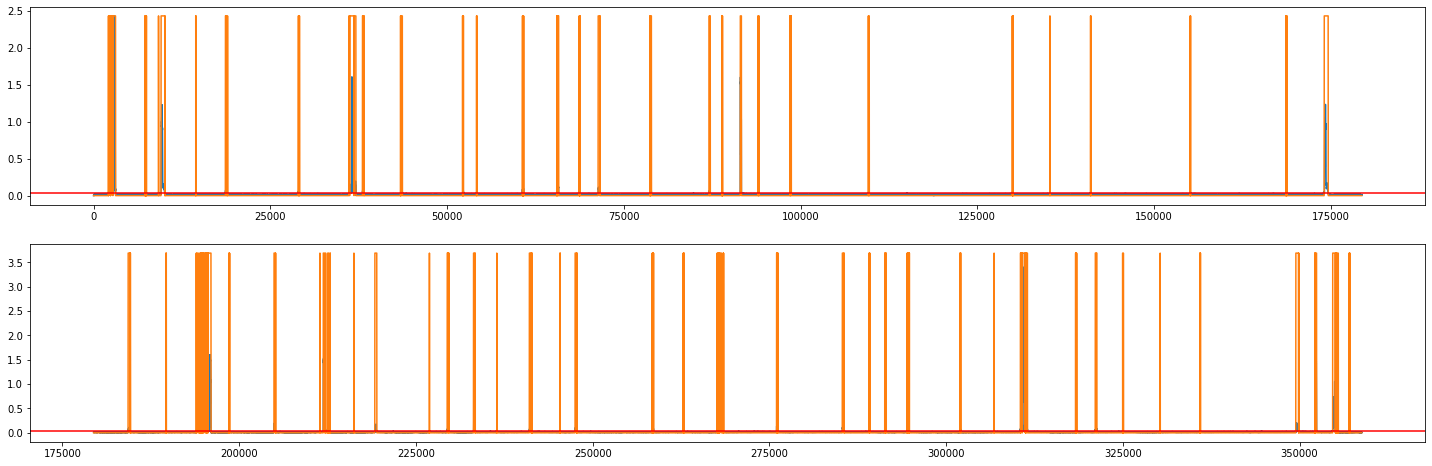

submission saved
epoch :  6
4987/4987 - 228s - loss: 4.9326e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  6   score :  0.9626765492324559078664521919   TH_ :  0.0379
model save :  HAI_predict_3_6_epoch_6.h5


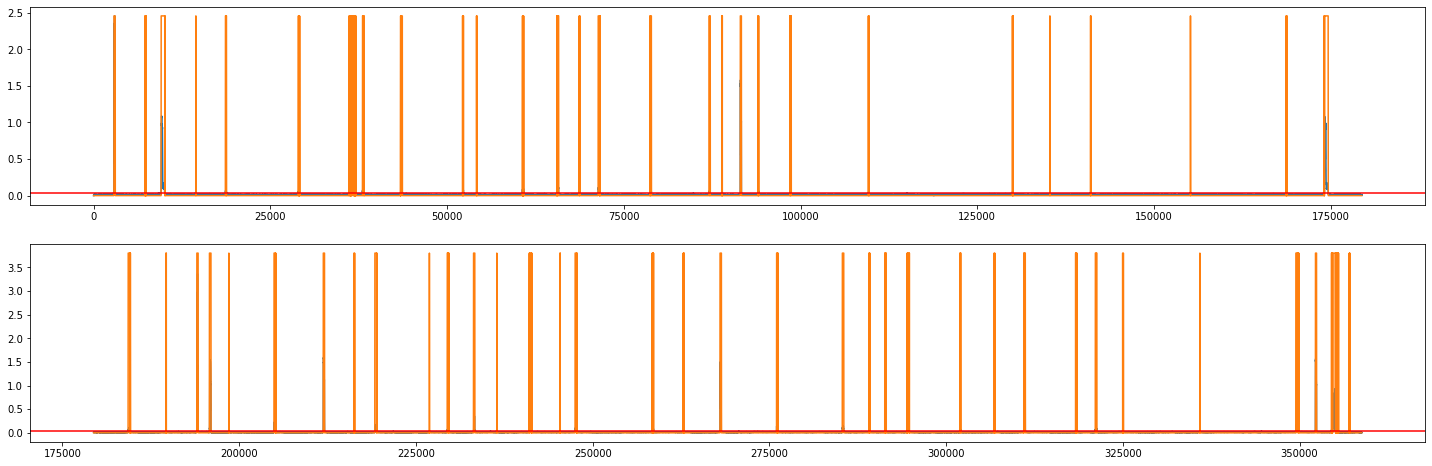

submission saved
epoch :  7
4987/4987 - 227s - loss: 4.8155e-04


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8705785587989357658207405970
epoch :  8
4987/4987 - 223s - loss: 4.6709e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  8   score :  0.9585302547349961341302038480   TH_ :  0.037000000000000005
model save :  HAI_predict_3_6_epoch_8.h5


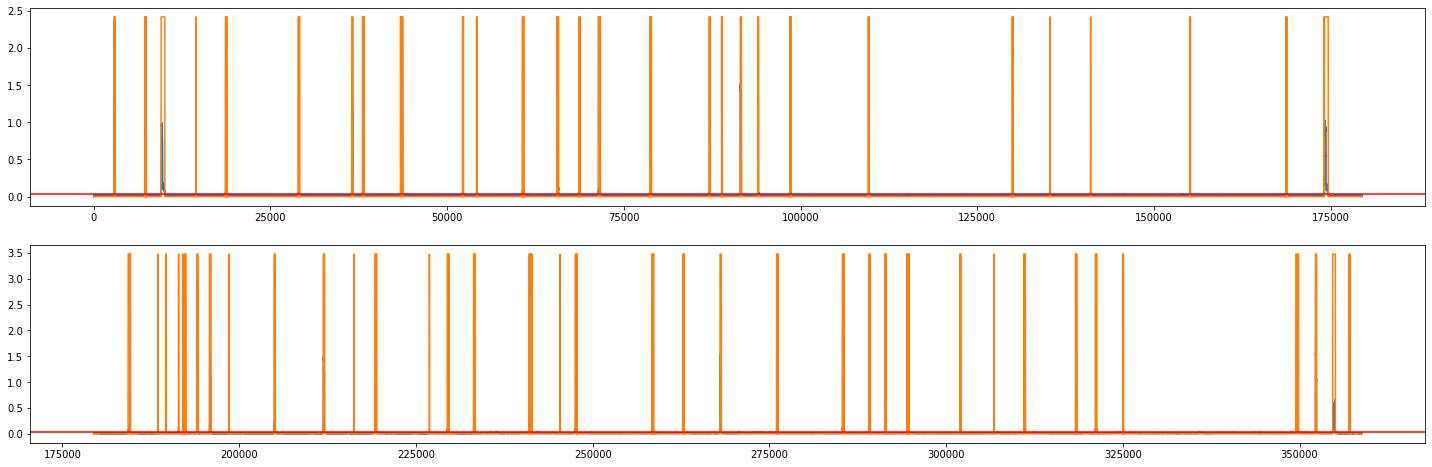

submission saved
epoch :  9
4987/4987 - 228s - loss: 4.5921e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  9   score :  0.9557440074973453834938504380   TH_ :  0.0361
model save :  HAI_predict_3_6_epoch_9.h5


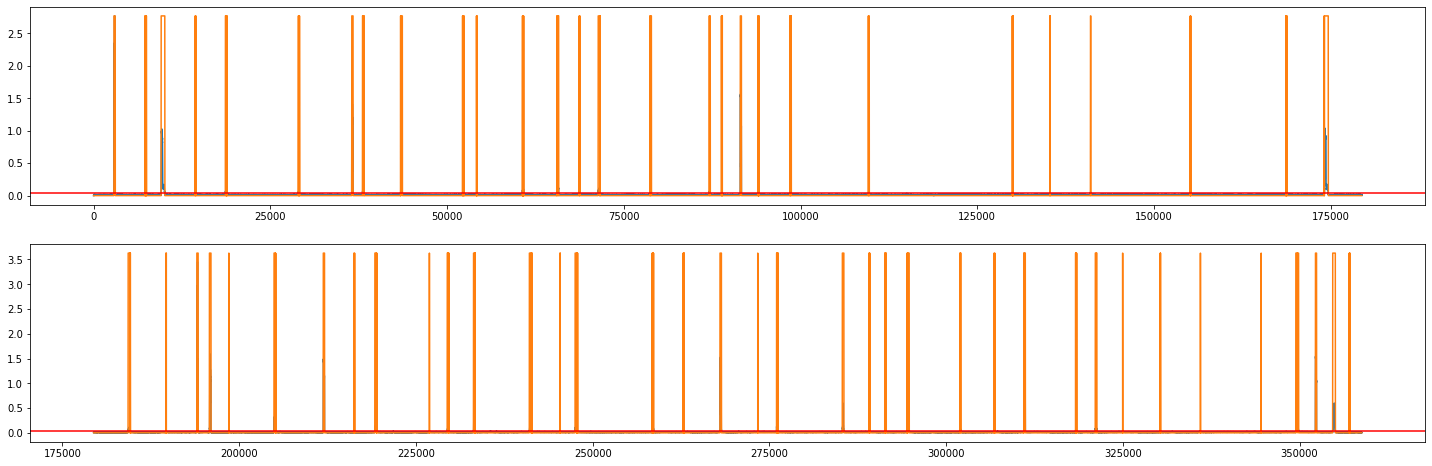

submission saved
epoch :  10
4987/4987 - 228s - loss: 4.5361e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  10   score :  0.9599791105688917435903482667   TH_ :  0.034300000000000004
model save :  HAI_predict_3_6_epoch_10.h5


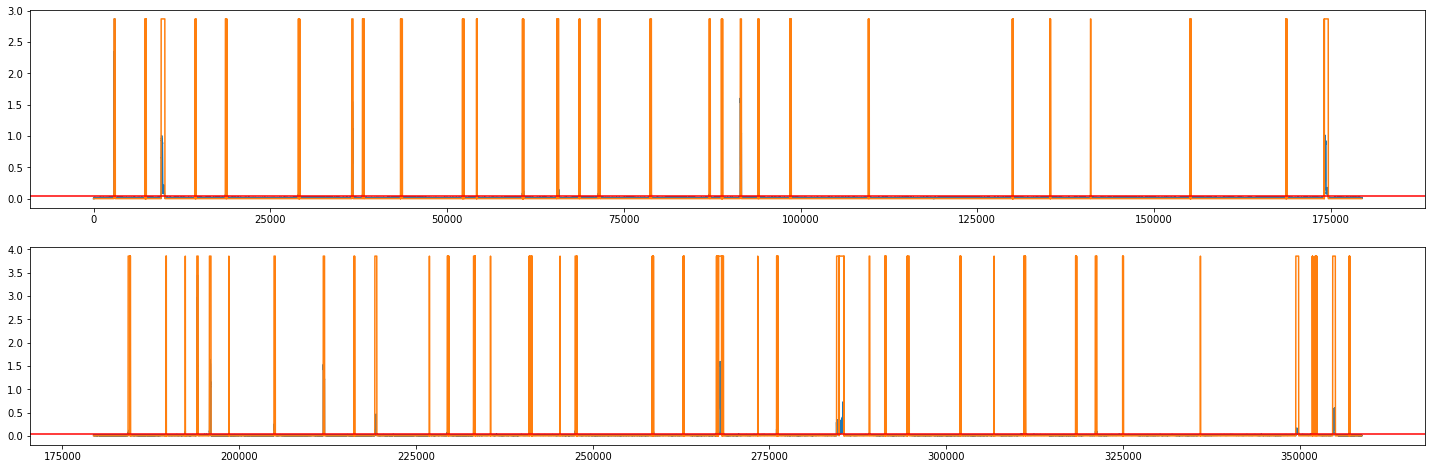

submission saved
epoch :  11
4987/4987 - 229s - loss: 4.4467e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  11   score :  0.9599247447230778761239748881   TH_ :  0.034300000000000004
model save :  HAI_predict_3_6_epoch_11.h5


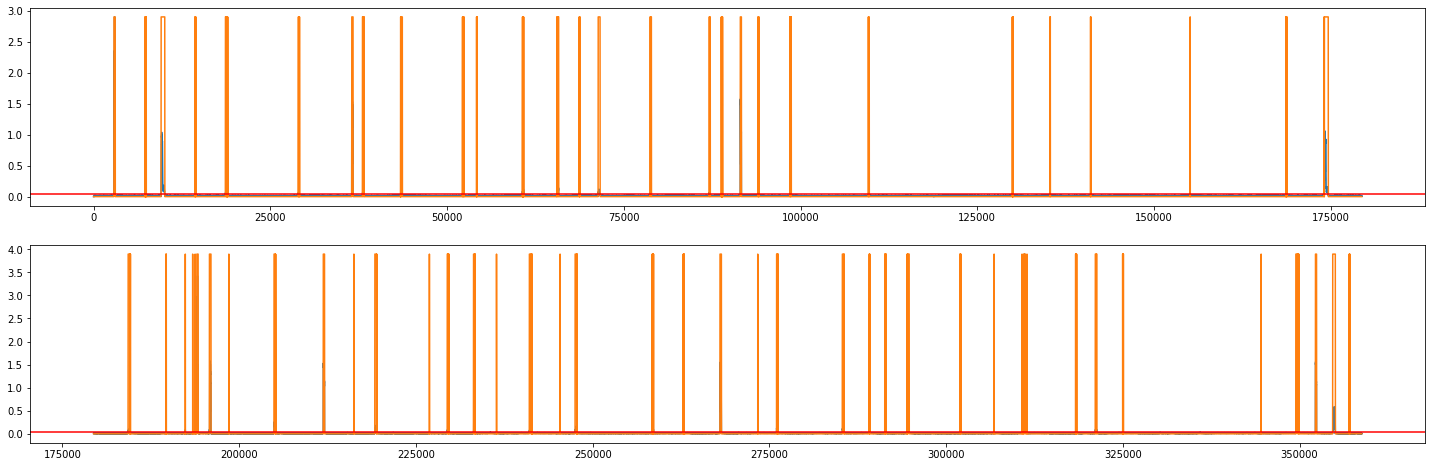

submission saved
epoch :  12
4987/4987 - 230s - loss: 4.4317e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  12   score :  0.9569080369907238229440219915   TH_ :  0.034300000000000004
model save :  HAI_predict_3_6_epoch_12.h5


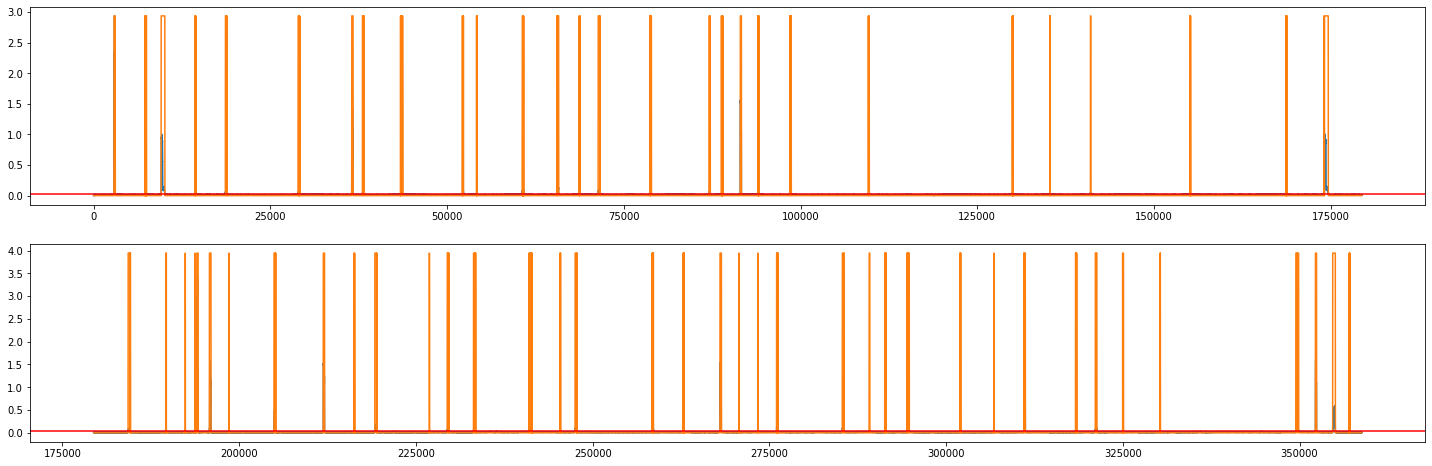

submission saved
epoch :  13
4987/4987 - 226s - loss: 4.3040e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9471987985590489287732786786
epoch :  14
4987/4987 - 229s - loss: 4.2766e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  14   score :  0.9567976289825486982851924767   TH_ :  0.0361
model save :  HAI_predict_3_6_epoch_14.h5


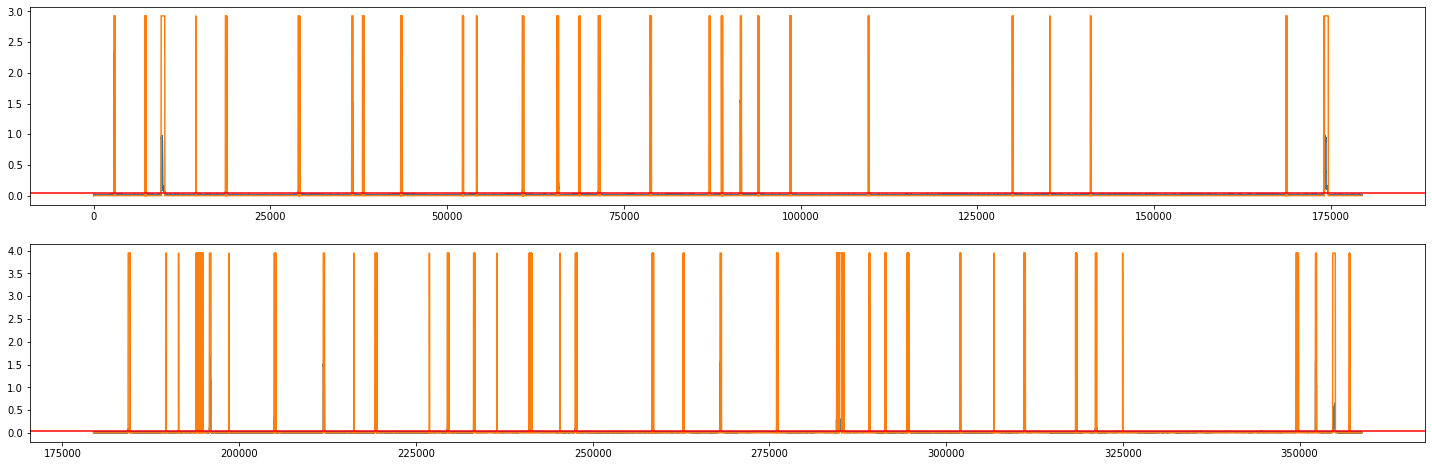

submission saved
epoch :  15
4987/4987 - 230s - loss: 4.2262e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  15   score :  0.9564376663671207327880260556   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_15.h5


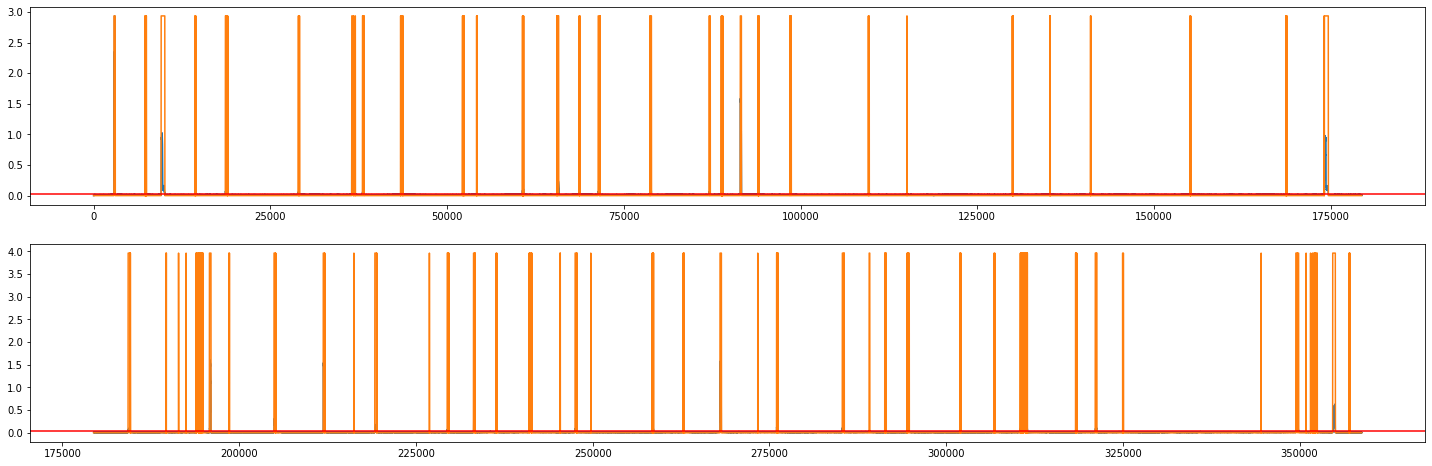

submission saved
epoch :  16
4987/4987 - 230s - loss: 4.1989e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  16   score :  0.9555392762373499265652931672   TH_ :  0.033400000000000006
model save :  HAI_predict_3_6_epoch_16.h5


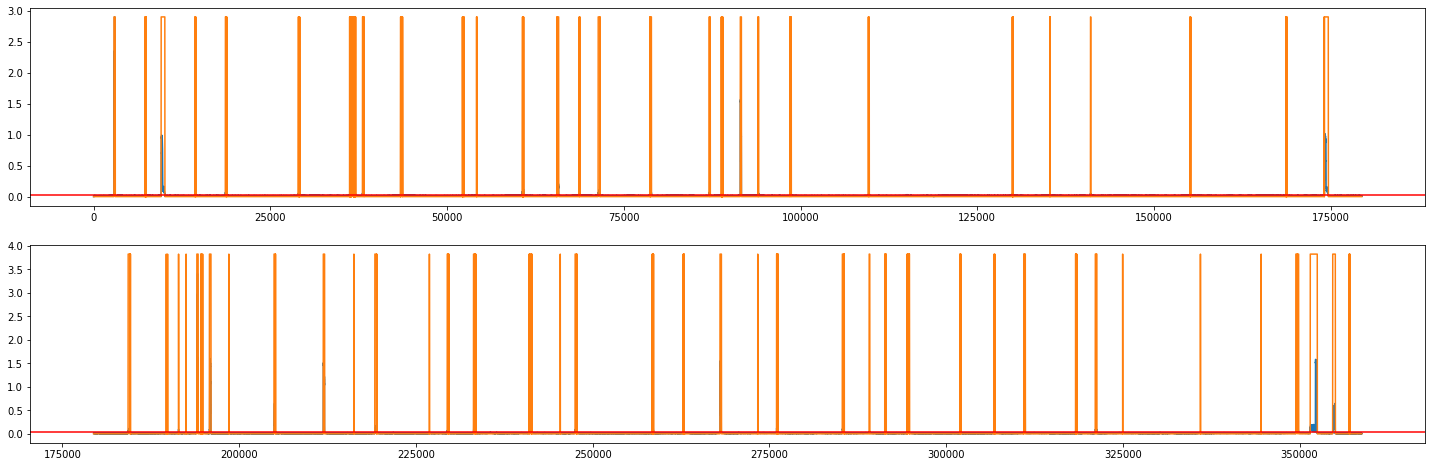

submission saved
epoch :  17
4987/4987 - 230s - loss: 4.1682e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  17   score :  0.9631477995878102504678903150   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_17.h5


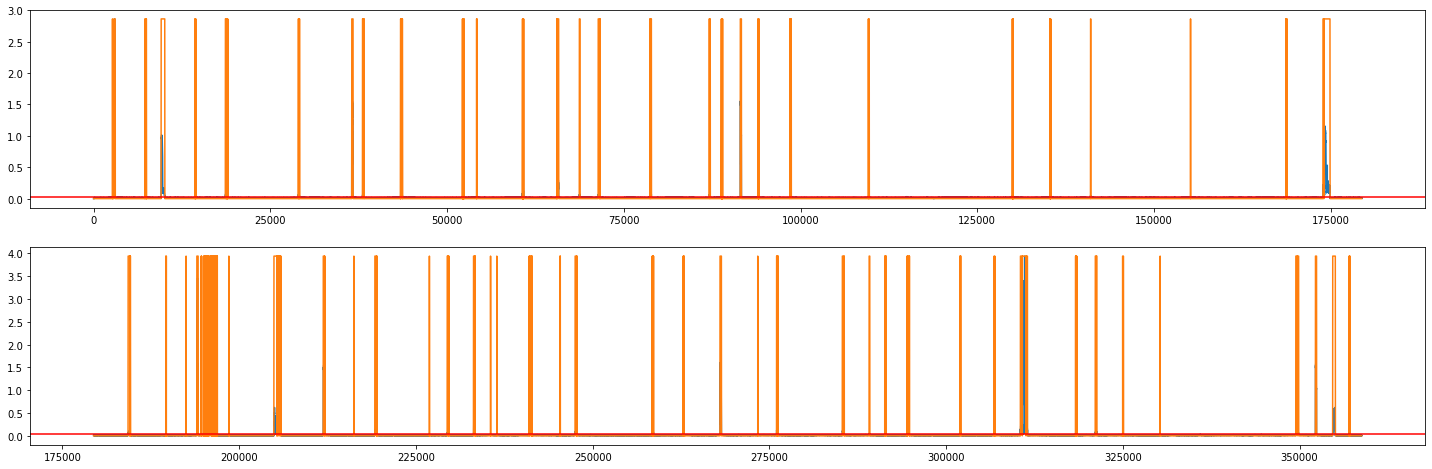

submission saved
epoch :  18
4987/4987 - 226s - loss: 4.1708e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  18   score :  0.9605463027607778918827615400   TH_ :  0.034300000000000004
model save :  HAI_predict_3_6_epoch_18.h5


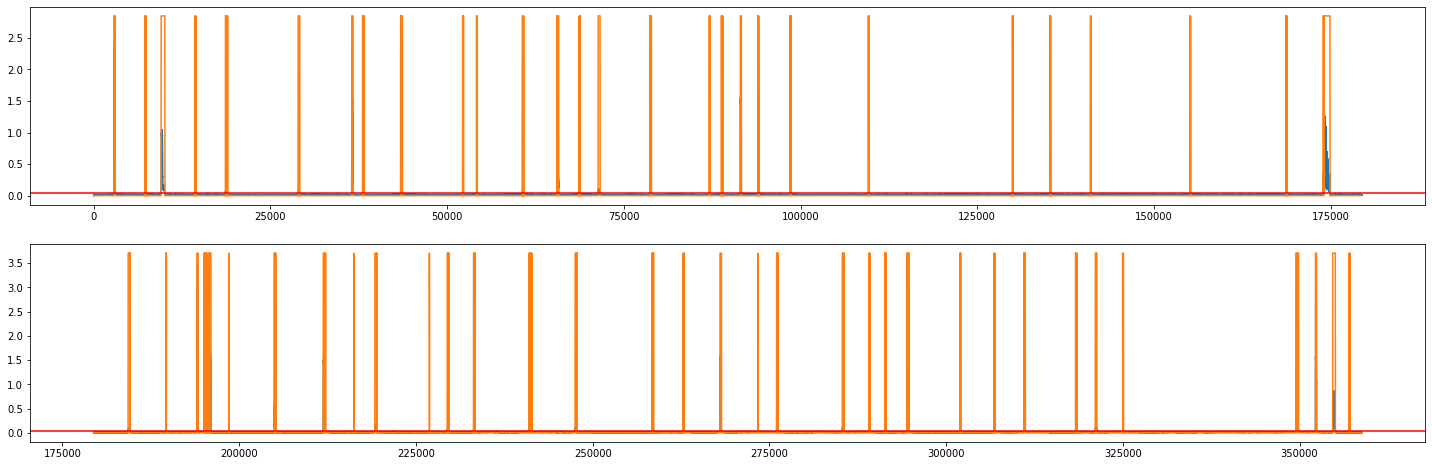

submission saved
epoch :  19
4987/4987 - 230s - loss: 4.0857e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  19   score :  0.9538349600374855289521196389   TH_ :  0.0352
model save :  HAI_predict_3_6_epoch_19.h5


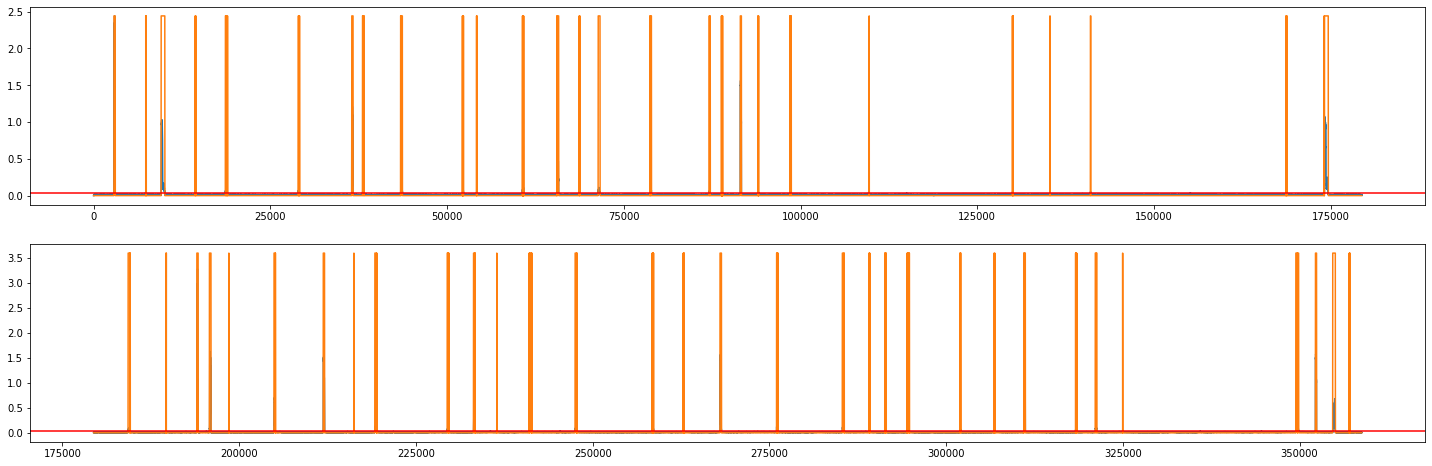

submission saved
epoch :  20
4987/4987 - 231s - loss: 4.0745e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7579688915014861080550567673
epoch :  21
4987/4987 - 231s - loss: 4.5416e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  21   score :  0.9549400132357230285576568073   TH_ :  0.04240000000000001
model save :  HAI_predict_3_6_epoch_21.h5


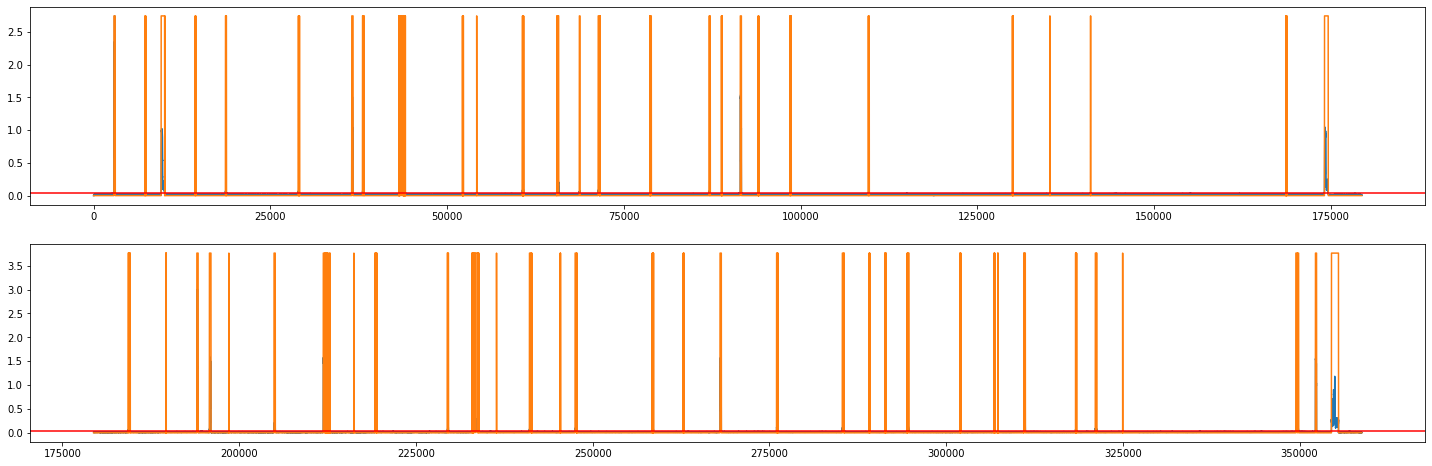

submission saved
epoch :  22
4987/4987 - 232s - loss: 4.3975e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9472122077724567665594312379
epoch :  23
4987/4987 - 230s - loss: 4.0306e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  23   score :  0.9515148557629100999246267824   TH_ :  0.0361
model save :  HAI_predict_3_6_epoch_23.h5


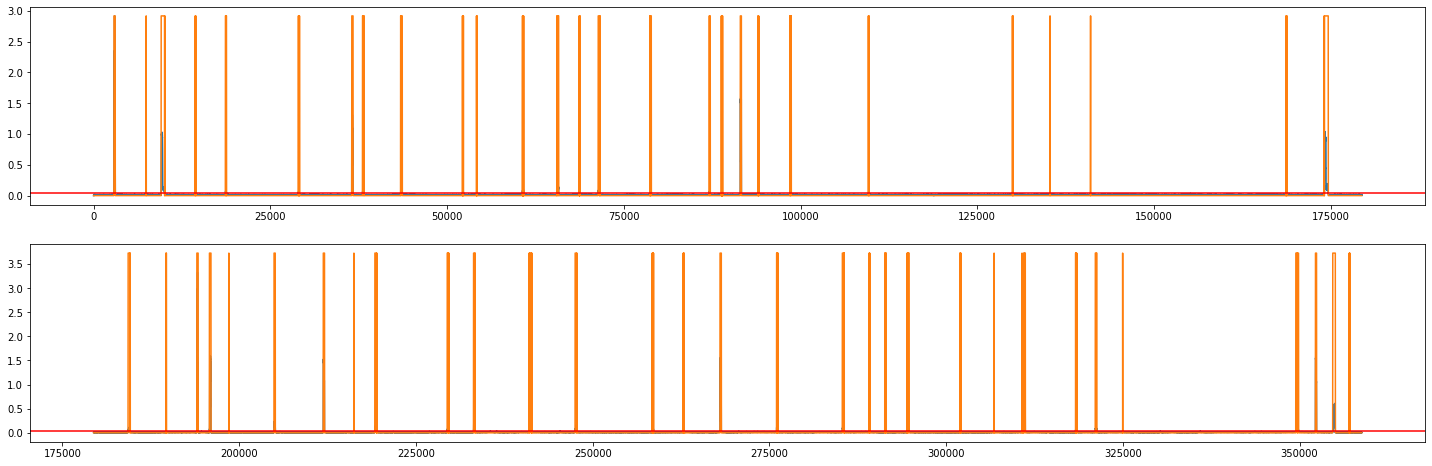

submission saved
epoch :  24
4987/4987 - 229s - loss: 4.0346e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  24   score :  0.9521761216797706214739345101   TH_ :  0.034300000000000004
model save :  HAI_predict_3_6_epoch_24.h5


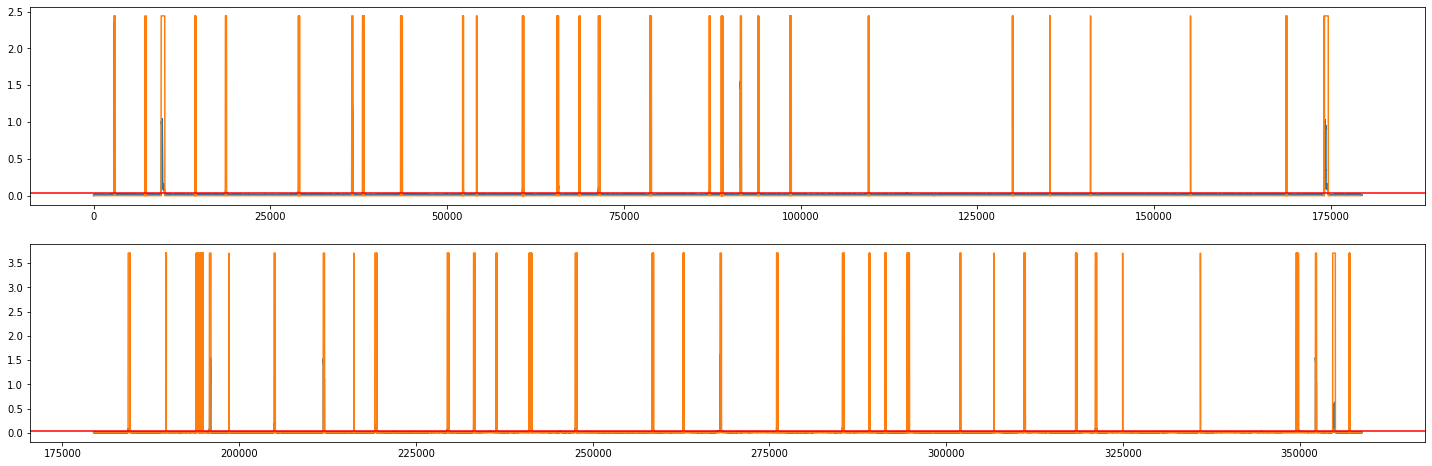

submission saved
epoch :  25
4987/4987 - 230s - loss: 3.9769e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9461140551547516277281968355
epoch :  26
4987/4987 - 231s - loss: 3.9873e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  26   score :  0.9578511752808784572093177609   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_26.h5


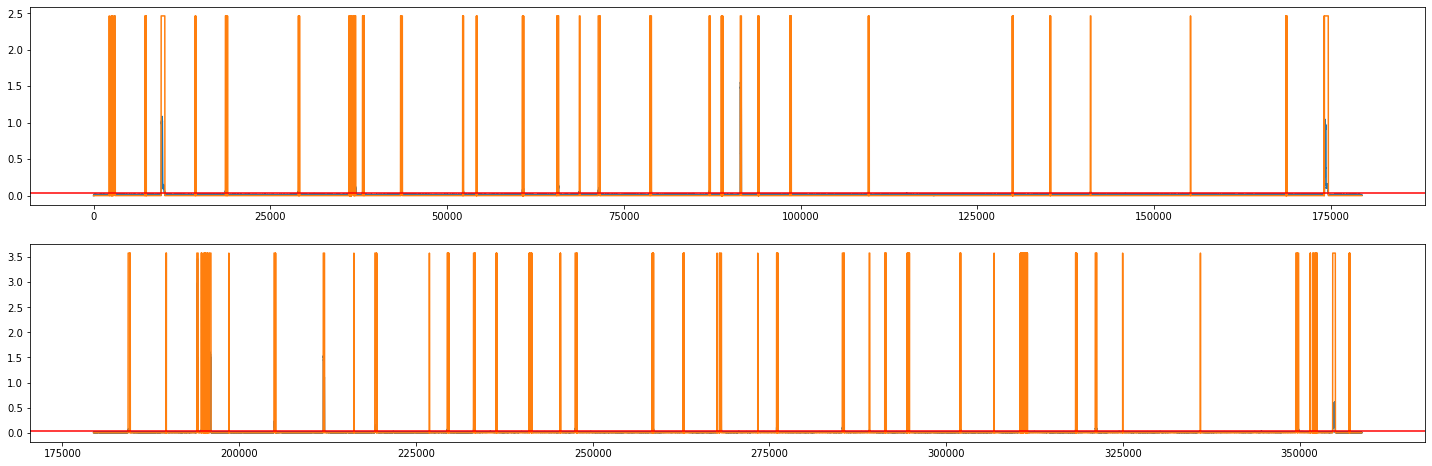

submission saved
epoch :  27
4987/4987 - 230s - loss: 3.9367e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  27   score :  0.9507205898365601648560816073   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_27.h5


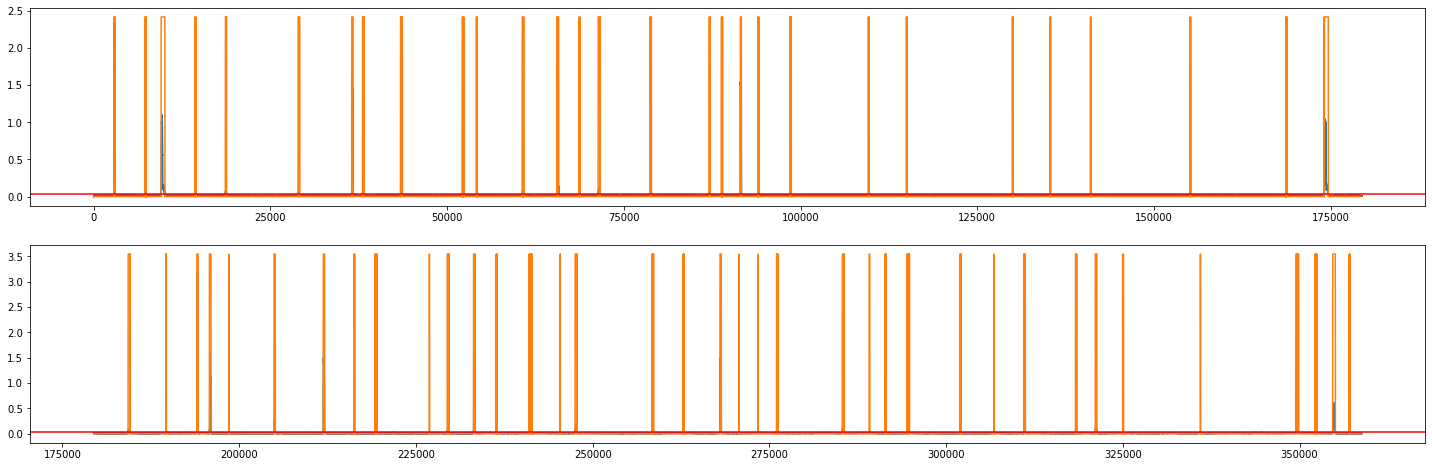

submission saved
epoch :  28
4987/4987 - 232s - loss: 3.8806e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  28   score :  0.9530270268747876403520936281   TH_ :  0.0316
model save :  HAI_predict_3_6_epoch_28.h5


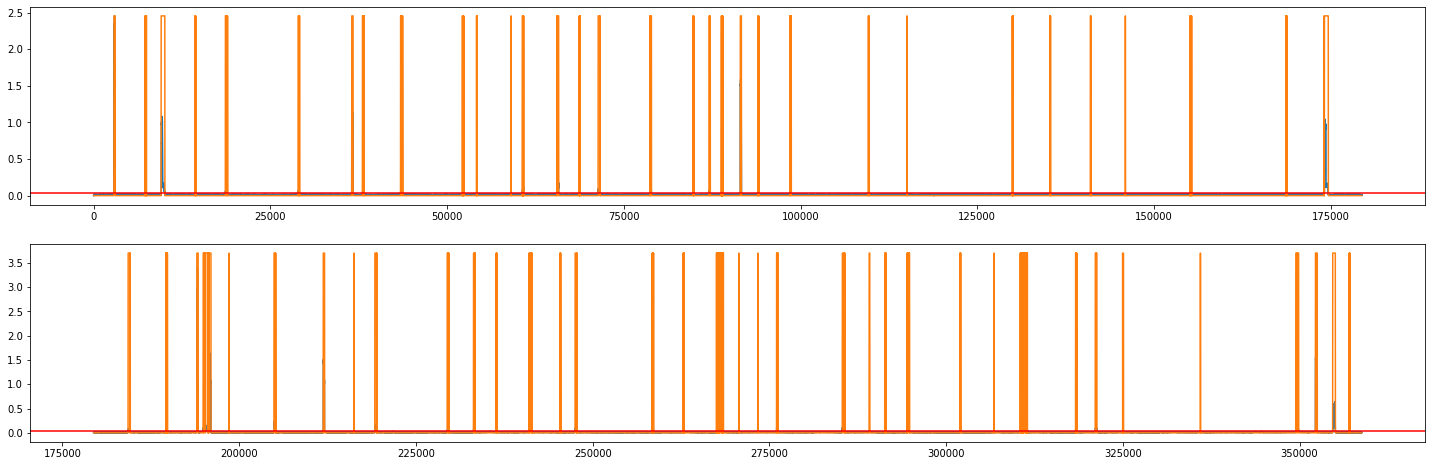

submission saved
epoch :  29
4987/4987 - 231s - loss: 3.9277e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  29   score :  0.9602352515671903201774914350   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_29.h5


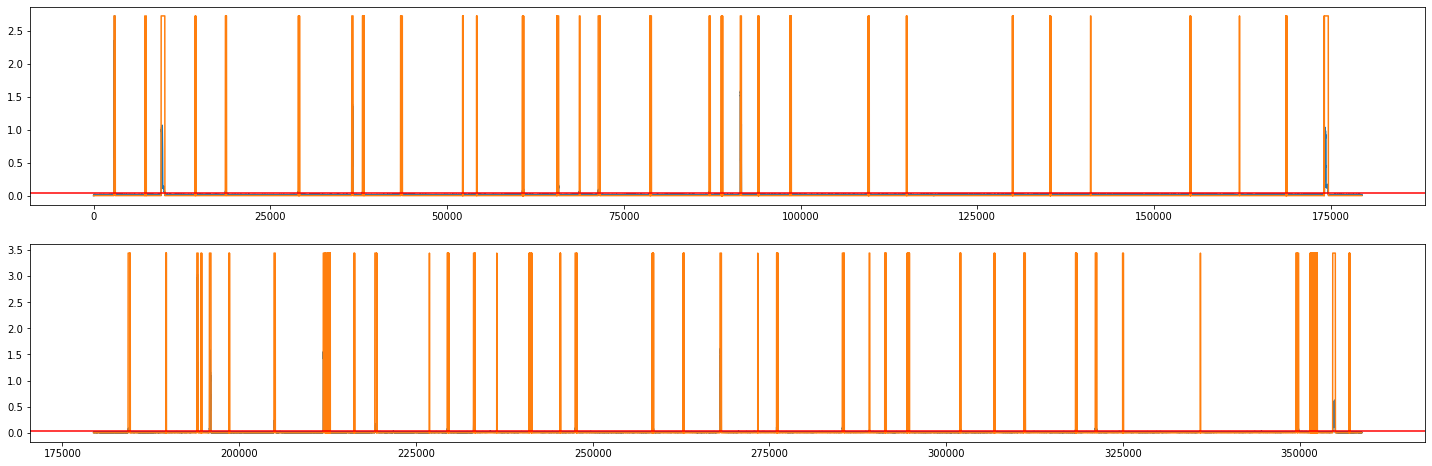

submission saved
epoch :  30
4987/4987 - 229s - loss: 3.8478e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  30   score :  0.9507410641213044852533811101   TH_ :  0.033400000000000006
model save :  HAI_predict_3_6_epoch_30.h5


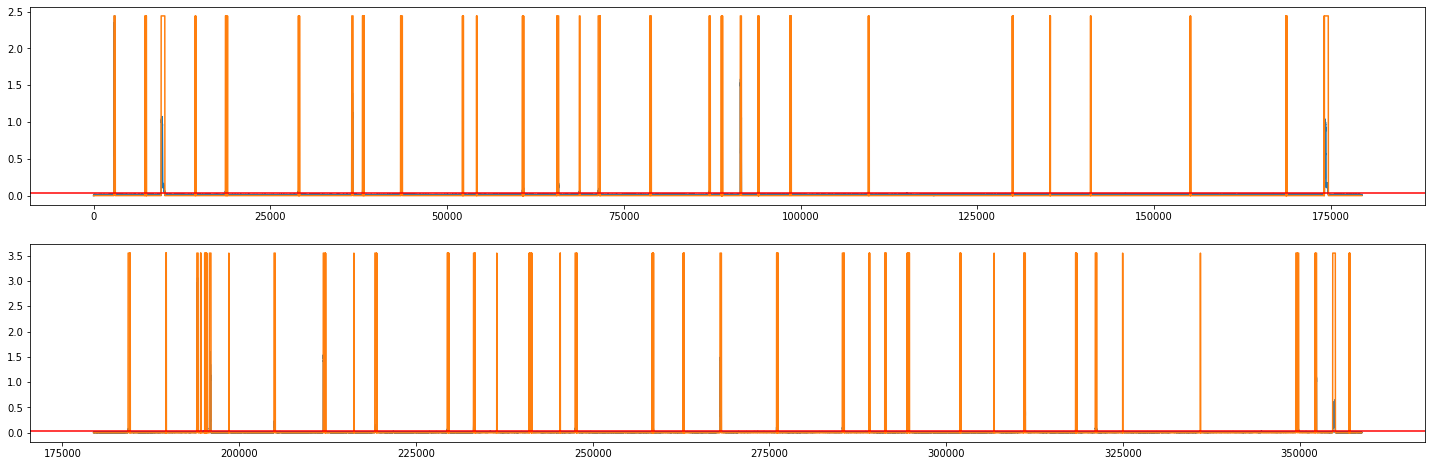

submission saved
epoch :  31
4987/4987 - 230s - loss: 3.8335e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  31   score :  0.9598445145172334294605004664   TH_ :  0.033400000000000006
model save :  HAI_predict_3_6_epoch_31.h5


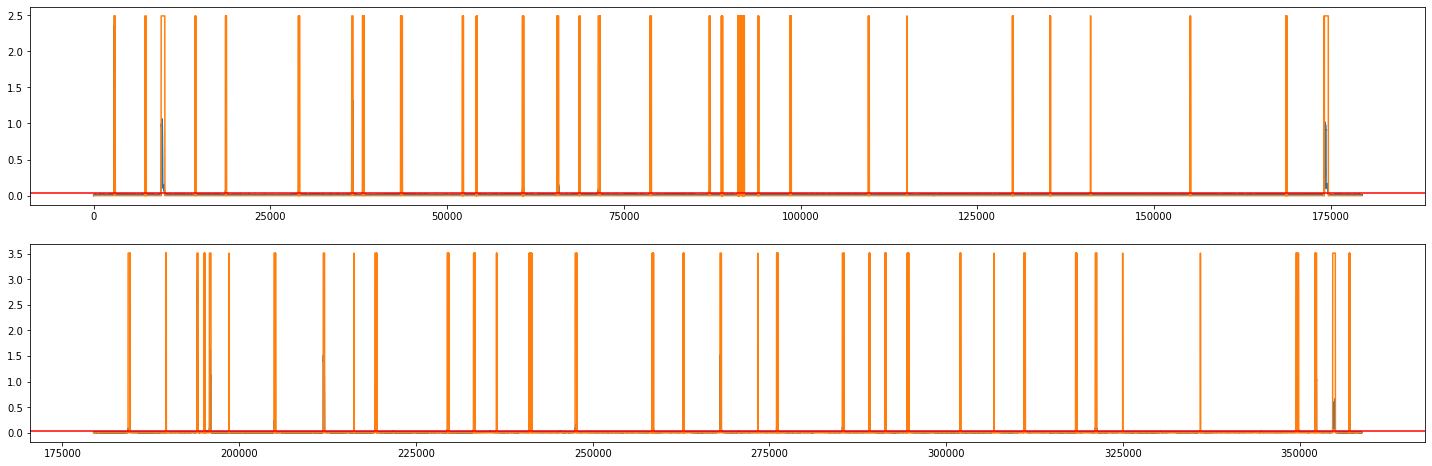

submission saved
epoch :  32
4987/4987 - 224s - loss: 3.8235e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  32   score :  0.9516733902354939797179482856   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_32.h5


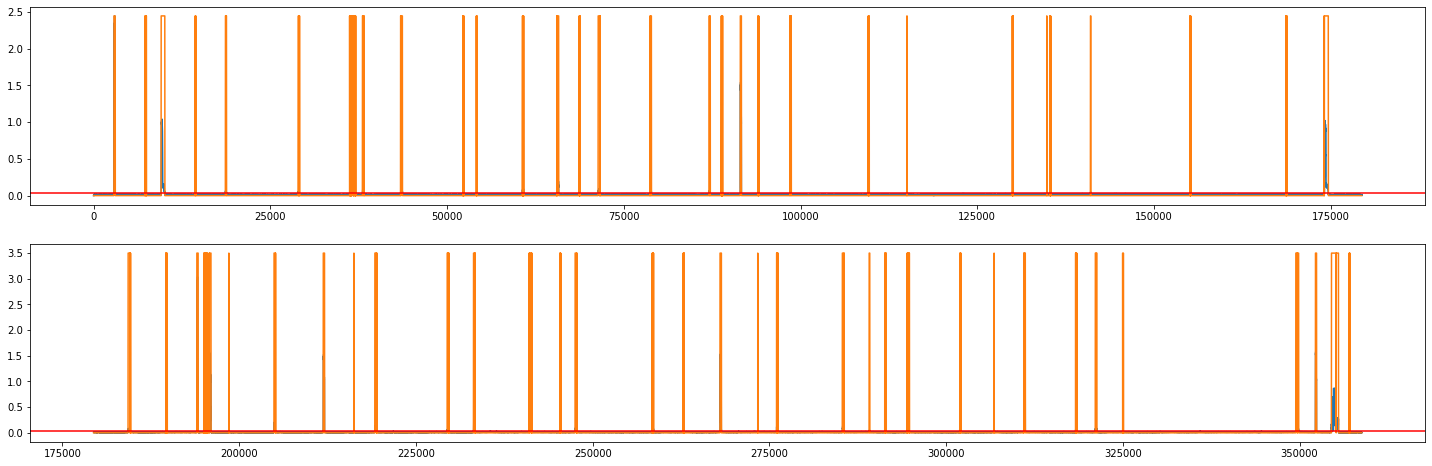

submission saved
epoch :  33
4987/4987 - 230s - loss: 3.7703e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  33   score :  0.9589680863542382460781797824   TH_ :  0.030700000000000005
model save :  HAI_predict_3_6_epoch_33.h5


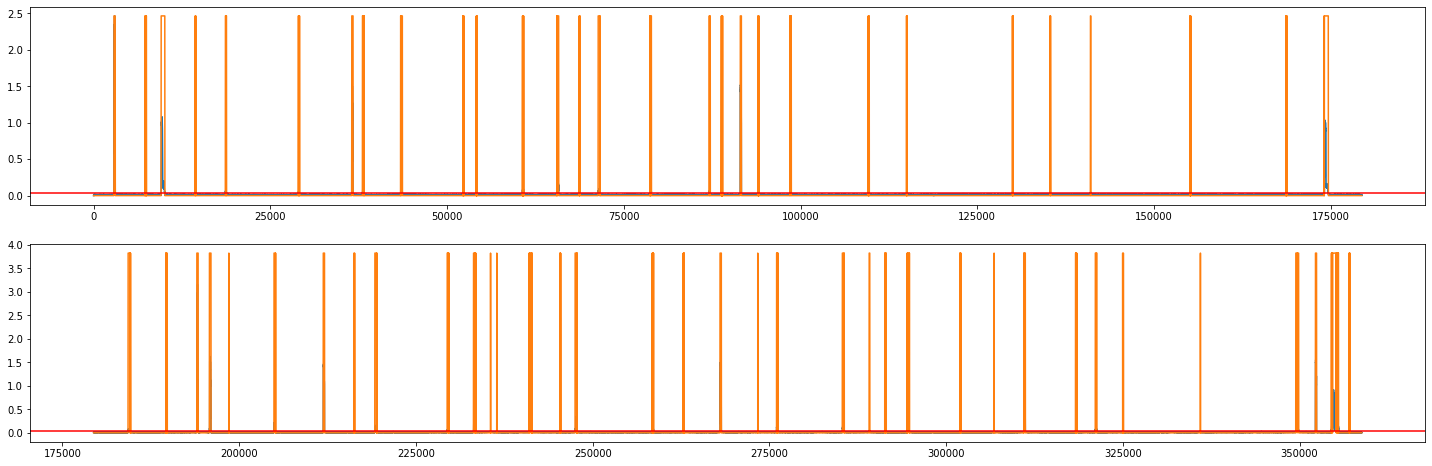

submission saved
epoch :  34
4987/4987 - 228s - loss: 3.7626e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  34   score :  0.9585692454791937821269912123   TH_ :  0.0316
model save :  HAI_predict_3_6_epoch_34.h5


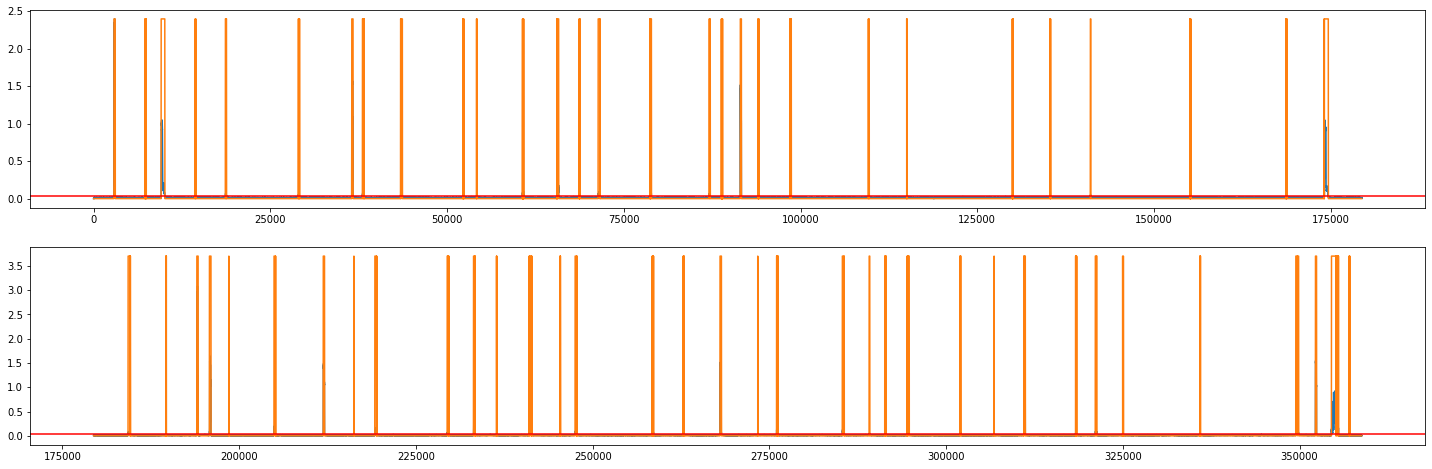

submission saved
epoch :  35
4987/4987 - 230s - loss: 3.7556e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9353464637031812767969149747
epoch :  36
4987/4987 - 227s - loss: 3.7281e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  36   score :  0.9575295820600201769359056055   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_36.h5


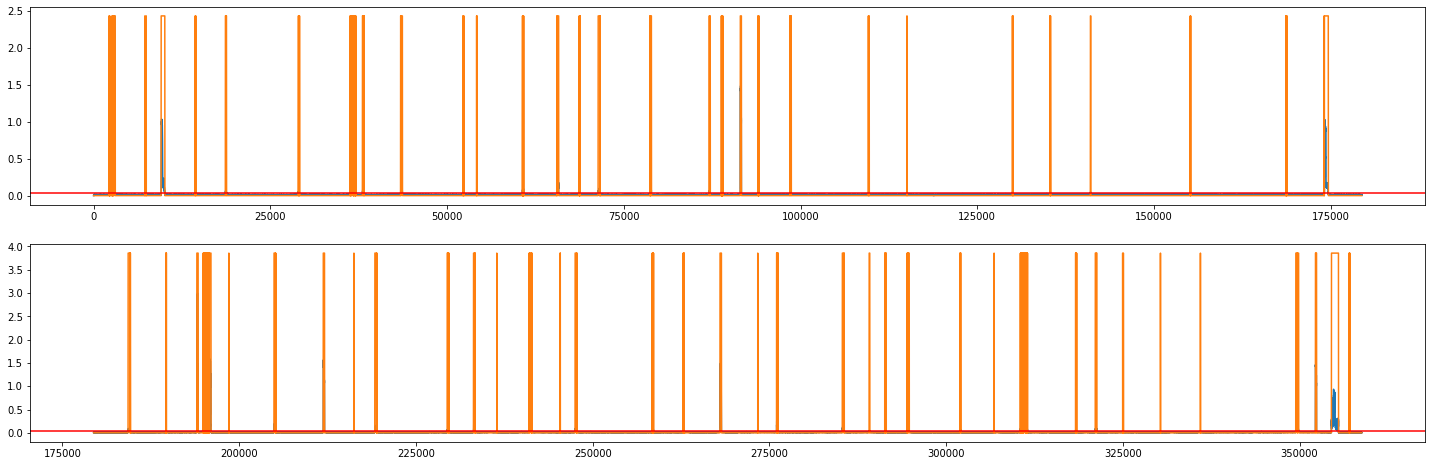

submission saved
epoch :  37
4987/4987 - 221s - loss: 3.7116e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  37   score :  0.9539768269533451020161617713   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_37.h5


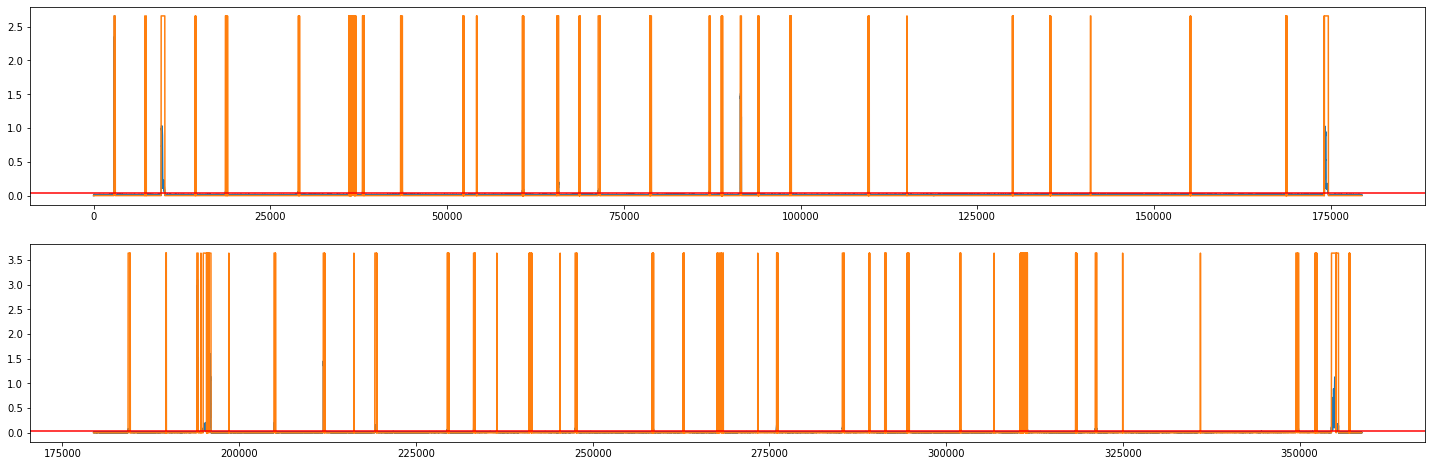

submission saved
epoch :  38
4987/4987 - 226s - loss: 3.6861e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  38   score :  0.9589256884612378067028986752   TH_ :  0.03250000000000001
model save :  HAI_predict_3_6_epoch_38.h5


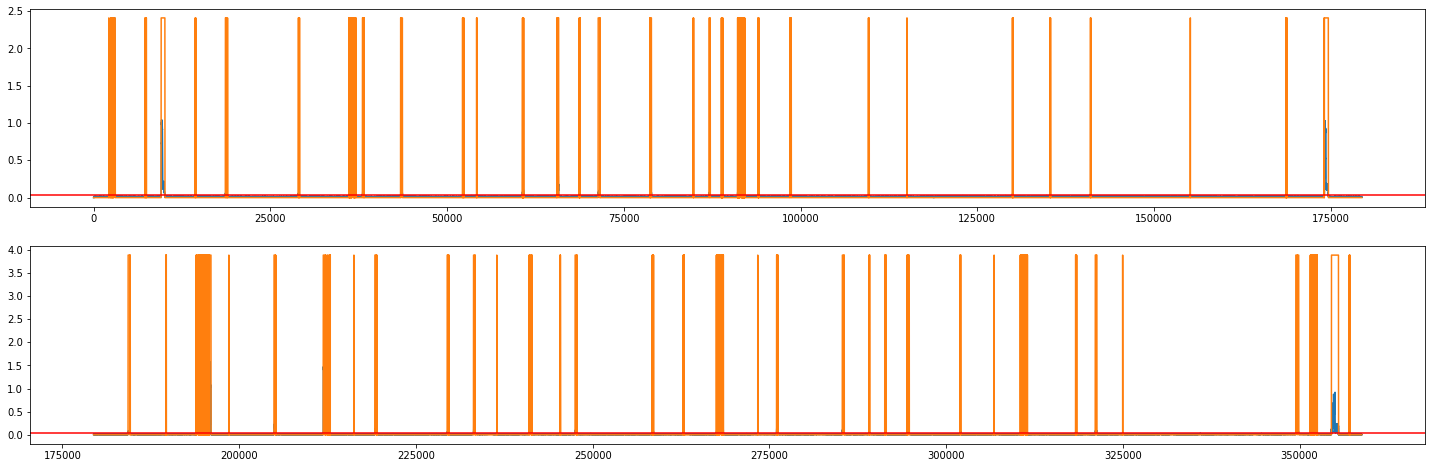

submission saved
epoch :  39
4987/4987 - 228s - loss: 3.6739e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  39   score :  0.9609769155174039656974676314   TH_ :  0.0316
model save :  HAI_predict_3_6_epoch_39.h5


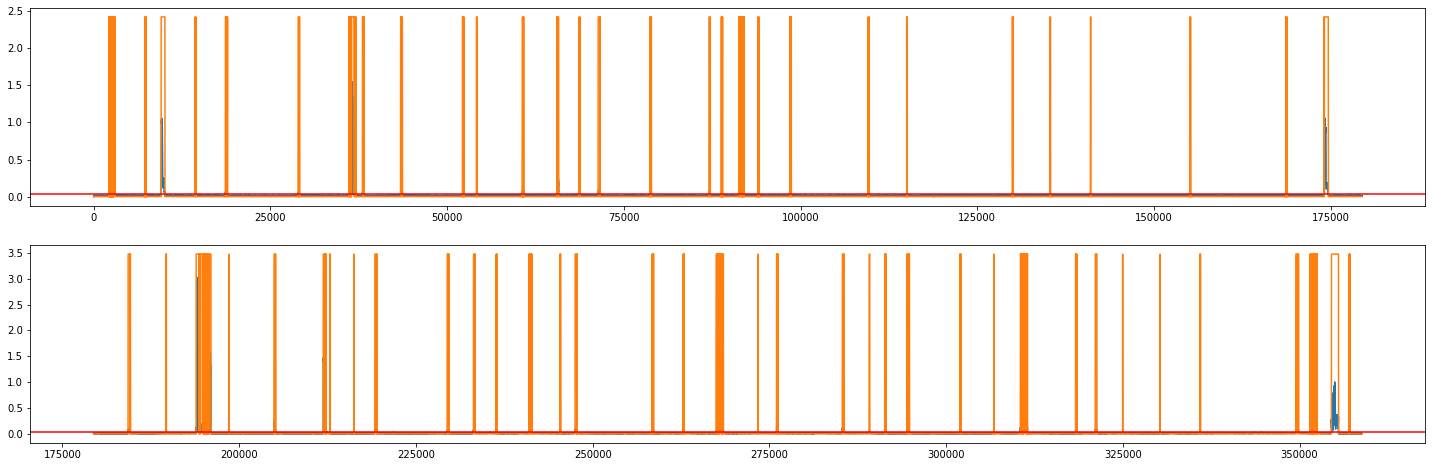

submission saved
epoch :  40
4987/4987 - 226s - loss: 3.6632e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_6   epoch :  40   score :  0.9676444715439312520439386218   TH_ :  0.0316
model save :  HAI_predict_3_6_epoch_40.h5


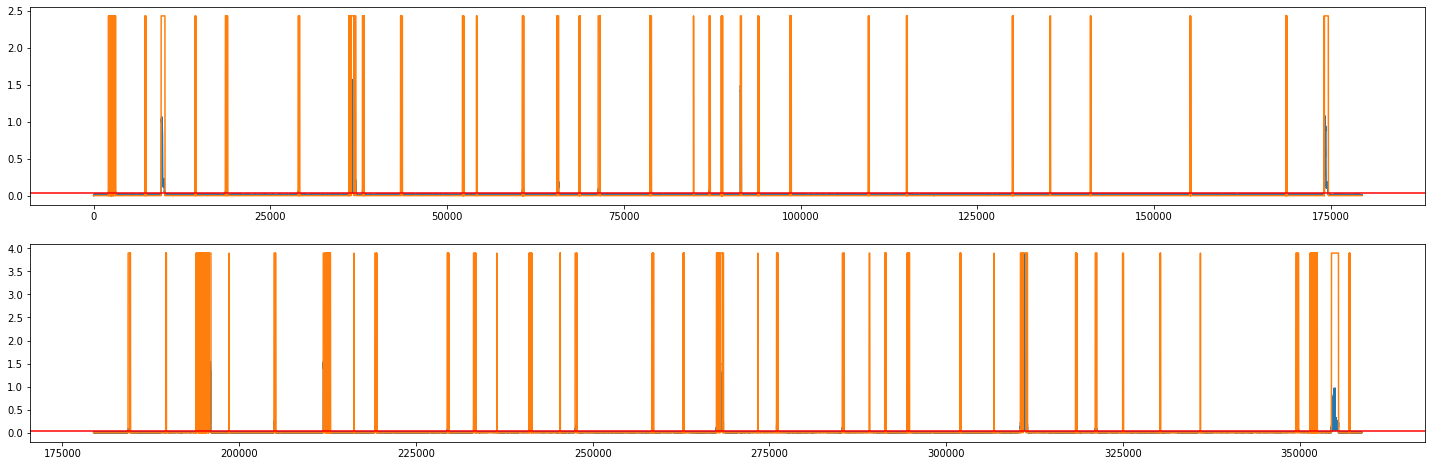

submission saved
epoch :  41
4987/4987 - 228s - loss: 3.6281e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_7
epoch :  0
4987/4987 - 371s - loss: 0.0027
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9225735647730507240962480421
epoch :  1
4987/4987 - 378s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9316808223464190873335727362
epoch :  2
4987/4987 - 377s - loss: 8.5732e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9245560110131233208585290832
epoch :  3
4987/4987 - 373s - loss: 7.6182e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_7   epoch :  3   score :  0.9540624337593212956145809748   TH_ :  0.043300000000000005
model save :  HAI_predict_3_7_epoch_3.h5


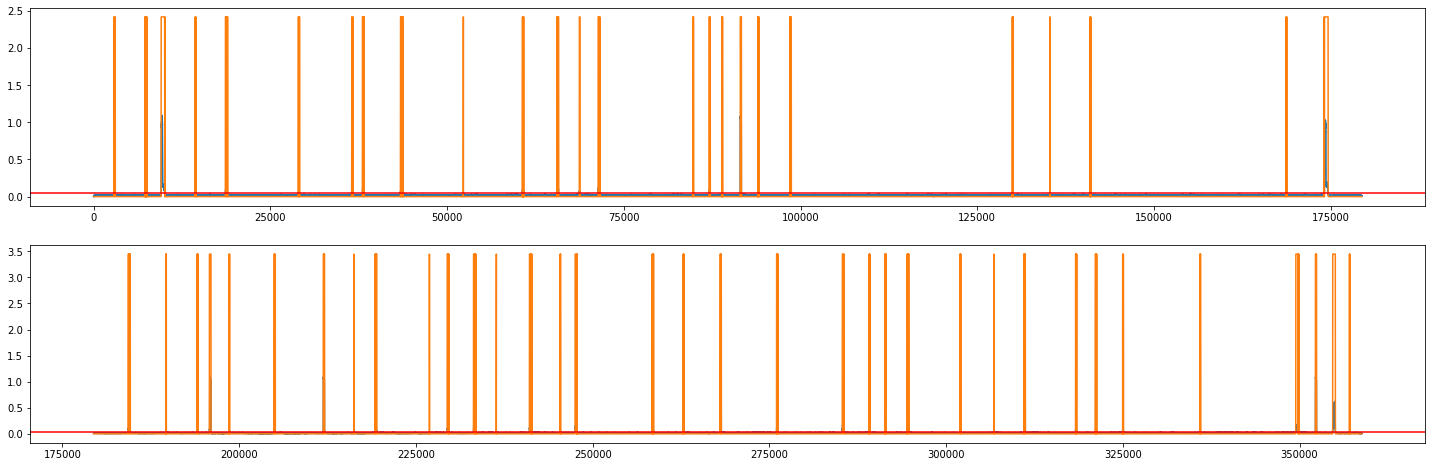

submission saved
epoch :  4
4987/4987 - 378s - loss: 6.9073e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9400963300967598944340613595
epoch :  5
4987/4987 - 378s - loss: 6.7021e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9465153126585814437599775475
epoch :  6
4987/4987 - 372s - loss: 6.3940e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9495692368867194602099037318
epoch :  7
4987/4987 - 378s - loss: 5.7435e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8539933500031007948214868512
epoch :  8
4987/4987 - 375s - loss: 5.0601e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9310763617292742025327655388
epoch :  9
4987/4987 - 376s - loss: 5.5627e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9173180077661874707142487618
epoch :  10
4987/4987 - 371s - loss: 6.7461e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7701275496100441444942984308
epoch :  11
4987/4987 - 374s - loss: 5.2637e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8867717248630405460558475471
epoch :  12
4987/4987 - 374s - loss: 5.0607e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9064448111526325925648883762
epoch :  13
4987/4987 - 353s - loss: 4.8759e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9461538409775028535394557265
epoch :  14
4987/4987 - 343s - loss: 4.7602e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8873171788203294532235921883
epoch :  15
4987/4987 - 346s - loss: 4.6910e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9086872029915965175936508009
epoch :  16
4987/4987 - 342s - loss: 4.5961e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8965689712876892086462334178
epoch :  17
4987/4987 - 343s - loss: 4.5945e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9344167670566666061200129121
epoch :  18
4987/4987 - 342s - loss: 4.5468e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9358767187892061363888873522
epoch :  19
4987/4987 - 342s - loss: 4.4237e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8898111257710459214687514522
epoch :  20
4987/4987 - 343s - loss: 4.3962e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9439674451751943203102893266
epoch :  21
4987/4987 - 344s - loss: 4.3235e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8703840759095324004741026961
epoch :  22
4987/4987 - 345s - loss: 4.2844e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9192589935837869381394022580
epoch :  23
4987/4987 - 344s - loss: 4.2512e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8795524414120268359619038906
epoch :  24
4987/4987 - 344s - loss: 4.2284e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8854020214772170343677914470
epoch :  25
4987/4987 - 345s - loss: 4.1651e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8989216410442915813094020155
epoch :  26
4987/4987 - 348s - loss: 4.1761e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_7   epoch :  26   score :  0.9515309975765021842077363187   TH_ :  0.0397
model save :  HAI_predict_3_7_epoch_26.h5


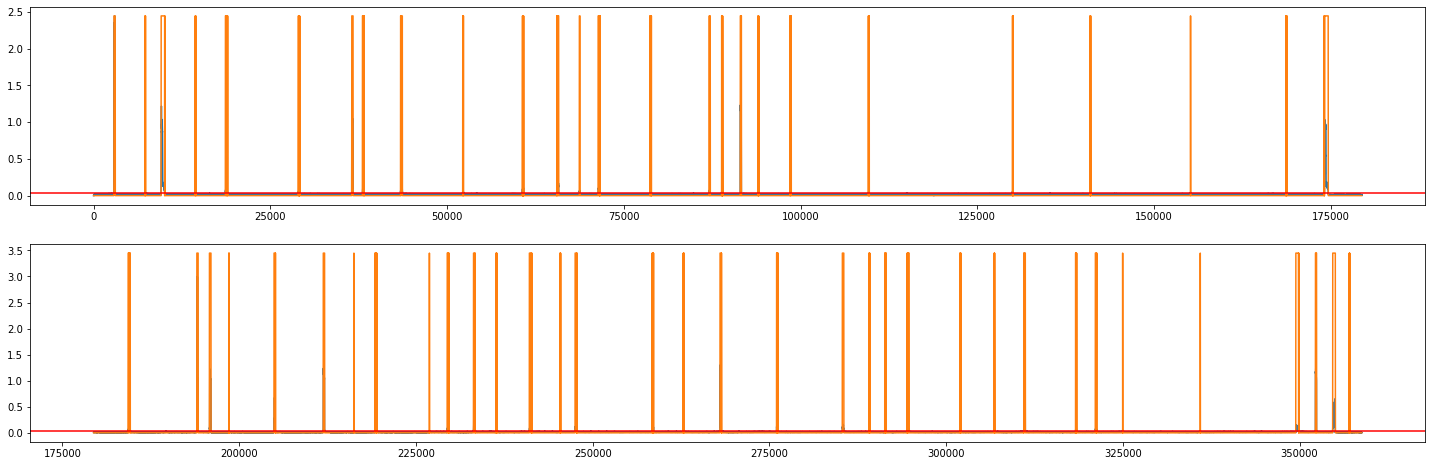

submission saved
epoch :  27
4987/4987 - 347s - loss: 4.1188e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9380230951026189255542405989
epoch :  28
4987/4987 - 344s - loss: 4.0821e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9405194668484626720207547509
epoch :  29
4987/4987 - 345s - loss: 4.0503e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_7   epoch :  29   score :  0.9534895059307580801527929026   TH_ :  0.0397
model save :  HAI_predict_3_7_epoch_29.h5


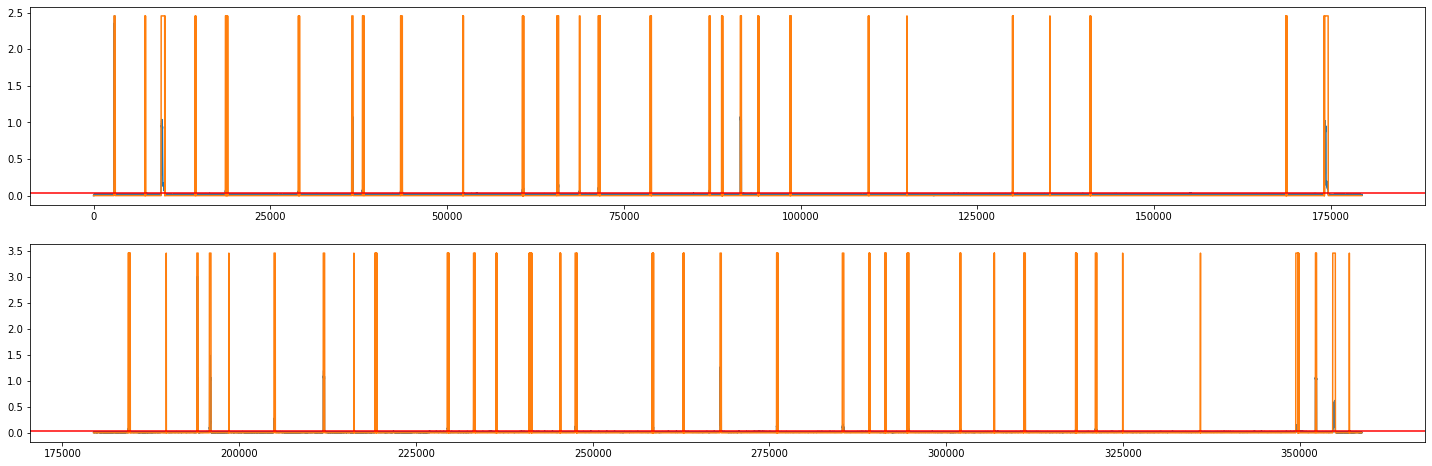

submission saved
epoch :  30
4987/4987 - 343s - loss: 4.0561e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_7   epoch :  30   score :  0.9580633057903005141266196380   TH_ :  0.0388
model save :  HAI_predict_3_7_epoch_30.h5


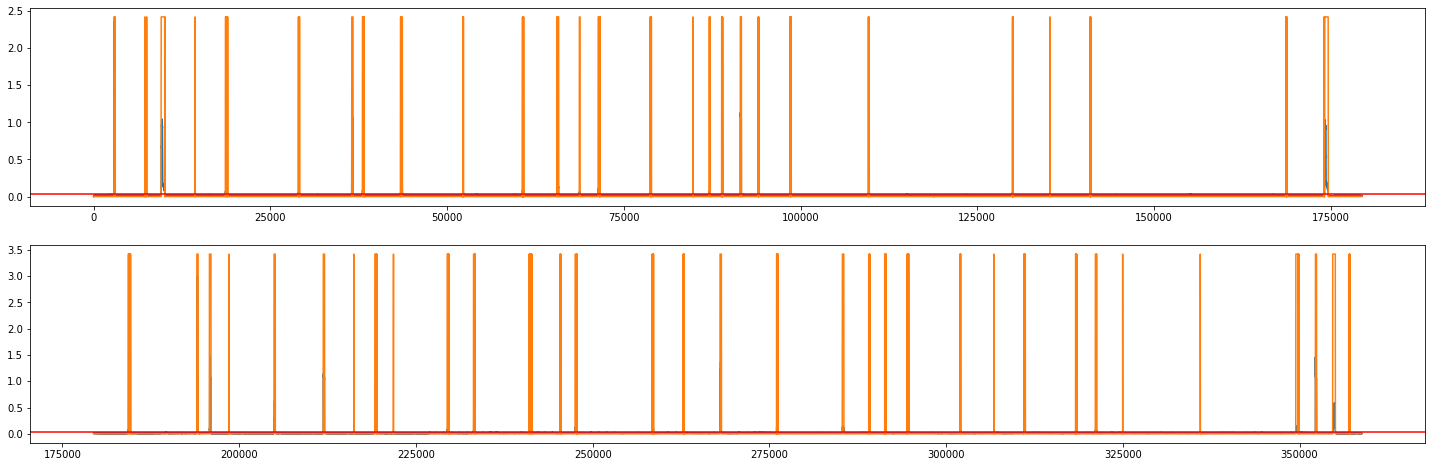

submission saved
epoch :  31
4987/4987 - 343s - loss: 3.9721e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_7   epoch :  31   score :  0.9652259259193956514050556155   TH_ :  0.0397
model save :  HAI_predict_3_7_epoch_31.h5


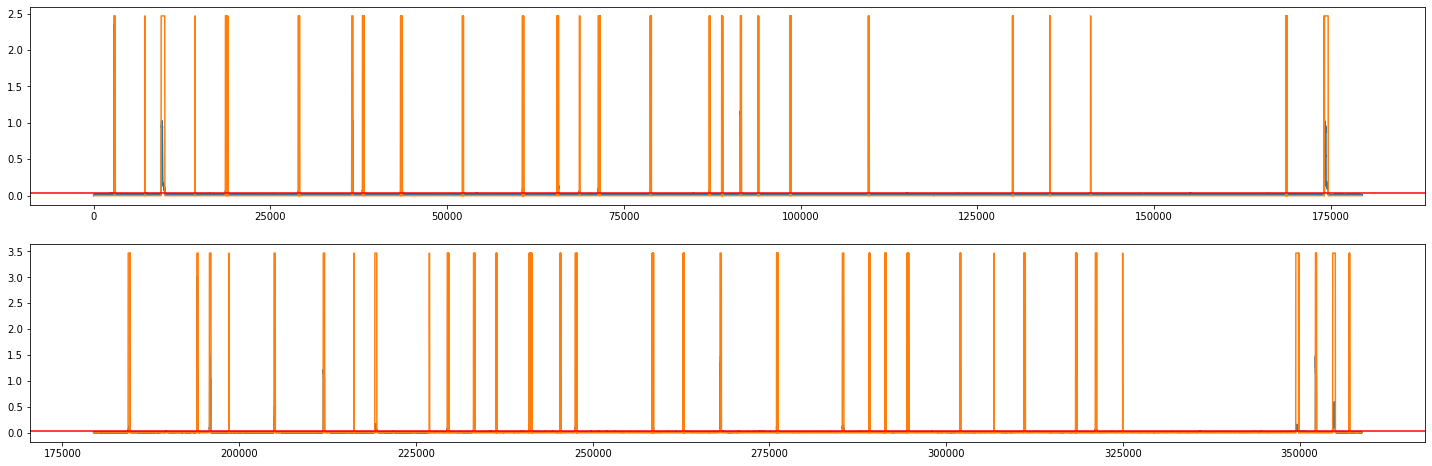

submission saved
epoch :  32
4987/4987 - 344s - loss: 3.9542e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_3_8
epoch :  0
4987/4987 - 459s - loss: 0.0028
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9238168415788838433677519975
epoch :  1
4987/4987 - 460s - loss: 0.0011
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9203903430409926980155610394
epoch :  2
4987/4987 - 460s - loss: 8.8281e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8889941169909773122920974062
epoch :  3
4987/4987 - 459s - loss: 7.6400e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9145770139146719452327138905
epoch :  4
4987/4987 - 459s - loss: 6.1142e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  4   score :  0.9570325146886350461721535643   TH_ :  0.040600000000000004
model save :  HAI_predict_3_8_epoch_4.h5


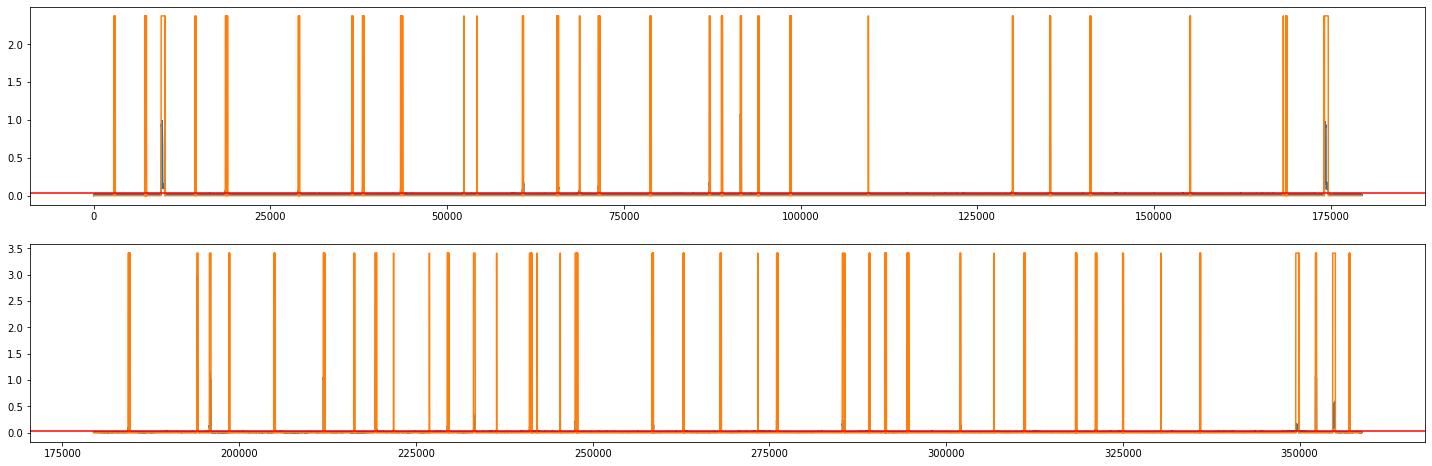

submission saved
epoch :  5
4987/4987 - 459s - loss: 5.5305e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9449935064056657827765998736
epoch :  6
4987/4987 - 458s - loss: 5.2705e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  6   score :  0.9637691180010165015143887259   TH_ :  0.0388
model save :  HAI_predict_3_8_epoch_6.h5


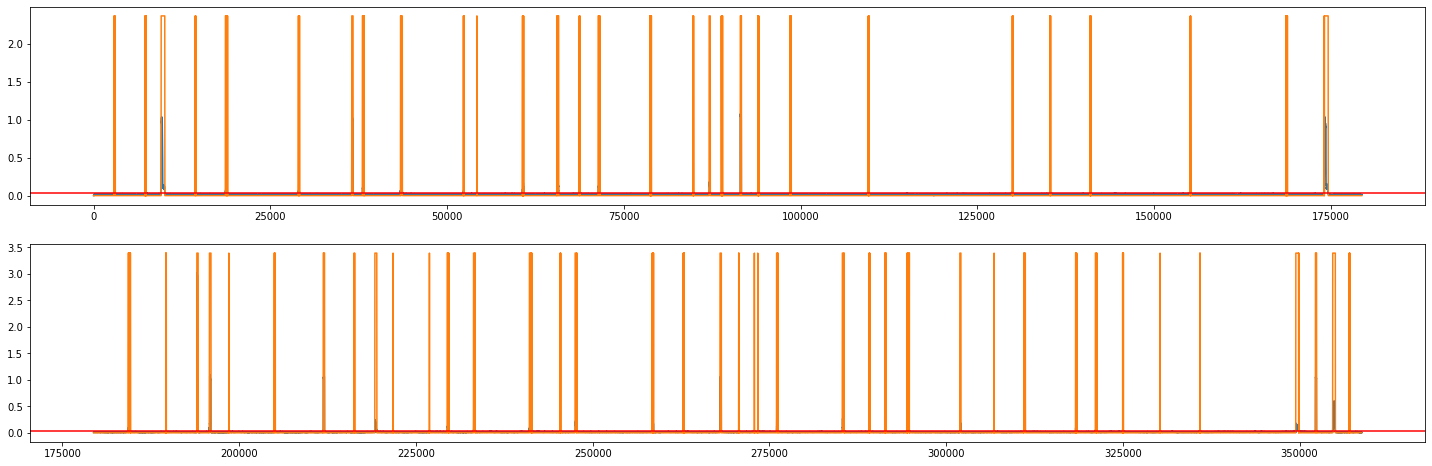

submission saved
epoch :  7
4987/4987 - 458s - loss: 5.0912e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  7   score :  0.9699440023033799146586528263   TH_ :  0.0352
model save :  HAI_predict_3_8_epoch_7.h5


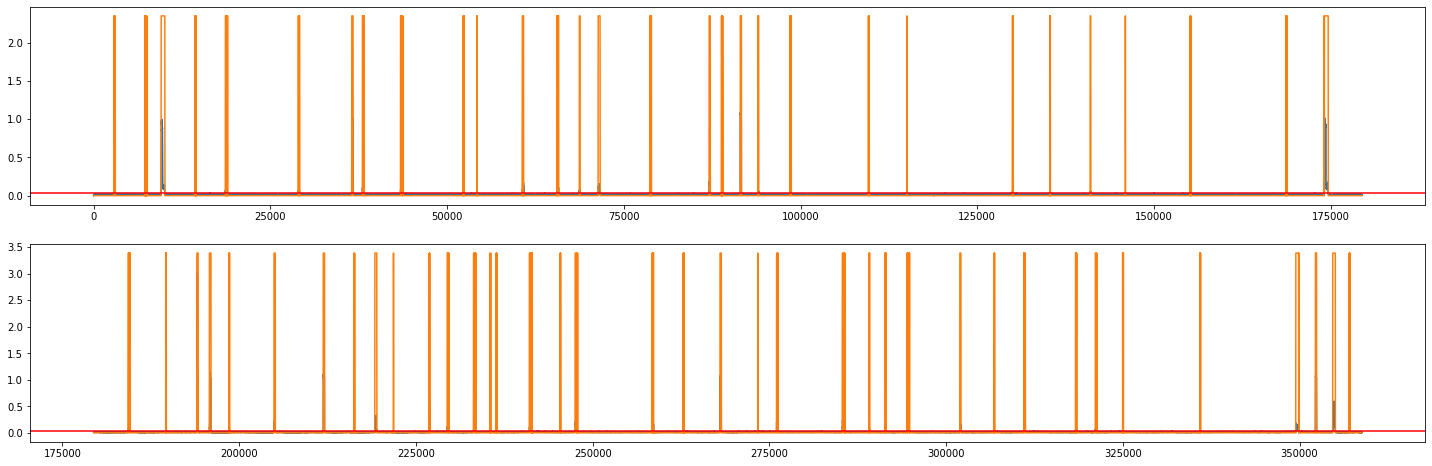

submission saved
epoch :  8
4987/4987 - 465s - loss: 5.0093e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  8   score :  0.9592874107111237842236703077   TH_ :  0.034300000000000004
model save :  HAI_predict_3_8_epoch_8.h5


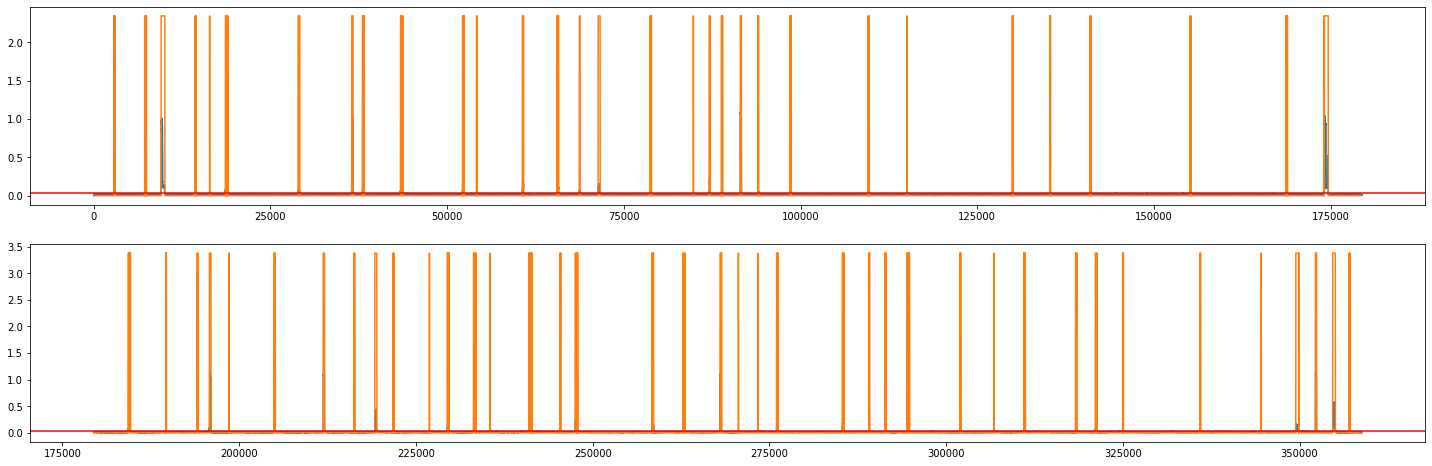

submission saved
epoch :  9
4987/4987 - 468s - loss: 4.8475e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  9   score :  0.9695163221269652260122255369   TH_ :  0.0379
model save :  HAI_predict_3_8_epoch_9.h5


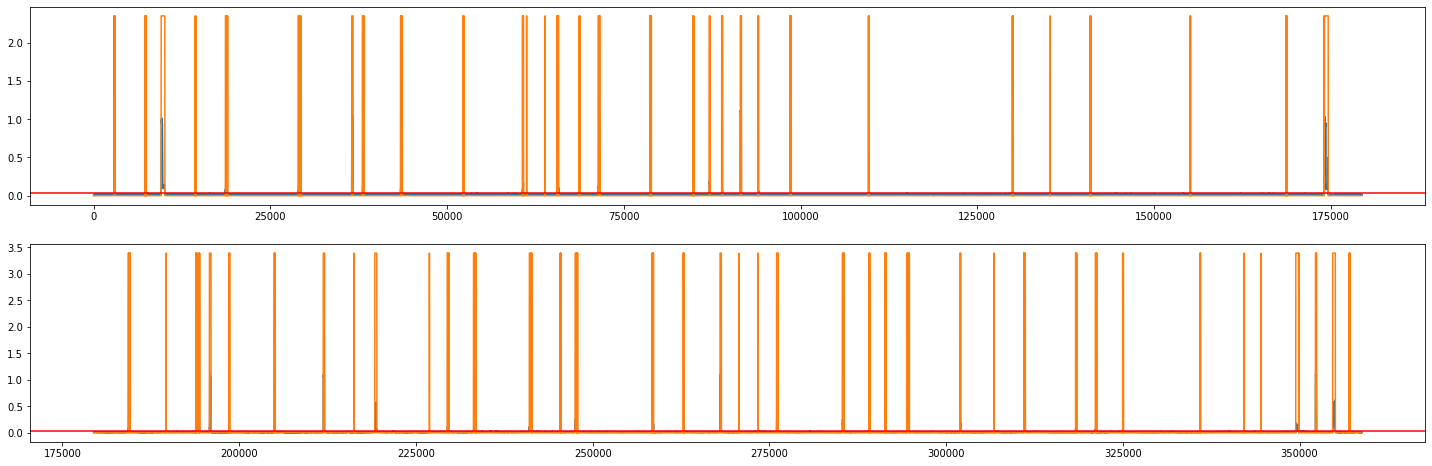

submission saved
epoch :  10
4987/4987 - 470s - loss: 4.7633e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  10   score :  0.9627574574194374470780869780   TH_ :  0.037000000000000005
model save :  HAI_predict_3_8_epoch_10.h5


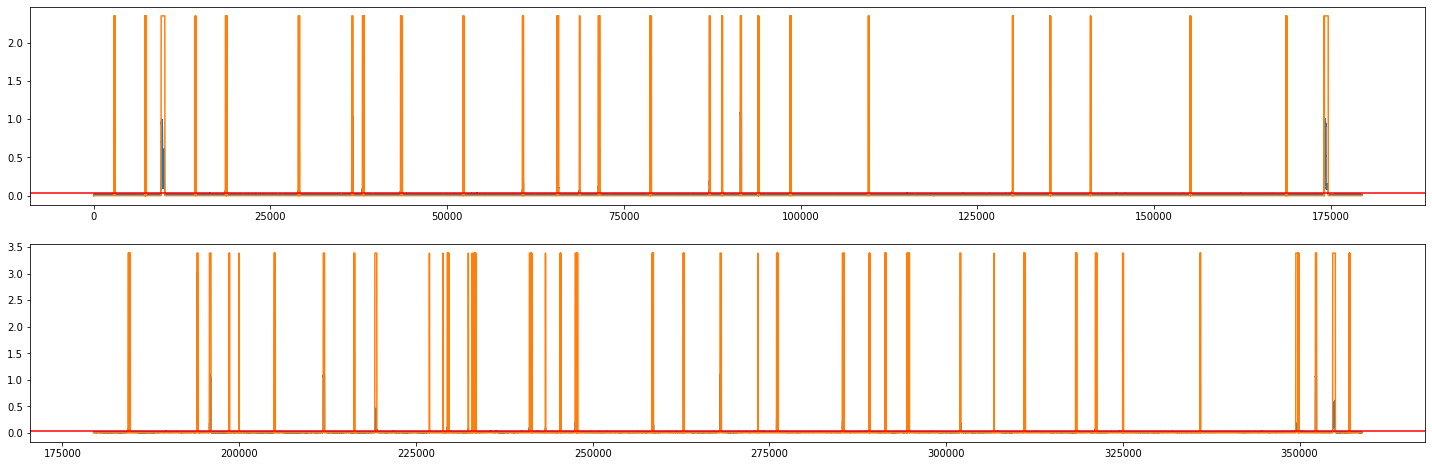

submission saved
epoch :  11
4987/4987 - 469s - loss: 5.2801e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  11   score :  0.9621393674112875241619161143   TH_ :  0.0352
model save :  HAI_predict_3_8_epoch_11.h5


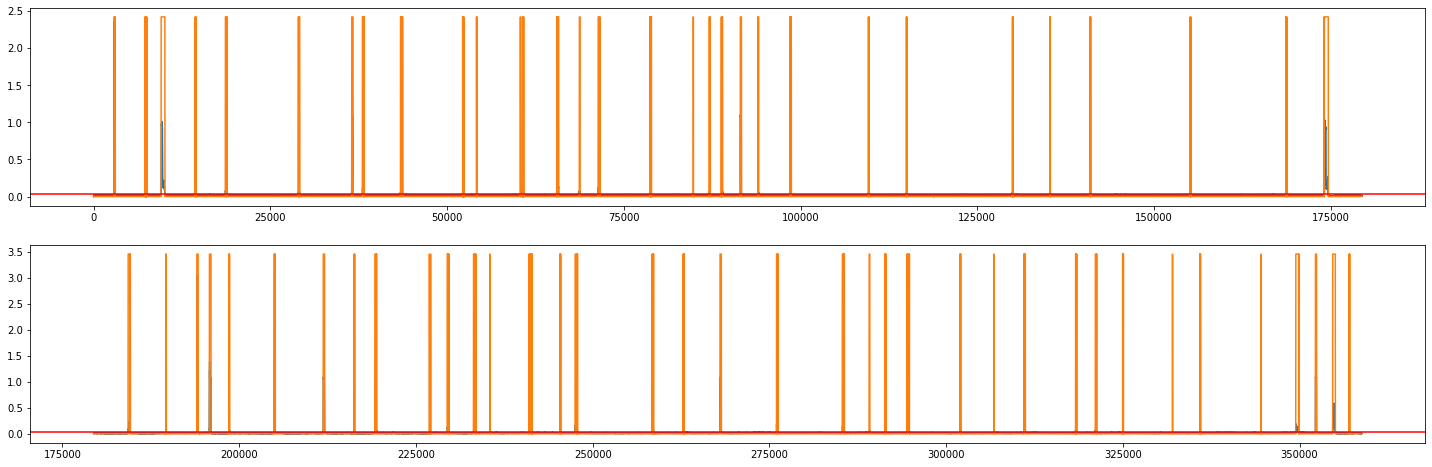

submission saved
epoch :  12
4987/4987 - 468s - loss: 4.6871e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  12   score :  0.9627131549586305597649977368   TH_ :  0.0379
model save :  HAI_predict_3_8_epoch_12.h5


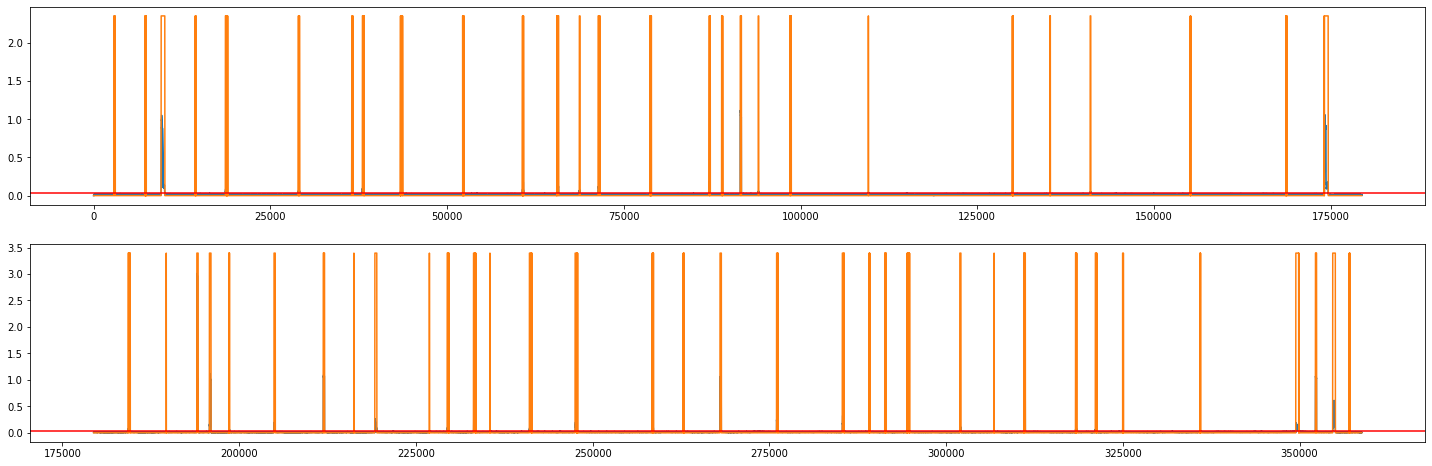

submission saved
epoch :  13
4987/4987 - 466s - loss: 4.6520e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9471851604843556162272170123
epoch :  14
4987/4987 - 469s - loss: 4.5329e-04
checking for TaPR...


Progress:[==============================] 100.0%

I see hope in this model :  HAI_predict_3_8   epoch :  14   score :  0.9517675256045661524205483608   TH_ :  0.033400000000000006
model save :  HAI_predict_3_8_epoch_14.h5


In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if e > 25 and score < 0.93:
                print('This model has failed \n Skip to next model')
                break
            elif score < 0.95:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')


generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Test4 - CNN
-------------

In [ ]:
Modelname = 'HAI_predict_4'  # CNN 은 (batch, timelen, features, 1) 꼴로 reshape 해줘야 한다.

In [ ]:
# 이거 먹이면 기본함수도 다시 먹여줘야 한다.
########################################################################################### data preparation basic functions
class Test_DataLoader(keras.utils.Sequence):  # timegen 하나가 X 값만 뽑아줄 수 있도록 한다.
    def __init__(self,test_seq):
        self.test_seq = test_seq
    def __getitem__(self, i):
        return self.test_seq[i][0].reshape((-1,timelen,79,1))
    def __len__(self):
        return len(self.test_seq)

# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target[0].reshape((-1,timelen,79,1)), target[1]     # reshaped X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

def read_data(path, att = False, scaler = None, C_cols = None, demand_validation_ratio = None):
    file_paths = glob.glob(path+'/*.csv')
    res = []
    print("="*30)
    print("Attack :",att)
    if att and scaler and C_cols:
        label = None
        temp = 0
        for file in file_paths:
            f = pd.read_csv(file)
            temp += len(f)
            if 'attack' in f.columns:
                label = f['attack']
            res.append(scaler.transform(f[C_cols].values))
        print("Total test data : ", temp)
        print("List of DataFrame length : ",len(res))
        return res, label
    else:
        # df : appended dataframe to fit scaler
        df = pd.DataFrame()
        for file in file_paths:
            f=pd.read_csv(file)
            df = df.append(f, ignore_index=True)
            res.append(f)
        print("Total data length (including non-usable datas) : ",len(df))
        # make C01 ~ C79 list
        C_cols = list(df.columns)
        C_cols.remove('time')
        # make scaler
        scaler = MinMaxScaler()
        scaler.fit(df[C_cols].values)
        temp = 0
        for i, item in enumerate(res):
            res[i] = scaler.transform(item[C_cols].values)
            temp += len(res[i])
        print("List of DataFrame length : ",len(res))
        return res, C_cols, scaler

train_list, C_cols, scaler = read_data(path_train)
valid_list, valid_label = read_data(path_valid, att=True, scaler = scaler, C_cols = C_cols)
test_list, _ = read_data(path_test, att=True, scaler = scaler, C_cols = C_cols)
print(train_list[0].shape, valid_list[0].shape, valid_label.shape, test_list[0].shape)

def seq2timeser(some_list,sr,st,le,ba,sh):
    res = []
    for item in some_list:
        res.append( TimeseriesGenerator(item, item, sampling_rate = sr, stride = st, length = le, batch_size=ba, shuffle = sh) )
    return res

train_list_seq = seq2timeser(train_list, 1, stride, timelen, batch_size, True)
valid_list_seq = seq2timeser(valid_list, 1, 1, timelen, 1000, False)
test_list_seq = seq2timeser(test_list, 1, 1, timelen, 1000, False)
train = Train_DataLoader(train_list_seq)

Attack : False
Total data length (including non-usable datas) :  921603
List of DataFrame length :  3
Attack : True
Total test data :  43201
List of DataFrame length :  1
Attack : True
Total test data :  358804
List of DataFrame length :  4
(216001, 79) (43201, 79) (43201,) (118801, 79)


In [ ]:
def model1():
    cnn = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(timelen,79,1),pooling=None)
    #  width and height should be no smaller than 32.
    mid = layers.GlobalAveragePooling2D()(cnn.output)
    mid = layers.Dense(128, activation = 'relu')(mid)
    out = layers.Dense(79, activation = 'relu')(mid)
    model = keras.Model(inputs = cnn.input, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    return model

def model2():
    cnn = tf.keras.applications.InceptionResNetV2(include_top=False, weights=None, input_tensor=None, input_shape=(timelen,79,1),pooling=None)
    #  width and height should be no smaller than 75.
    mid = layers.GlobalAveragePooling2D()(cnn.output)
    mid = layers.Dense(128, activation = 'relu')(mid)
    out = layers.Dense(79, activation = 'relu')(mid)
    model = keras.Model(inputs = cnn.input, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    return model

def model3():
    cnn = tf.keras.applications.EfficientNetB5(include_top=False, weights=None, input_tensor=None, input_shape=(timelen,79,1),pooling=None)
    # no information found
    mid = layers.GlobalAveragePooling2D()(cnn.output)
    mid = layers.Dense(128, activation = 'relu')(mid)
    out = layers.Dense(79, activation = 'relu')(mid)
    model = keras.Model(inputs = cnn.input, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    return model
    

def model4():
    cnn = tf.keras.applications.Xception(include_top=False, weights=None, input_tensor=None, input_shape=(timelen,79,1),pooling=None)
    # width and height should be no smaller than 71
    mid = layers.GlobalAveragePooling2D()(cnn.output)
    mid = layers.Dense(128, activation = 'relu')(mid)
    out = layers.Dense(79, activation = 'relu')(mid)
    model = keras.Model(inputs = cnn.input, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    return model


models = [model1(), model2(),  model3(), model4()]
Modelnames = [Modelname + '_' + str(i+1) for i in range(len(models))]

In [ ]:
# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if e > 25 and score < 0.93:
                print('This model has failed \n Skip to next model')
                break
            elif score < 0.96:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')


generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Starting to train  HAI_predict_4_1
epoch :  0
4987/4987 - 168s - loss: 0.0383
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1054344072205472584392074473
epoch :  1
4987/4987 - 169s - loss: 0.0199
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.4818693228915977027790327804
epoch :  2
4987/4987 - 169s - loss: 0.0187
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6843517216119750235428368966
epoch :  3
4987/4987 - 169s - loss: 0.0184
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6639420663447211611573677985
epoch :  4
4987/4987 - 169s - loss: 0.0183
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6743529840268568327055272600
epoch :  5
4987/4987 - 169s - loss: 0.0182
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6729813211097051578767503869
epoch :  6
4987/4987 - 169s - loss: 0.0182
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6760460990880439618540200724
epoch :  7
4987/4987 - 169s - loss: 0.0182
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6749657903106879629388931057
epoch :  8
4987/4987 - 169s - loss: 0.0172
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6731663649926520821040864946
epoch :  9
4987/4987 - 169s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6787045861261082551838957975
epoch :  10
4987/4987 - 169s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6652160940250281391540452287
epoch :  11
4987/4987 - 168s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6724840245983511476759675458
epoch :  12
4987/4987 - 168s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6807796172943889369151181560
epoch :  13
4987/4987 - 168s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6828418870908428437104263371
epoch :  14
4987/4987 - 167s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6831425342732542856774761419
epoch :  15
4987/4987 - 168s - loss: 0.0156
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6843128729419914200528278635
epoch :  16
4987/4987 - 168s - loss: 0.0145
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6733861598144121552322833315
epoch :  17
4987/4987 - 166s - loss: 0.0131
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6759146950705985472438815329
epoch :  18
4987/4987 - 168s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6657859033629098101824961085
epoch :  19
4987/4987 - 167s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6795722138676486527210688519
epoch :  20
4987/4987 - 167s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6601179136273148161811998630
epoch :  21
4987/4987 - 167s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6653206719522796649032885428
epoch :  22
4987/4987 - 168s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6664948061582930057825580933
epoch :  23
4987/4987 - 168s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6666234176714860629091362182
epoch :  24
4987/4987 - 168s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6613399156527179771893394463
epoch :  25
4987/4987 - 168s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6645211643738614427275140330
epoch :  26
4987/4987 - 167s - loss: 0.0130
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_4_2
epoch :  0
4987/4987 - 366s - loss: 0.0166
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.02447801731454761511893101591
epoch :  1
4987/4987 - 366s - loss: 0.0111
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1217831215660936216714148756
epoch :  2
4987/4987 - 366s - loss: 0.0096
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2622576639690152783862420139
epoch :  3
4987/4987 - 363s - loss: 0.0165
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.04738650822225929884224620240
epoch :  4
4987/4987 - 365s - loss: 0.0133
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2332601269701096373607977898
epoch :  5
4987/4987 - 365s - loss: 0.0079
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.05251753124195897654413931196
epoch :  6
4987/4987 - 368s - loss: 0.0067
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3314806404605175943281513883
epoch :  7
4987/4987 - 370s - loss: 0.0089
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5949448001229063929430598423
epoch :  8
4987/4987 - 370s - loss: 0.0095
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1521427786765421248002464492
epoch :  9
4987/4987 - 370s - loss: 0.0102
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5297453931286505274696798395
epoch :  10
4987/4987 - 370s - loss: 0.0072
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3171102575376210172515067962
epoch :  11
4987/4987 - 370s - loss: 0.0072
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.4520252005032721978126256147
epoch :  12
4987/4987 - 366s - loss: 0.0081
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2609634226710366497259429551
epoch :  13
4987/4987 - 370s - loss: 0.0074
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6342207701119598897765186938
epoch :  14
4987/4987 - 370s - loss: 0.0082
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2850364350493882634776361065
epoch :  15
4987/4987 - 371s - loss: 0.0101
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3619300720091065668713472516
epoch :  16
4987/4987 - 370s - loss: 0.0088
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6432967102431718878613280130
epoch :  17
4987/4987 - 370s - loss: 0.0074
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.02624459103167075603108477749
epoch :  18
4987/4987 - 371s - loss: 0.0088
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5875899305107987832103652525
epoch :  19
4987/4987 - 371s - loss: 0.0070
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.02447801731454761511893101591
epoch :  20
4987/4987 - 370s - loss: 0.0070
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5287997939900086618259676321
epoch :  21
4987/4987 - 368s - loss: 0.0098
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7194674464382296327971230942
epoch :  22
4987/4987 - 371s - loss: 0.0072
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2662490967017729014450865887
epoch :  23
4987/4987 - 370s - loss: 0.0065
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09298435824356479543433489164
epoch :  24
4987/4987 - 370s - loss: 0.0076
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2299743848368221829812789658
epoch :  25
4987/4987 - 368s - loss: 0.0089
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.4802525430116366660431379228
epoch :  26
4987/4987 - 370s - loss: 0.0081
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  HAI_predict_4_3
epoch :  0
4987/4987 - 572s - loss: 0.0201
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2549341997460367915005136920
epoch :  1
4987/4987 - 572s - loss: 0.0132
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2630859862621704060788932407
epoch :  2
4987/4987 - 574s - loss: 0.0167
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3950530009670809982505380941
epoch :  3
4987/4987 - 572s - loss: 0.0122
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5504010841512498346601173576
epoch :  4
4987/4987 - 570s - loss: 0.0110
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1355541606445407992489435269
epoch :  5
4987/4987 - 573s - loss: 0.0064
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.4124044720941136850222341049
epoch :  6


KeyboardInterrupt: ignored

Test5 - resnet shape
=========

In [ ]:
Modelname = 'Resnet_shaped'

In [ ]:
def model1():                                   
    inp = layers.Input(shape = (timelen,79))
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(inp)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model2():                                   
    inp = layers.Input(shape = (timelen,79))
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(inp)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model3():                                   
    inp = layers.Input(shape = (timelen,79))
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(inp)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(6):
        if i == 0:
            skip = layers.Dense(256)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model4():                                   
    inp = layers.Input(shape = (timelen,79))
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(inp)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(6):
        if i == 0:
            skip = layers.Dense(256)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(3):
        if i == 0:
            skip = layers.Dense(512)(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(512, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(512)(mid), layers.Dense(512)(mid), layers.Dense(512)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid,_ = layers.Bidirectional(layers.LSTM(512, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(512)(mid), layers.Dense(512)(mid), layers.Dense(512)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model

################################################################################################################################################################################################################

def model5():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model6():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model7():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(6):
        if i == 0:
            skip = layers.Dense(256)(mid)
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model8():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        skip = mid
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([skip, mid, att])

    for i in range(4):
        if i == 0:
            skip = layers.Dense(128)(mid)
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(128, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(128)(mid), layers.Dense(128)(mid), layers.Dense(128)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(6):
        if i == 0:
            skip = layers.Dense(256)(mid)
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(256, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(256)(mid), layers.Dense(256)(mid), layers.Dense(256)(mid)])
            mid = layers.Add()([skip, mid, att])

    for i in range(3):
        if i == 0:
            skip = layers.Dense(512)(mid)
            mid = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(512, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(512)(mid), layers.Dense(512)(mid), layers.Dense(512)(mid)])
            mid = layers.Add()([skip, mid, att])
        else:
            skip = mid
            mid = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(mid)
            mid,_ = layers.Bidirectional(layers.LSTM(512, return_sequences=True), merge_mode=None)(mid)
            att = layers.Attention()([layers.Dense(512)(mid), layers.Dense(512)(mid), layers.Dense(512)(mid)])
            mid = layers.Add()([skip, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model


models = [model1(), model2(), model3(), model4(), model5(), model6(), model7(), model8()]
Modelnames = [Modelname + '_' + str(i+1) for i in range(len(models))]

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional_80 (Bidirectional [(None, 100, 79), (N 100488      input_4[0][0]                    
__________________________________________________________________________________________________
dense_130 (Dense)               (None, 100, 79)      6320        bidirectional_80[0][0]           
__________________________________________________________________________________________________
dense_131 (Dense)               (None, 100, 79)      6320        bidirectional_80[0][0]           
_______________________________________________________________________________________

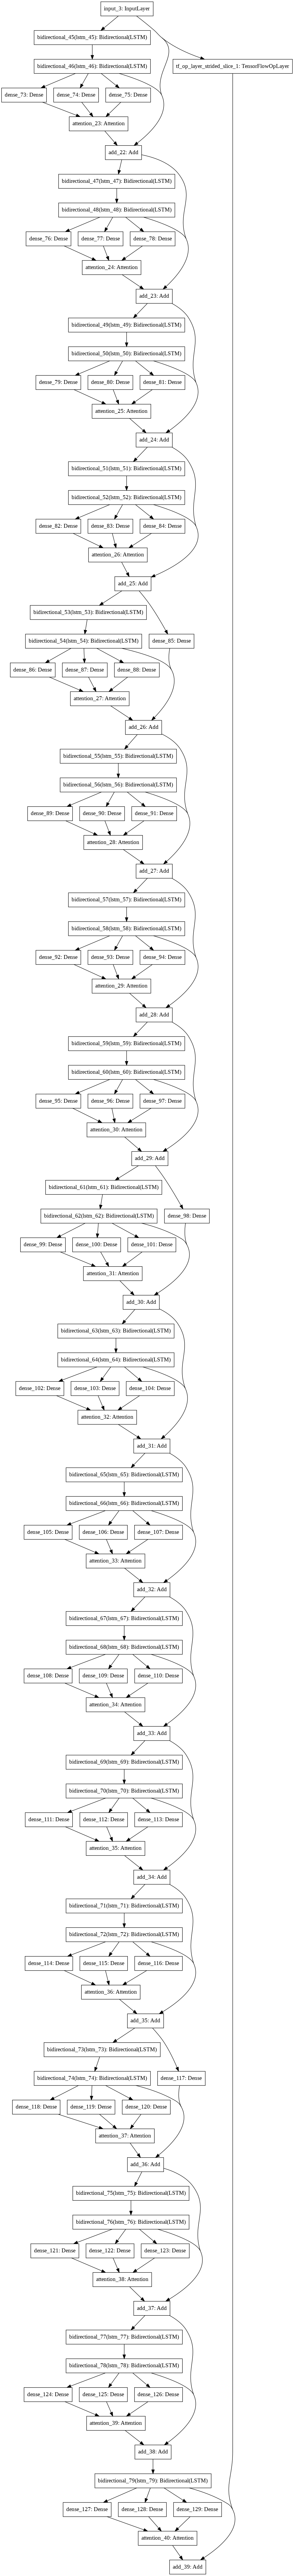

In [ ]:
keras.utils.plot_model(models[-1])

In [ ]:
del models[0]
del Modelnames[0]
Modelnames

['Resnet_shaped_2',
 'Resnet_shaped_3',
 'Resnet_shaped_4',
 'Resnet_shaped_5',
 'Resnet_shaped_6',
 'Resnet_shaped_7',
 'Resnet_shaped_8']

In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if (e > 25 and score < 0.93) or (e > 50 and score < 0.95) or (e > 10 and score < 0.7):
                print('This model has failed \n Skip to next model')
                break
            elif score < 0.97:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')
        tf.keras.backend.clear_session()

generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Starting to train  Resnet_shaped_2
epoch :  0
7480/7480 - 435s - loss: 0.0028
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8175047725975846631858493241
epoch :  1
7480/7480 - 433s - loss: 7.3641e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6521947186749835868844502873
epoch :  2
7480/7480 - 435s - loss: 5.4640e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6605187472365624991188719776
epoch :  3
7480/7480 - 436s - loss: 4.7188e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7484127582072642550665746712
epoch :  4
7480/7480 - 436s - loss: 4.4131e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7407696653520650144541877104
epoch :  5
7480/7480 - 435s - loss: 4.2078e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7372937660056432935081638945
epoch :  6
7480/7480 - 436s - loss: 4.0452e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9345700753262747517572583456
epoch :  7
7480/7480 - 436s - loss: 3.9091e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8617332532737498536276421032
epoch :  8
7480/7480 - 435s - loss: 3.8345e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5162571752146496606596873787
epoch :  9
7480/7480 - 436s - loss: 3.7805e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5034124923134416091479275654
epoch :  10
7480/7480 - 436s - loss: 3.7582e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3959532488006557007012085882
epoch :  11
7480/7480 - 435s - loss: 3.6926e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  Resnet_shaped_3
epoch :  0
7480/7480 - 1598s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09143301387809147574904510588
epoch :  1
7480/7480 - 1592s - loss: 0.0287
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09035529622045943785410474778
epoch :  2
7480/7480 - 1592s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.08969747285997581043209202493
epoch :  3
7480/7480 - 1589s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09033879497945134762158654639
epoch :  4
7480/7480 - 1594s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09114959686091624749049638863
epoch :  5
7480/7480 - 1606s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09189531645001079023363979290
epoch :  6
7480/7480 - 1608s - loss: 0.0284
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09014461661744744944170306125
epoch :  7
7480/7480 - 1613s - loss: 0.0284
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09031599186625568443617781549
epoch :  8
7480/7480 - 1611s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09096566596250354222184360023
epoch :  9
7480/7480 - 1596s - loss: 0.0284
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09090168231909496580882348704
epoch :  10
7480/7480 - 1595s - loss: 0.0284
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09311579318955533986657798494
epoch :  11
7480/7480 - 1593s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  Resnet_shaped_4
epoch :  0
7480/7480 - 2012s - loss: 0.0286
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09015683804268865634159122691
epoch :  1
7480/7480 - 2012s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09191229498281297642921885385
epoch :  2
7480/7480 - 2042s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09150783986683209804361714079
epoch :  3
7480/7480 - 2060s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09121264492586746140624121401
epoch :  4
7480/7480 - 2050s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09036922359499868437771970781
epoch :  5
7480/7480 - 2053s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09093178312506729636156057975
epoch :  6
7480/7480 - 2047s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09183344724365169290521558091
epoch :  7
7480/7480 - 2021s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09120804326573505255411104882
epoch :  8
7480/7480 - 2017s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09054878298494149640046789111
epoch :  9
7480/7480 - 2024s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09076498733600538248707377805
epoch :  10
7480/7480 - 2033s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.09016717113606826266743214729
epoch :  11
7480/7480 - 2043s - loss: 0.0285
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  Resnet_shaped_5
epoch :  0
7480/7480 - 535s - loss: 0.0023
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8917318369763496631180564686
epoch :  1
7480/7480 - 534s - loss: 6.2796e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9019358684733713867535342109
epoch :  2
7480/7480 - 535s - loss: 4.9111e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7893864362645186651365931759
epoch :  3
7480/7480 - 534s - loss: 4.6355e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.2487507413487371743266097760
epoch :  4
7480/7480 - 535s - loss: 4.3738e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8502908594776290570218490306
epoch :  5
7480/7480 - 535s - loss: 4.1669e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8505247791171594431719408199
epoch :  6
7480/7480 - 535s - loss: 4.0526e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7120475233211250869792468648
epoch :  7
7480/7480 - 534s - loss: 3.9601e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6253818823534275650780215899
epoch :  8
7480/7480 - 534s - loss: 3.8771e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3038619648134768621002752416
epoch :  9
7480/7480 - 534s - loss: 3.7814e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1212721973158610614565411846
epoch :  10
7480/7480 - 534s - loss: 3.7193e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.1034163028297078531656892997
epoch :  11
7480/7480 - 533s - loss: 3.6613e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  Resnet_shaped_6
epoch :  0
7480/7480 - 1164s - loss: 0.0036
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6957520832716109802567748321
epoch :  1
7480/7480 - 1162s - loss: 8.2544e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5303190611566065521089779362
epoch :  2
7480/7480 - 1160s - loss: 5.9997e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6367528219005917019785138397
epoch :  3
7480/7480 - 1163s - loss: 5.1724e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7685323050358211807227533443
epoch :  4
7480/7480 - 1151s - loss: 4.6183e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5998381727060535874882446899
epoch :  5
7480/7480 - 1152s - loss: 4.3573e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6486892374831468264475130620
epoch :  6
7480/7480 - 1152s - loss: 4.2106e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5863864071885561080120441079
epoch :  7
7480/7480 - 1154s - loss: 4.1087e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.3578545305068024146817001443
epoch :  8
7480/7480 - 1154s - loss: 4.0061e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.5273164236120618545198579629
epoch :  9


Test6 - resnet shape, but skipping is from initial
==========

In [7]:
Modelname = 'Resnet_shaped2'

In [ ]:
########################################################################################################
def model1():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode=None)(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model2():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    for i in range(4):
        mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode=None)(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model3():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    for i in range(4):
        mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])


    for i in range(6):
        mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode=None)(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
########################################################################################################
def model4():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    for i in range(4):
        mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])


    for i in range(6):
        mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])


    for i in range(3):
        mid = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode=None)(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model


models = [model1(), model2(), model3(), model4()]
Modelnames = [Modelname + '_' + str(i+1) for i in range(len(models))]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 158)     100488      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 100, 79), (N 150416      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 100, 79)      6320        bidirectional_1[0][0]            
_______________________________________________________________________________________

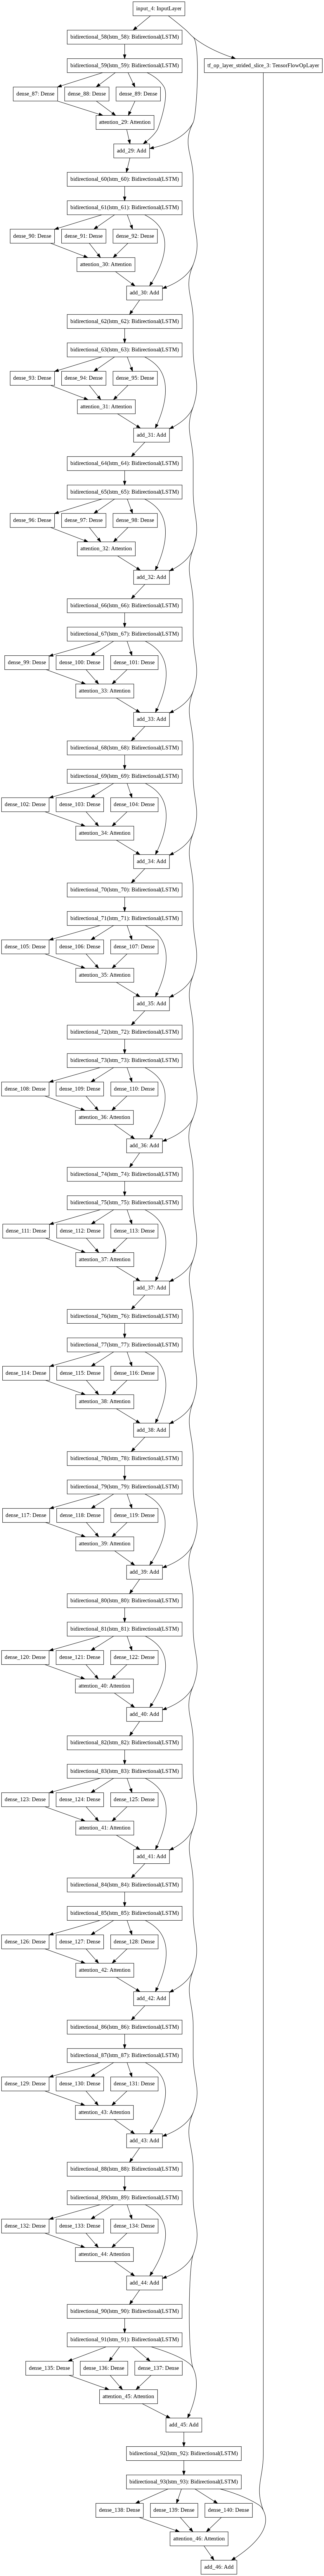

In [ ]:
keras.utils.plot_model(models[-1])

In [ ]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if (e > 25 and score < 0.93) or (e > 50 and score < 0.95) or (e > 10 and score < 0.7):
                print('This model has failed \n Skip to next model')
                break
            elif score < 0.97:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')
        tf.keras.backend.clear_session()

generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Starting to train  Resnet_shaped2_1
epoch :  0
7480/7480 - 602s - loss: 0.0022
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8943017268316686789677682848
epoch :  1
7480/7480 - 601s - loss: 7.0885e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9324794661762072946572172701
epoch :  2
7480/7480 - 600s - loss: 5.2331e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9218941181501032947198708642
epoch :  3
7480/7480 - 591s - loss: 4.7838e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8394555789051765908361030517
epoch :  4
7480/7480 - 595s - loss: 4.5989e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9392827123358176145028858500
epoch :  5
7480/7480 - 603s - loss: 4.3827e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9564816436591716349704975073
epoch :  6
7480/7480 - 595s - loss: 4.2777e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9480119682524320358983818421
epoch :  7
7480/7480 - 594s - loss: 4.1969e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9139807508154165383616010829
epoch :  8
7480/7480 - 596s - loss: 4.1140e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9480160210991318513921941158
epoch :  9
7480/7480 - 594s - loss: 4.0450e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9362232452487058282294331624
epoch :  10
7480/7480 - 593s - loss: 3.9991e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9576132359456293962584406909
epoch :  11
7480/7480 - 590s - loss: 3.9466e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9472321175169549857029985779
epoch :  12
7480/7480 - 589s - loss: 3.9137e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9486031407602275429372650737
epoch :  13
7480/7480 - 591s - loss: 3.8893e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9458582861996418899424371785
epoch :  14
7480/7480 - 603s - loss: 3.8528e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9532557790860236034775639079
epoch :  15
7480/7480 - 605s - loss: 3.7891e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9631946237704859207332694458
epoch :  16
7480/7480 - 607s - loss: 3.7298e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9563547899156124679989340753
epoch :  17
7480/7480 - 604s - loss: 3.6764e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9498183716660409846364280714
epoch :  18
7480/7480 - 606s - loss: 3.6261e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9522203612181552453138406747
epoch :  19
7480/7480 - 606s - loss: 3.5585e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9503973348071594705117959463
epoch :  20
7480/7480 - 604s - loss: 3.5172e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9535870093296707605624440181
epoch :  21
7480/7480 - 602s - loss: 3.4872e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9495596157111799670924628693
epoch :  22
7480/7480 - 601s - loss: 3.4510e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9475553520081939145755881405
epoch :  23
7480/7480 - 590s - loss: 3.4173e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9461084136604926646867475866
epoch :  24
7480/7480 - 590s - loss: 3.3950e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9492943099653509625915146807
epoch :  25
7480/7480 - 590s - loss: 3.3829e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9450753209485461916207843848
epoch :  26
7480/7480 - 589s - loss: 3.3587e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9490589405976463267594100129
epoch :  27
7480/7480 - 592s - loss: 3.3386e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9404763998831018214611919062
epoch :  28
7480/7480 - 592s - loss: 5.8639e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9445566527066260822255901371
epoch :  29
7480/7480 - 594s - loss: 3.9228e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9494213169130807493757724471
epoch :  30
7480/7480 - 592s - loss: 3.4793e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9412158697900532341067612461
epoch :  31
7480/7480 - 593s - loss: 3.3777e-04
checking for TaPR...


Progress:[==============================] 100.0%

This model has failed 
 Skip to next model
Starting to train  Resnet_shaped2_2
epoch :  0
7480/7480 - 1193s - loss: 0.0022
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9112775563873399868630315949
epoch :  1


In [8]:
def model():                                   
    inp = layers.Input(shape = (timelen,79))
    mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(inp)
    mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
    att1 = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    mid = layers.Add()([inp, mid, att1])

    for _ in range(3):
        mid = layers.Bidirectional(layers.LSTM(79, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    for i in range(4):
        mid = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])


    for i in range(6):
        mid = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])


    for i in range(3):
        mid = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(mid)
        mid,_ = layers.Bidirectional(layers.LSTM(79, return_sequences=True), merge_mode=None)(mid)
        att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
        mid = layers.Add()([inp, mid, att])

    mid, _ = layers.Bidirectional(layers.LSTM(100, return_sequences=True), merge_mode=None)(mid)
    mid, _ = layers.Bidirectional(layers.LSTM(79, return_sequences=False), merge_mode=None)(mid)
    att = layers.Attention()([layers.Dense(79)(mid), layers.Dense(79)(mid), layers.Dense(79)(mid)])
    out = layers.Add()([inp[:,0,:], mid, att])
    model = keras.Model(inputs = inp, outputs = out)
    model.compile(optimizer=optim,loss='MSE')
    print(model.summary())
    return model
models = [model()]
Modelnames = [Modelname + '_' + str(i+1) for i in range(len(models))]

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 79)]    0                                            
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 100, 158)     100488      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_37 (Bidirectional [(None, 100, 79), (N 150416      bidirectional_36[0][0]           
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 100, 79)      6320        bidirectional_37[0][0]           
_______________________________________________________________________________________

In [12]:
# data loader
class Train_DataLoader(keras.utils.Sequence):  # [timegen, timegen, ...] 으로 된 것을 랜덤하게 합쳐준다.
    def __init__(self,train_list):
        self.train_list = train_list
        idx = []
        for num, item in enumerate(train_list):
            idx = [(num, i) for i in range(len(item))]
        random.shuffle(idx)
        self.idx = idx

    def __getitem__(self, i):
        target_machine = self.idx[i][0]
        target_idx = self.idx[i][1]
        target = self.train_list[target_machine][target_idx]
        return target     # X, Y 형태로 나오고 있음.

    def __len__(self):
        return len(self.idx)

train = Train_DataLoader(train_list_seq)

# training...
def generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list):  # loss 에서 대회 주어진거 사용해야할듯
    histories = {m : [] for m in Modelnames}
    for model, modelname in zip(models, Modelnames):
        print("Starting to train ",modelname)
        for e in range(epoch):
            print('epoch : ',e)
            with tf.device('/device:GPU:0'):
                his_temp = model.fit(train, epochs = 1, verbose = 2)
            histories[modelname].append(his_temp)
            valid_result = test_and_get_list(model, valid_list_seq, valid_list)
            score, threshold = find_best_th(0.01, 0.1, valid_result, valid_label)
            if (e > 25 and score < 0.91) or (e > 50 and score < 0.95):
                print('This model has failed \n Skip to next model')
                break
            elif score < 0.96:
                print('  This epoch failed, score : ', score)
            else:
                print('I see hope in this model : ', modelname, '  epoch : ', e, '  score : ', score,'  TH_ : ',threshold) 
                model.save(path + modelname + '_epoch_' + str(e) + '.h5')
                print('model save : ', modelname + '_epoch_' + str(e) + '.h5')
                test_result = test_and_get_list(model, test_list_seq, test_list)
                test_label = put_labels(test_result, threshold)
                check_graph(test_result, test_label, piece = 2, THRESHOLD= threshold)
                submission = pd.read_csv(path_submission)
                submission['attack'] = test_label
                submission.to_csv(path+'submission_'+str(Modelname)+'_TH_'+str(threshold)+'_score_'+str(score)+'.csv',index = False)
                print('submission saved')
        tf.keras.backend.clear_session()

generate_and_train_model(train, epoch, Modelnames, valid_list_seq, valid_list)

Starting to train  Resnet_shaped2_1
epoch :  0
7480/7480 - 2984s - loss: 0.0022
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9166128309842982183390785163
epoch :  1
7480/7480 - 2991s - loss: 6.2913e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8535801436426778319105994129
epoch :  2
7480/7480 - 2958s - loss: 5.1618e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8060874771686471383239146317
epoch :  3
7480/7480 - 2981s - loss: 4.8515e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8757687982002437524854642514
epoch :  4
7480/7480 - 2986s - loss: 4.4492e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9388152028729817613677310528
epoch :  5
7480/7480 - 2982s - loss: 4.2383e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9481462776549089526047897198
epoch :  6
7480/7480 - 2983s - loss: 4.1690e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6945814787330474860820032183
epoch :  7
7480/7480 - 2993s - loss: 4.0456e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8571657653255614931935423918
epoch :  8
7480/7480 - 2990s - loss: 3.9819e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9167378674066194417989732798
epoch :  9
7480/7480 - 2996s - loss: 3.9260e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8835189026480623656342008544
epoch :  10
7480/7480 - 2995s - loss: 4.6298e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.8385876167804849398310032434
epoch :  11
7480/7480 - 2991s - loss: 3.8631e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.6644885197535207973159810580
epoch :  12
7480/7480 - 2990s - loss: 3.8866e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7893636132080583021433759363
epoch :  13
7480/7480 - 2985s - loss: 3.7298e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.7156857005374186714274429829
epoch :  14
7480/7480 - 2994s - loss: 3.7055e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9380001606431997690061716592
epoch :  15
7480/7480 - 3008s - loss: 3.6174e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9441258712481917740378942568
epoch :  16
7480/7480 - 2997s - loss: 3.5877e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9422621611594271436953134022
epoch :  17
7480/7480 - 2998s - loss: 3.5297e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9394505700232334740167609307
epoch :  18
7480/7480 - 3002s - loss: 3.5051e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9427657153762083850632046349
epoch :  19
7480/7480 - 3005s - loss: 3.4426e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9387438920859678646411462897
epoch :  20
7480/7480 - 2987s - loss: 3.4205e-04
checking for TaPR...


Progress:[==============================] 100.0%

  This epoch failed, score :  0.9417294436393000706169950000
epoch :  21


KeyboardInterrupt: ignored